# Classifier tuning for ACM ASIACC paper

## Loading data and selecting features of interest

In [61]:
import pyarrow as pa
import pyarrow.parquet as pq

#phishing = pq.read_table('floor/phishing_2307.parquet')
phishing = pq.read_table('floor/phishing_2311.parquet')
benign = pq.read_table('floor/benign_2310.parquet')

from transformers.drop_nontrain import drop_nontrain_table as drop_nontrain
phishing = drop_nontrain(phishing)
benign = drop_nontrain(benign)

# realign schemas (parquet files save in nonsense orders)
benign = benign.cast(phishing.schema)

# concatentate tables
data = pa.concat_tables([phishing, benign])
df = data.to_pandas()

print(f"Total records: {len(df)}")

from transformers.cast_timestamp import cast_timestamp
df = cast_timestamp(df)

used_features = [

    # IP  ===============================
    # Used in the original NOMS paper
    "ip_mean_average_rtt",
    "ip_entropy",
    "ip_count",
    #"ip_v4_count", "ip_v6_count", # Moved RDAP and RENAMED to rdap_ip
    
    # Newly added for ACM ASIACCS
    "ip_v4_ratio",
    #"ip_a_aaaa_to_all_ratio", <--- not useful for this dataset
    "ip_as_address_entropy",
    "ip_asn_entropy",
    "ip_distinct_as_count",
    
    # DNS  ===============================
    # Used in the original NOMS paper
    "dns_A_count",
    "dns_AAAA_count",
    "dns_MX_count",
    "dns_NS_count",
    #"dns_SOA_count", <-- REMOVED, very low effect -------------------------------------
    "dns_TXT_count",
    "dns_CNAME_count",
    "dns_soa_primary_ns_len",
    "dns_soa_primary_ns_level", # renamed
    "dns_soa_primary_ns_digit_count",
    "dns_soa_primary_ns_entropy",
    "dns_soa_email_len",
    "dns_soa_email_level", # renamed
    "dns_soa_email_digit_count",
    "dns_soa_email_entropy",
    # "dns_soa_serial", <-- Doesn't convey any kind of comparative information
    "dns_soa_refresh",
    "dns_soa_retry",
    "dns_soa_expire",
    "dns_mx_avg_len",
    "dns_mx_avg_entropy",
    "dns_domain_name_in_mx",
    "dns_txt_spf_exists",
    "dns_txt_avg_entropy",
    "dns_txt_dkim_exists",
    
    "dns_zone_level",
    "dns_zone_digit_count",
    "dns_zone_len",
    "dns_zone_entropy",
    
    # Newly added for ACM ASIACCS
    "dns_resolved_record_types",
    "dns_has_dnskey",
    "dns_dnssec_score",
    "dns_ttl_avg",
    "dns_ttl_stdev",
    "dns_ttl_low",
    "dns_ttl_mid",
    "dns_ttl_distinct_count",
    "dns_soa_min_ttl", # why is this not in NOMS?!
    "dns_txt_external_verification_score",
    "dns_txt_dmarc_exists",
    
    
    # TLS  ===============================
    # Used in the original NOMS paper
    "tls_broken_chain",
    "tls_expired_chain",
    "tls_is_self_signed", # <--- NEW (23-12-02)
    "tls_root_authority_hash", # <--- NEW (23-12-02)
    "tls_leaf_authority_hash", # <--- NEW (23-12-02)
    "tls_total_extension_count",
    "tls_critical_extensions",
    "tls_with_policies_crt_count",
    "tls_percentage_crt_with_policies",
    "tls_x509_anypolicy_crt_count",
    "tls_iso_policy_crt_count",
    "tls_joint_isoitu_policy_crt_count",
    # "tls_iso_policy_oid", <-- Basically a random value, doesn't make much sense when collected like this; policy OIDs need more research
    # "tls_isoitu_policy_oid", <-- same
    #"tls_unknown_policy_crt_count", <-- Abandoned, no useful values
    "tls_root_cert_validity_len",
    "tls_leaf_cert_validity_len",
    "tls_chain_len",
    #"tls_root_cert_lifetime", <---- NO!
    #"tls_leaf_cert_lifetime", <---- NO!
    "tls_subject_count",
    "tls_unique_SLD_count",
    "tls_server_auth_crt_count",
    "tls_client_auth_crt_count",
    "tls_CA_certs_in_chain_ratio",
    "tls_common_name_count",
    
    # Newly added for ACM ASIACCS
    #"tls_has_tls", , <-- REMOVED, very low effect -------------------------------------
    "tls_negotiated_version_id",
    "tls_negotiated_cipher_id",
    
    # LEX ===============================
    # Used in the original NOMS paper
    "lex_name_len",
    #"lex_digit_count", <-- abandoned, almost the same as "lex_sub_digit_ratio"
    "lex_has_digit",
    "lex_phishing_keyword_count",
    #"lex_vowel_count", <-- moved to sub
    #"lex_underscore_hyphen_count", <--- same as nonalnum
    "lex_consecutive_chars",
    "lex_tld_len",
    "lex_tld_abuse_score", # *************************************************************
    "lex_tld_hash", # *************************************************************
    
    "lex_sld_len",
    "lex_sld_norm_entropy", # <-- newly added feature on 23-09-29
    # ============================= New SLD features 23-11
    "lex_sld_phishing_keyword_count",
    #"lex_sld_digit_count",
    #"lex_sld_digit_ratio",
    "lex_sld_vowel_count",
    "lex_sld_vowel_ratio",
    "lex_sld_consonant_count",
    "lex_sld_consonant_ratio",
    "lex_sld_non_alphanum_count",
    "lex_sld_non_alphanum_ratio",
    "lex_sld_hex_count",
    "lex_sld_hex_ratio",
    # =============================      
    
    "lex_sub_count",
    "lex_stld_unique_char_count",
    "lex_begins_with_digit",
    "lex_www_flag",
    "lex_sub_max_consonant_len",
    "lex_sub_norm_entropy",
    "lex_sub_digit_count",
    "lex_sub_digit_ratio",
    "lex_sub_consonant_ratio",
    "lex_sub_non_alphanum_ratio",
    "lex_sub_hex_ratio",

    #"lex_bigram_matches",  # OLD NAME
    #"lex_trigram_matches", # OLD NAME
    "lex_phishing_bigram_matches",  # NEW NAME
    "lex_phishing_trigram_matches", # NEW NAME
    "lex_phishing_tetragram_matches", # *************************************************************
    "lex_phishing_pentagram_matches", # *************************************************************
    "lex_sub_vowel_count",
    "lex_sub_vowel_ratio",
    "lex_sub_consonant_count",
    "lex_sub_non_alphanum_count",
    "lex_sub_hex_count",
    "lex_avg_part_len",
    "lex_stdev_part_lens",
    "lex_longest_part_len",
    "lex_shortest_sub_len",
    
    # RDAP ===============================
    # Used in the original NOMS paper
    "rdap_registration_period",
    "rdap_domain_age",
    "rdap_time_from_last_change",
    "rdap_domain_active_time",
    "rdap_has_dnssec",
    "rdap_ip_v4_count", "rdap_ip_v6_count", # <-- used for NOMS, but now prefixed with rdap_
    
    # Newly added for ACM ASIACCS
    "rdap_registrar_name_len",
    "rdap_registrar_name_entropy",
    "rdap_registrar_name_hash",
    "rdap_registrant_name_len",
    "rdap_registrant_name_entropy",
    "rdap_admin_name_len",
    "rdap_admin_name_entropy",
    "rdap_admin_email_len",
    "rdap_admin_email_entropy",
    
    "rdap_ip_shortest_v4_prefix_len",
    "rdap_ip_longest_v4_prefix_len",
    "rdap_ip_shortest_v6_prefix_len",
    "rdap_ip_longest_v6_prefix_len",
    
    "rdap_ip_avg_admin_name_len",
    "rdap_ip_avg_admin_name_entropy",
    "rdap_ip_avg_admin_email_len",
    "rdap_ip_avg_admin_email_entropy",
    
    # GEO ===============================
    # Used in the original NOMS paper
    "geo_countries_count",
    "geo_continent_hash",
    "geo_countries_hash",
    
    # Newly added for ACM ASIACCS
    "geo_lat_stdev", # <- Puvodne to pridal Adam, ale pak jsme dali pryc, ze to budem resit jinak.
    "geo_lon_stdev",  #    Ale muze byt helpful pro identifikaci, jestli lokality jsou blizko sebe.    
    #"geo_min_lat", # not very useful
    #"geo_max_lat", # not very useful
    #"geo_min_lon", # not very useful
    #"geo_max_lon", # not very useful
    "geo_mean_lat", # *************************************************************
    "geo_mean_lon", # *************************************************************
    #"geo_lat_range", # not very useful
    #"geo_lon_range", # not very useful
    "geo_centroid_lat", # *************************************************************
    "geo_centroid_lon", # *************************************************************
    #"geo_estimated_area",  # not very useful 
]


print("Number of used features: " + str(len(used_features)))

# NUMBER OF AVAILABLE AND UNUSED FEATURES
missing_columns = set(df.columns) - set(used_features) - set(["label"])
print("No. of available unused features: " + str(len(missing_columns)))

df = df[["label", *used_features]]


Total records: 500925
Number of used features: 143
No. of available unused features: 36


## Subsampling entire dataset (only for testing/tuning purposes)

In [62]:
subsample = 0.2 # 1.0 means no subsample

if subsample < 1.0:
    df = df.sample(frac=subsample)

## Supressing unwanted warnings (futures etc.)

In [63]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.*')
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost.*')
warnings.filterwarnings('ignore', message="Series.__getitem__ treating keys as positions is deprecated.*")

## Shortening feature names (for paper purposes)

In [64]:
shortening = {
    "lex_stld_unique_char_count": "lex_stld_uniq_char_cnt",
    "lex_sub_max_consonant_len": "lex_max_conson_len",
    "lex_sub_non_alphanum_count": "lex_sub_nonalnum_count",
    "lex_sub_non_alphanum_ratio": "lex_sub_nonalnum_ratio",
    "lex_phishing_keyword_count": "lex_phishing_kw_count",
    "lex_sld_phishing_keyword_count": "lex_sld_phishing_kw_count",
    
    "dns_resolved_record_types": "dns_resolved_rec_types",
    "dns_domain_name_in_mx": "dns_dn_in_mx",
    "dns_txt_external_verification_score": "dns_txt_ext_verif_score",
    "dns_zone_digit_count": "dns_zone_digits",
    "dns_soa_primary_ns_digit_count": "dns_soa_prim_ns_digits",
    "dns_soa_primary_ns_len" : "dns_soa_pri_ns_len",
    "dns_soa_primary_ns_level": "dns_soa_pri_ns_level",
    "dns_soa_primary_ns_entropy": "dns_soa_pri_ns_entropy",
    "dns_soa_email_digit_count": "dns_soa_email_digits",
    
    "tls_percentage_crt_with_policies": "tls_percentage_with_policies",
    "tls_x509_anypolicy_crt_count": "tls_x509_anypol_crt_count",
    "tls_iso_policy_crt_count": "tls_iso_pol_crt_count",
    "tls_joint_isoitu_policy_crt_count": "tls_isoitu_pol_crt_count",
    
    "rdap_ip_avg_admin_name_entropy": "rdap_ip_avg_admin_name_ent",
    "rdap_ip_avg_admin_email_entropy": "rdap_ip_avg_admin_email_ent"
}

df.rename(columns=shortening, inplace=True)

df

label  ip_mean_average_rtt  ip_entropy  ip_count  \
408122  benign_2310:unknown             0.000000    1.000000         2   
341649  benign_2310:unknown             3.792667    0.918296         3   
131704  benign_2310:unknown             0.000000    2.584963         6   
368520  benign_2310:unknown            20.169000    1.000000         2   
41273    misp_2310:phishing             8.778000   -0.000000         2   
...                     ...                  ...         ...       ...   
211894  benign_2310:unknown             0.000000    2.405639        16   
301829  benign_2310:unknown             3.874667    0.918296         6   
225042  benign_2310:unknown            23.942000   -0.000000         1   
28508    misp_2310:phishing            -1.000000   -0.000000         0   
476787  benign_2310:unknown             8.724500    1.000000         4   

        ip_v4_ratio  ip_as_address_entropy  ip_asn_entropy  \
408122          1.0               1.000000            -0.0   
341649          1.0               0.918296            -0.0   
131704          0.0               2.251629            -0.0   
368520          1.0               1.000000             1.0   
41273           0.5              -0.000000            -0.0   
...             ...                    ...             ...   
211894          0.0              -0.000000            -0.0   
301829          0.5               0.918296            -0.0   
225042          1.0              -0.000000            -0.0   
28508           0.0                    NaN             NaN   
476787          0.0              -0.000000            -0.0   

        ip_distinct_as_count  dns_A_count  dns_AAAA_count  ...  \
408122                   1.0            2               0  ...   
341649                   1.0            3               0  ...   
131704                   1.0            0               0  ...   
368520                   2.0            2               0  ...   
41273                    1.0            1               1  ...   
...                      ...          ...             ...  ...   
211894                   1.0            0               0  ...   
301829                   1.0            3               3  ...   
225042                   1.0            1               0  ...   
28508                    NaN            0               0  ...   
476787                   1.0            0               0  ...   

        rdap_ip_avg_admin_email_ent  geo_countries_count  geo_continent_hash  \
408122                     0.149881                    1                   1   
341649                     0.198468                    2                   1   
131704                     0.149881                    1                   1   
368520                     0.078721                    2                   3   
41273                      0.157442                    1                   1   
...                             ...                  ...                 ...   
211894                     0.086283                    1                   3   
301829                     0.198468                    2                   1   
225042                     0.000000                    1                   3   
28508                      0.000000                    0                   0   
476787                     0.138975                    1                   1   

        geo_countries_hash  geo_lat_stdev  geo_lon_stdev  geo_mean_lat  \
408122                 187        0.19430        0.12110      38.85260   
341649                 974        0.00000        0.00000      37.75100   
131704                 187        0.00000        0.00000      39.04690   
368520                 140        0.49210        0.01760      51.34550   
41273                  187        0.00000        0.00000      37.75100   
...                    ...            ...            ...           ...   
211894                  65        0.00000        0.00000      52.51960   
301829                 974        0.00000 

# NaNs will be replaced by -1 (best results)

In [65]:
# Handle NaNs
df.fillna(-1, inplace=True)

# Train-Test Split

In [66]:
from config import Config
from sklearn.model_selection import train_test_split

class_map = {"benign_2310:unknown": 0, "misp_2310:phishing": 1}

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

X_train, X_test, y_train, y_test = train_test_split(
  features,
  labels,
  test_size=0.3,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

## Custom tuning metric

Allow for setting weights for **Precision, F1, FPR, logloss** and **Overfitting** (difference between train and test scores).
* If you want to use it, the **scoring** should be set to **FETA_Score** on hyperparameter tuning.
* Otherwise, you can set **scoring** to metric you want: **neg_log_loss**, **precision**, **f1**, etc.

In [67]:
def FETA_Score(estimator, X, y):
    # Getting predictions
    y_pred = estimator.predict(X)
    y_pred_proba = estimator.predict_proba(X)
    
    # Calculating precision
    precision = precision_score(y, y_pred)
    
    # Calculating F1-score
    f1 = f1_score(y, y_pred)
    
    # Calculating FPR
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # Calculating Log Loss
    logloss = log_loss(y, y_pred_proba)
    
    # Estimating overfitting
    train_score = estimator.score(X_train, y_train) 
    validation_score = estimator.score(X, y) 
    overfitting = train_score - validation_score
    
    # Assigning weights
    w_precision = 0.1     # Precision
    w_f1 = 0.4            # F1
    w_fpr = -0.1          # Negative because lower FPR is better
    w_logloss = -0.1      # Negative because lower log loss is better
    w_overfitting = -0.5  # Negative because lower overfitting is better
    
    # Combining metrics with weights
    combined_score = (w_precision * precision + w_f1 * f1 + w_fpr * fpr + w_overfitting * overfitting)
    
    return combined_score


In [19]:
# Helpers
from kneed import KneeLocator

def plot_metric(metric):
    plt.rcParams["figure.dpi"] = 300
    
    # Plot metric curves
    plt.plot(x_axis, results['training'][metric], label='Training set')
    plt.plot(x_axis, results['valid_1'][metric], label='Testing set')
    
    # Detect elbow using Kneedle algorithm
    kn = KneeLocator(x_axis, results['valid_1'][metric], curve='convex', direction='decreasing')
    if kn.knee:
        plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Elbow at tree ' + str(kn.knee))
    
    plt.legend()
    mnames = {'error': 'Classification Error', 'binary_logloss': 'Log Loss', 'auc': 'AUC'}
    mname = mnames.get(metric, metric)  # Return the metric itself if it's not in the dictionary
    plt.ylabel(mname)
    plt.xlabel('Number of trees')
    plt.title('LightGBM ' + mname)
    plt.show()

    
# Tuning - graphs
def DisplayTuningGraph(scores):
    from numpy import array
    from numpy.ma import masked_array

    col_names = ['mean_train_score', 'mean_test_score']
    means_df = scores[col_names]
    ax = means_df.plot(kind='line', grid=True)

    from matplotlib import pyplot as plt
    plt.rcParams["figure.figsize"] = [12, 12]
    plt.rcParams["figure.autolayout"] = True

    plt.rcParams["figure.dpi"] = 300

    max_ids = means_df.idxmax(axis=0)

    for i in range(len(max_ids)):
        for col_name in col_names:
            value = means_df[col_name][max_ids[i]]
            id = max_ids[i]

            color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'

            ax.scatter([id], [value],
                      marker='o',
                      color=color,
                      label='point',)

            ax.annotate(str(round(value, 3))+"_ID="+str(id),
                        (id, value),
                        xytext=(id+3, value))
    print(scores)
    
def ValidateModel(X_test, y_test, model): 
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate False Positive Rate (FPR)
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)

    print("TN: " + str(tn) + " <-- True Negatives")
    print("FP: " + str(fp) + " <-- False Positives")
    print("FN: " + str(fn) + " <-- False Negatives")
    print("TP: " + str(tp) + " <-- True Positives")

    print("FPR:" + str(fpr) + " <-- False Positive Rate")
    print("TPR:" + str(tpr) + " <-- True Positive Rate (same as Recall)")
    print(" ")

    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = [8, 6]
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["figure.dpi"] = 300

    from sklearn.metrics import classification_report, ConfusionMatrixDisplay, det_curve
    print(classification_report(y_test, y_pred, digits=4))

    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)  # Compute confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # Create display object
    disp.plot(cmap=plt.cm.Blues)  # Plot confusion matrix
    plt.show()  # Show the plot


import warnings

# Filter out the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module='xgboost.data')

    
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, log_loss, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from kneed import KneeLocator

def ValidateModel_advanced(X_test, y_test, model): 
    y_pred = model.predict(X_test)
    
    # Classification report
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    tn, fp, fn, tp = cm.ravel()
    print("Confusion Matrix:")
    print("TN:", tn, "FP:", fp, "FN:", fn, "TP:", tp)

    # Plotting ROC Curve
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Model-specific evaluations
    if isinstance(model, (XGBClassifier, LGBMClassifier)):
        
        if isinstance(model, (XGBClassifier)):
            results = model.evals_result()
        elif isinstance(model, (LGBMClassifier)):
            results = model.evals_result_

        training_key = 'training' if isinstance(model, LGBMClassifier) else 'validation_0'
        validation_key = 'valid_1' if isinstance(model, LGBMClassifier) else 'validation_1'
        
        print("Training metrics:", results[training_key].keys())
        print("Validation metrics:", results[validation_key].keys())

        trees = len(results[validation_key]['binary_logloss']) if isinstance(model, LGBMClassifier) else len(results[validation_key]['logloss'])
        x_axis = range(0, trees)

        def plot_metric(metric):
            plt.rcParams["figure.dpi"] = 300

            # Plot metric curves
            plt.plot(x_axis, results[training_key][metric], label='Training set')
            plt.plot(x_axis, results[validation_key][metric], label='Validation set')

            # Detect elbow using Kneedle algorithm
            kn = KneeLocator(x_axis, results[validation_key][metric], curve='convex', direction='decreasing')
            if kn.knee:
                plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Elbow at tree ' + str(kn.knee))

            plt.legend()
            mnames = {'binary_logloss': 'Log Loss', 'auc': 'AUC'}
            mname = mnames.get(metric, metric)
            plt.ylabel(mname)
            plt.xlabel('Number of trees')
            plt.title(f'{type(model).__name__} {mname}')
            plt.show()

        if isinstance(model, LGBMClassifier):
            plot_metric('binary_logloss')
        elif isinstance(model, XGBClassifier):
            plot_metric('logloss')
            
        plot_metric('auc')
        
    elif isinstance(model, (RandomForestClassifier, AdaBoostClassifier)):
        # For RandomForest and AdaBoost, additional model-specific evaluations can be added here
        pass
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)  # Compute confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # Create display object
    disp.plot(cmap=plt.cm.Blues)  # Plot confusion matrix
    plt.show()  # Show the plot


# Logistic Regression

## Logistic Regression - Training

In [20]:
import warnings
# Filter out specific FutureWarnings from scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

# Import necessary libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler  # <-- Import this for scaling

# Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

# Hyperparameters
params = {
    'C': 30,  # Regularization parameter (default: 1.0)
    'penalty': 'l2',  # (default: l2)
    'max_iter': 3500,  # Maximum number of iterations (default: 100)
    "solver": "liblinear",
    'random_state': 7
}

# Train Logistic Regression model and display results
print("Logistic Regression:")
logreg = LogisticRegression(**params)  # <-- Increase max_iter
logreg.fit(x_train_scaled, y_train)  # <-- Use scaled data

Logistic Regression:


LogisticRegression(C=30, max_iter=3500, random_state=7, solver='liblinear')

## Logistic Regression - Validation

TN: 38308 <-- True Negatives
FP: 552 <-- False Positives
FN: 1161 <-- False Negatives
TP: 5063 <-- True Positives
FPR:0.014204837879567679 <-- False Positive Rate
TPR:0.8134640102827764 <-- True Positive Rate (same as Recall)
 
              precision    recall  f1-score   support

           0     0.9706    0.9858    0.9781     38860
           1     0.9017    0.8135    0.8553      6224

    accuracy                         0.9620     45084
   macro avg     0.9361    0.8996    0.9167     45084
weighted avg     0.9611    0.9620    0.9612     45084



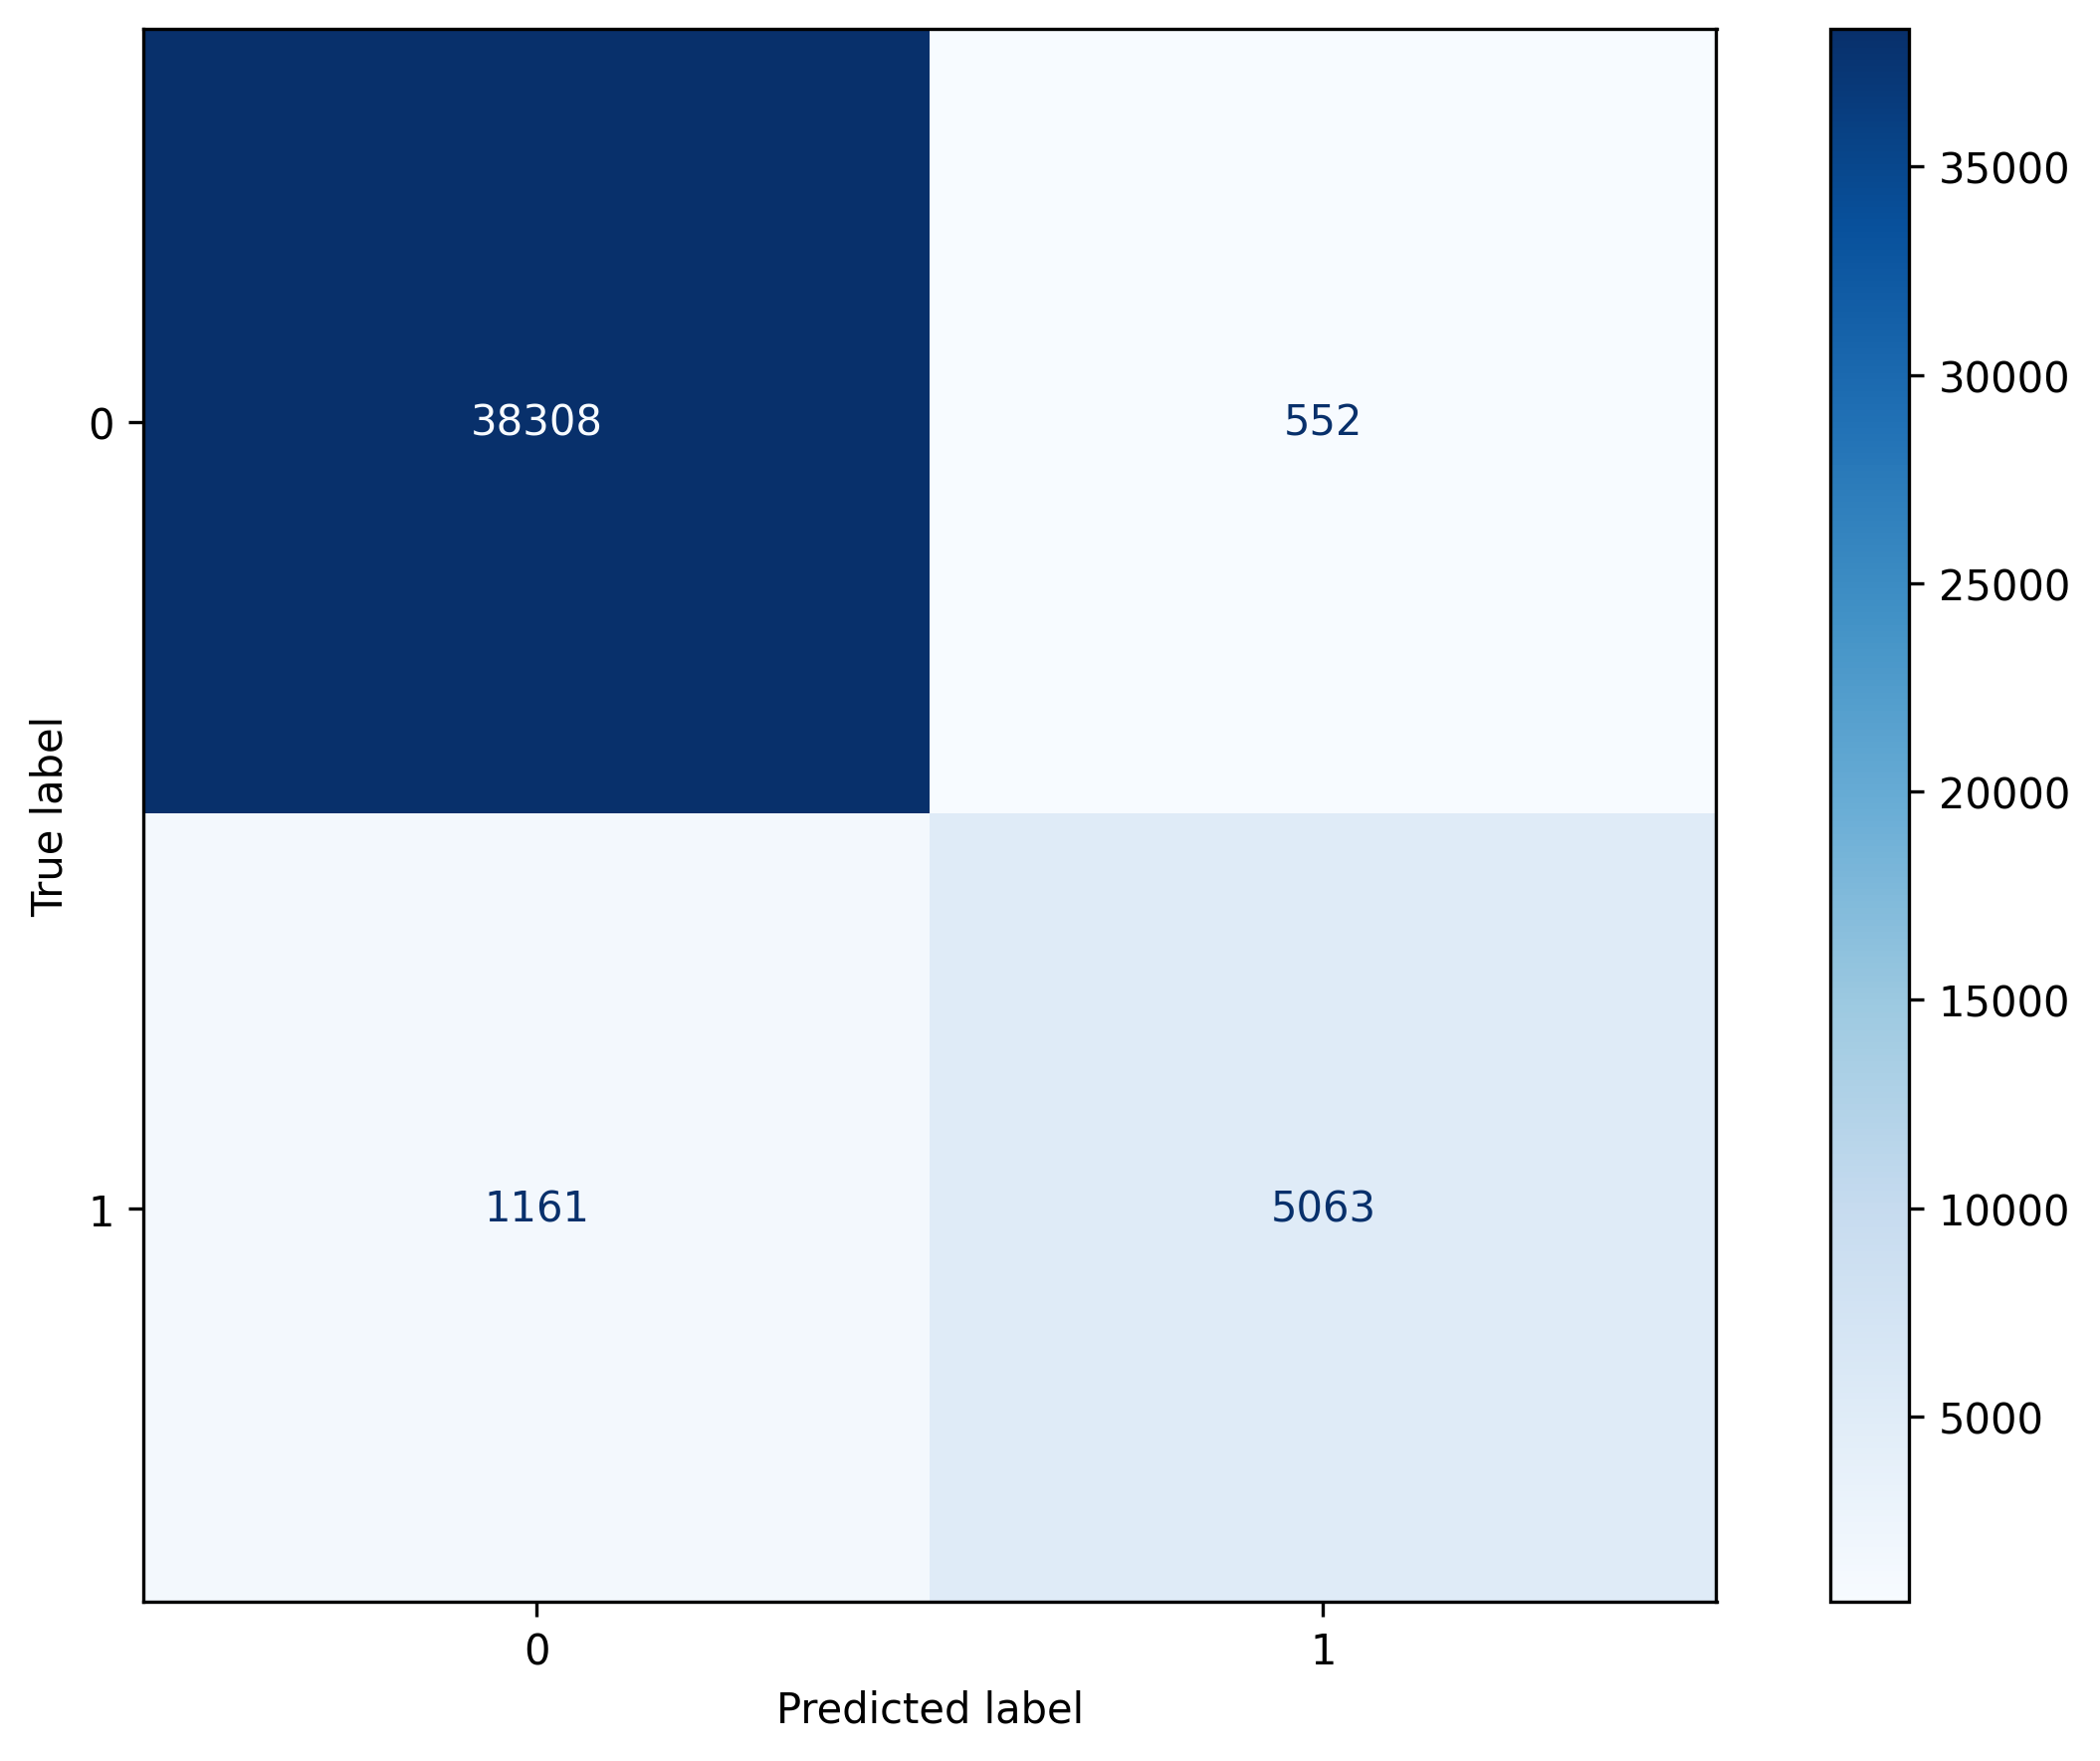

In [21]:
ValidateModel(x_test_scaled, y_test, logreg)

## Logistic Regression - Tuning

In [22]:
lr_tuning = False

if lr_tuning:
    import pandas as pd
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Logistic Regression base model
    logreg = LogisticRegression(random_state=7)

    # Grid of parameters to search
    grid = {
        'C': [30],  # Regularization parameter (default: 1.0)
        'penalty': ['l2'],  # None, l1, l2 (default), elasticnet (both l1 and l2)
        #'max_iter': [3500],  # Maximum number of iterations (default: 100)
        'max_iter': [3500],  # Maximum number of iterations (default: 100)
        "solver": ["liblinear"], #{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}
    }

    # Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

    # Grid Search
    grid_search = GridSearchCV(
        estimator=logreg,
        param_grid=grid,
        cv=cv,
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train_scaled, y_train)

    # Best estimator
    best_logreg = grid_search.best_estimator_

    # Results
    scores = pd.DataFrame(grid_search.cv_results_)
    

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END C=20, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.864, test=0.865) total time= 3.5min
[CV 2/2] END C=20, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.866, test=0.863) total time= 6.7min
[CV 1/2] END C=25, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.864, test=0.865) total time= 5.2min
[CV 2/2] END C=25, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.866, test=0.864) total time= 5.7min
[CV 1/2] END C=30, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.864, test=0.865) total time= 5.1min
[CV 2/2] END C=30, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.866, test=0.864) total time= 4.5min
[CV 1/2] END C=35, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.864, test=0.865) total time= 4.5min
[CV 2/2] END C=35, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.866, test=0.863) total time= 5.3min


   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0     306.944702     97.767193         0.072786        0.018480      20   
1     328.292865     16.260689         0.055395        0.001292      25   
2     289.493390     16.603389         0.058014        0.003574      30   
3     294.348258     23.094815         0.075473        0.016893      35   

  param_max_iter param_penalty param_solver  \
0           3500            l2    liblinear   
1           3500            l2    liblinear   
2           3500            l2    liblinear   
3           3500            l2    liblinear   

                                              params  split0_test_score  \
0  {'C': 20, 'max_iter': 3500, 'penalty': 'l2', '...           0.864666   
1  {'C': 25, 'max_iter': 3500, 'penalty': 'l2', '...           0.864670   
2  {'C': 30, 'max_iter': 3500, 'penalty': 'l2', '...           0.864700   
3  {'C': 35, 'max_iter': 3500, 'penalty': 'l2', '...           0.864678   

   split1_te

/tmp/ipykernel_3863682/2064128811.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = means_df[col_name][max_ids[i]]
/tmp/ipykernel_3863682/2064128811.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  id = max_ids[i]
/tmp/ipykernel_3863682/2064128811.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0     306.944702     97.767193         0.072786        0.018480      20   
1     328.292865     16.260689         0.055395        0.001292      25   
2     289.493390     16.603389         0.058014        0.003574      30   
3     294.348258     23.094815         0.075473        0.016893      35   

  param_max_iter param_penalty param_solver  \
0           3500            l2    liblinear   
1           3500            l2    liblinear   
2           3500            l2    liblinear   
3           3500            l2    liblinear   

                                              params  split0_test_score  \
0  {'C': 20, 'max_iter': 3500, 'penalty': 'l2', '...           0.864666   
1  {'C': 25, 'max_iter': 3500, 'penalty': 'l2', '...           0.864670   
2  {'C': 30, 'max_iter': 3500, 'penalty': 'l2', '...           0.864700   
3  {'C': 35, 'max_iter': 3500, 'penalty': 'l2', '...           0.864678   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  \
0           0.863406         0.864036        0.000630                3   
1           0.863561         0.864115        0.000555                2   
2           0.863553         0.864126        0.000573                1   
3           0.863365         0.864022        0.000657                4   

   split0_train_score  split1_train_score  mean_train_score  std_train_score  
0            0.863941            0.866308          0.865125         0.001184  
1            0.864153            0.866393          0.865273         0.001120  
2            0.864176            0.866365          0.865271         0.001094  
3            0.864464            0.866428          0.865446         0.000982

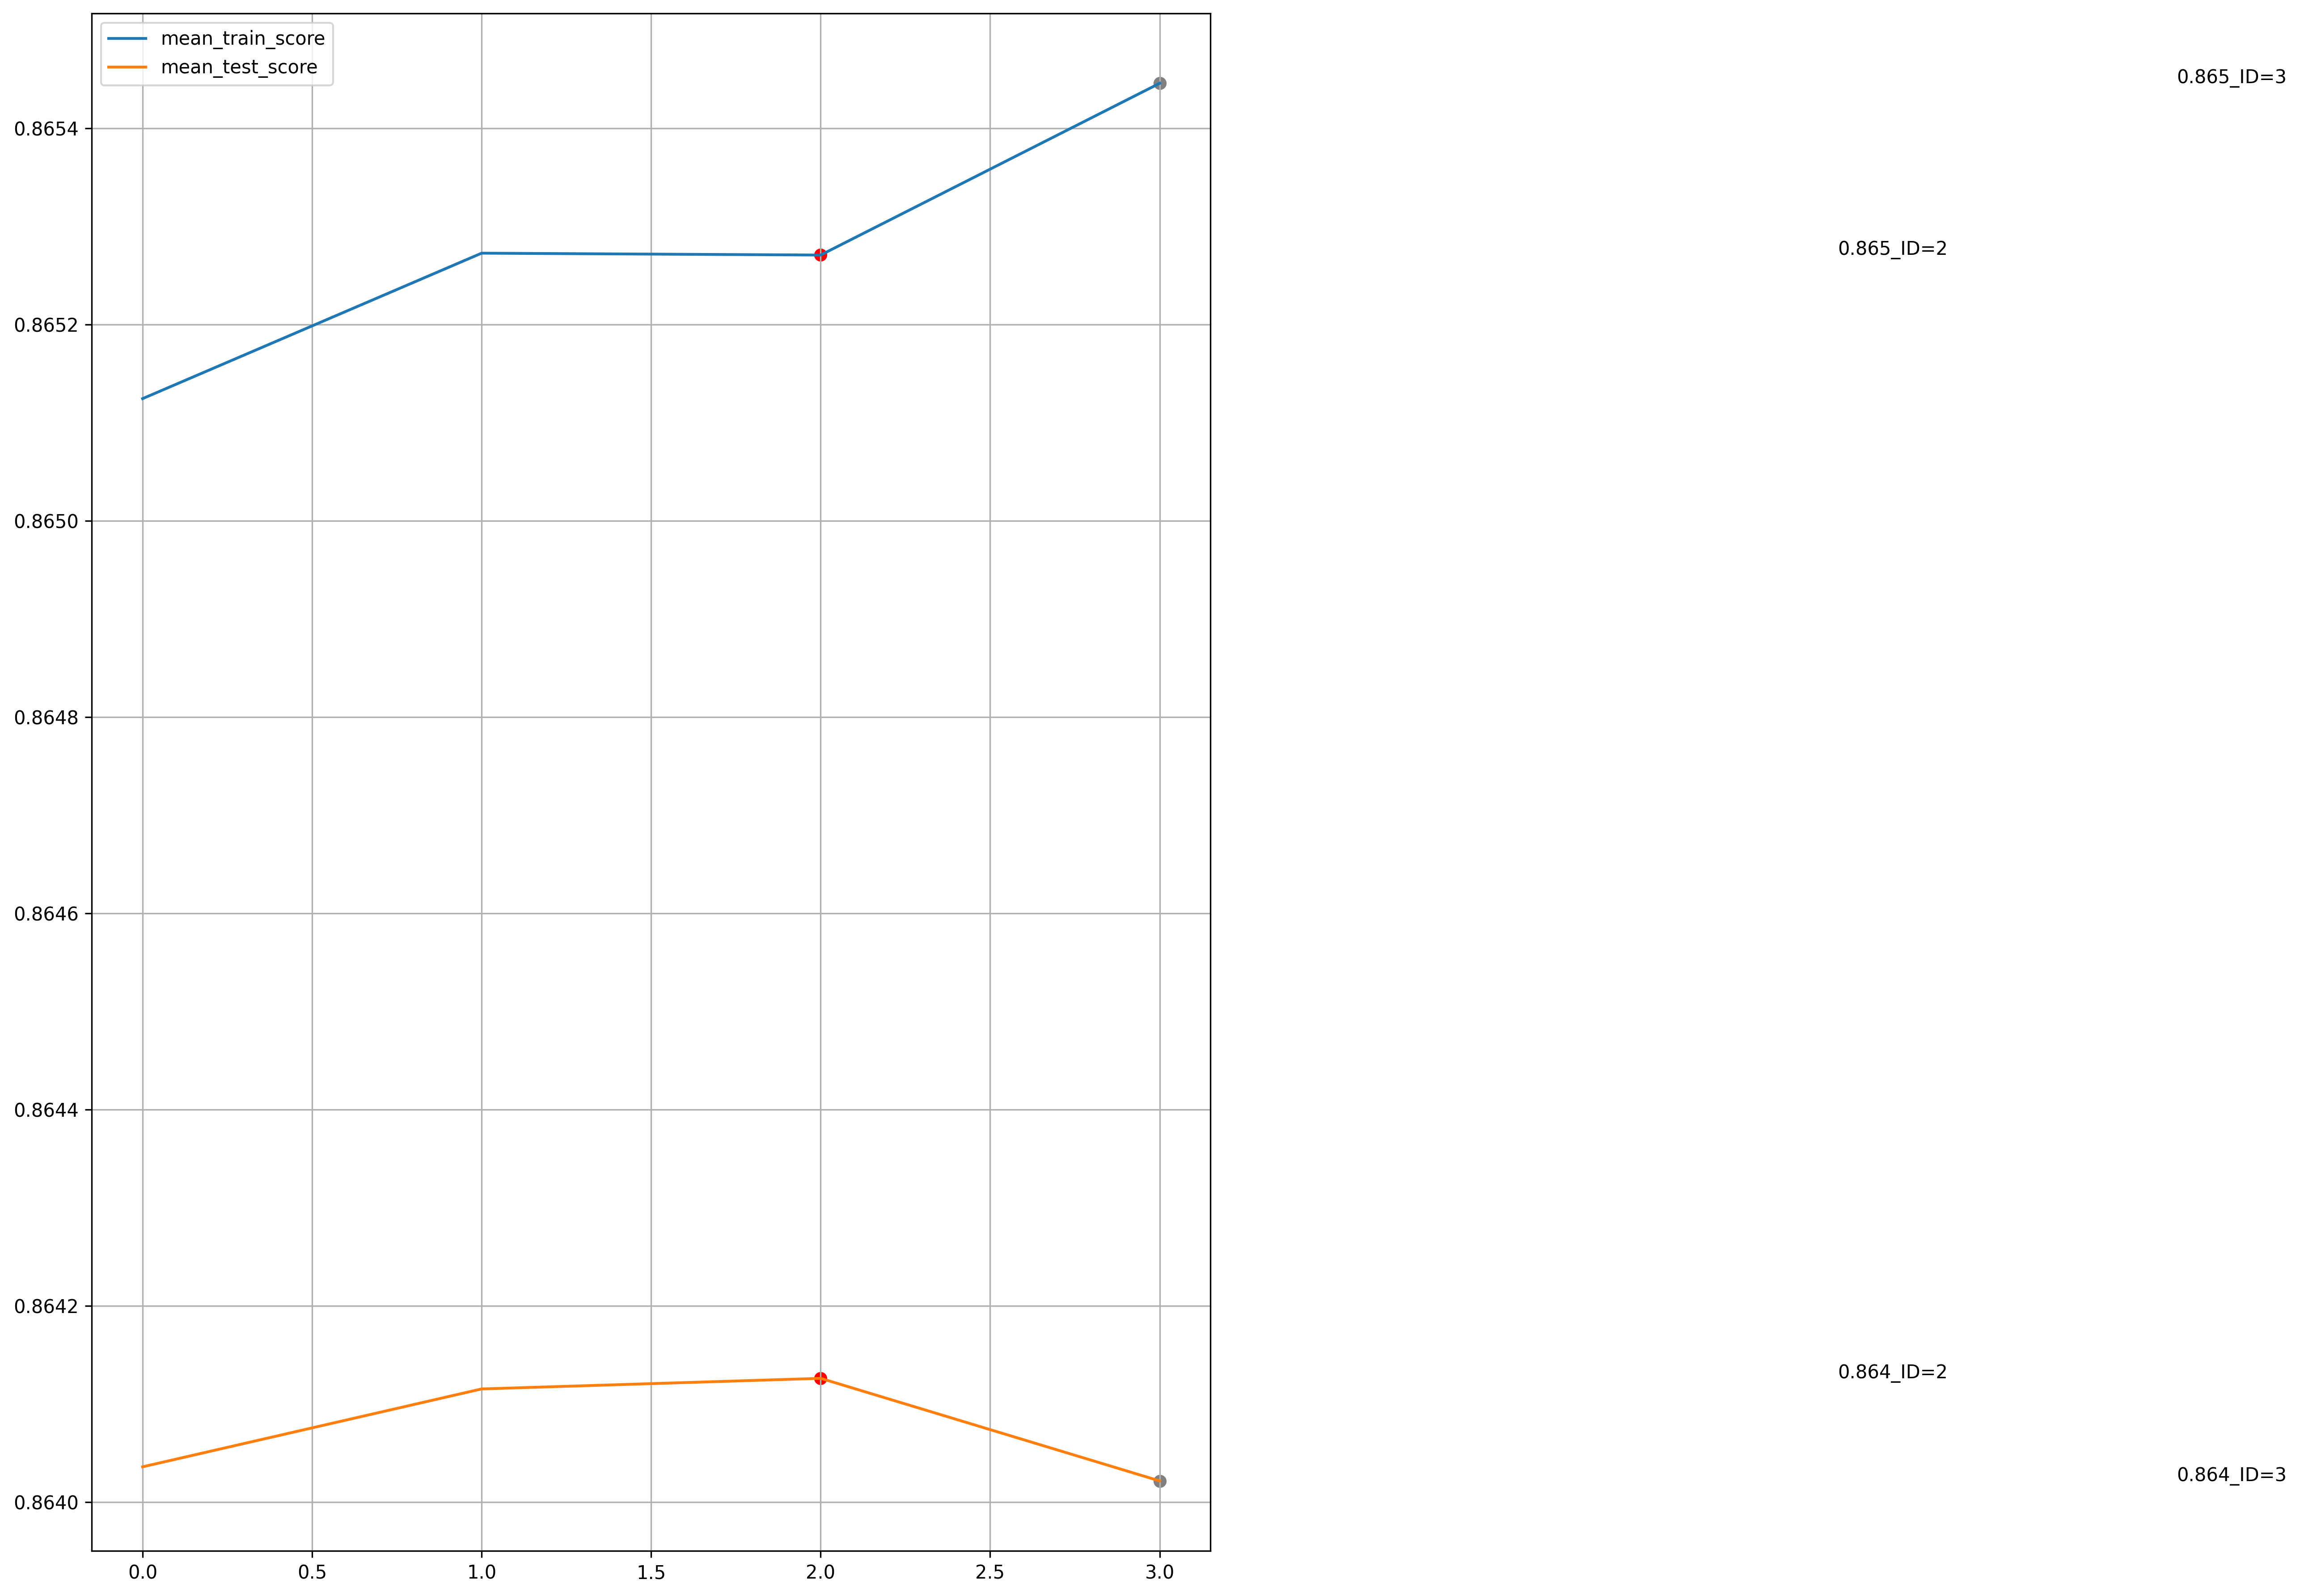

In [27]:
if lr_tuning: 
    DisplayTuningGraph(scores)
    scores
scores

# SVM

# SVM - Training

In [22]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using: ", torch.cuda.get_device_name(device))


import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

import copy

svm_x_train = copy.deepcopy(X_train)
svm_x_test = copy.deepcopy(X_test)

svm_y_train = copy.deepcopy(y_train)
svm_y_test = copy.deepcopy(y_test)


subsample = 1.0  # False for real training on the entire dataset
if subsample < 1.0:
    svm_x_train, _, svm_y_train, _ = train_test_split(
        svm_x_train,
        svm_y_train,
        test_size=1.0 - subsample,
        random_state=42,
        shuffle=True,
        stratify=svm_y_train
    )
    
    # Check the number of samples after subsampling
    print(f"After Subsampling - svm_x_train: {len(svm_x_train)}, svm_y_train: {len(svm_y_train)}")
    
    
    
# PREPROCESSING
# fill nans with 0 in X_train and X_test and y_train and y_test
svm_x_train = svm_x_train.fillna(0)
svm_x_test = svm_x_test.fillna(0)
    
svm_y_train = svm_y_train.fillna(0)
svm_y_test = svm_y_test.fillna(0)
    
# convert x_train to numpy array
svm_x_train = svm_x_train.to_numpy()
svm_x_test = svm_x_test.to_numpy()

svm_y_train = svm_y_train.to_numpy()
svm_y_test = svm_y_test.to_numpy()
    
# Converting False and True to 0 and 1
svm_x_train = np.where(svm_x_train == False, 0, svm_x_train)
svm_x_train = np.where(svm_x_train == True, 1, svm_x_train)
    
svm_x_test = np.where(svm_x_test == False, 0, svm_x_test)
svm_x_test = np.where(svm_x_test == True, 1, svm_x_test)
    
feature_count = svm_x_train.shape[1]
sample_count = svm_x_train.shape[0]

# print number of samples and features
print("Number of features: ", sample_count)
print("Number of samples: ", sample_count)


# Scaling 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# MinMax data scaler
scaler = MinMaxScaler()
svm_x_train = scaler.fit_transform(svm_x_train)
svm_x_test = scaler.transform(svm_x_test)

params = {
    #"class_weight": "balanced",
    "C": 59,
    "gamma": 0.1,
    "kernel": "rbf", # ['rbf', 'linear', 'poly', 'sigmoid']
    "random_state": 7,
    #"shrinking": True
}


model = SVC(**params, verbose=True)
model.fit(svm_x_train, svm_y_train)

Using:  NVIDIA GeForce RTX 3070
After Subsampling - svm_x_train: 21038, svm_y_train: 21038
Number of features:  21038
Number of samples:  21038
[LibSVM]....................*..........*
optimization finished, #iter = 30703
obj = -26854.321606, rho = -1.257979
nSV = 1878, nBSV = 283
Total nSV = 1878


SVC(C=59, gamma=0.1, random_state=7, verbose=True)

# SVM - Validation

TN: 38391 <-- True Negatives
FP: 469 <-- False Positives
FN: 584 <-- False Negatives
TP: 5640 <-- True Positives
FPR:0.01206896551724138 <-- False Positive Rate
TPR:0.9061696658097687 <-- True Positive Rate (same as Recall)
 
              precision    recall  f1-score   support

           0     0.9850    0.9879    0.9865     38860
           1     0.9232    0.9062    0.9146      6224

    accuracy                         0.9766     45084
   macro avg     0.9541    0.9471    0.9505     45084
weighted avg     0.9765    0.9766    0.9766     45084



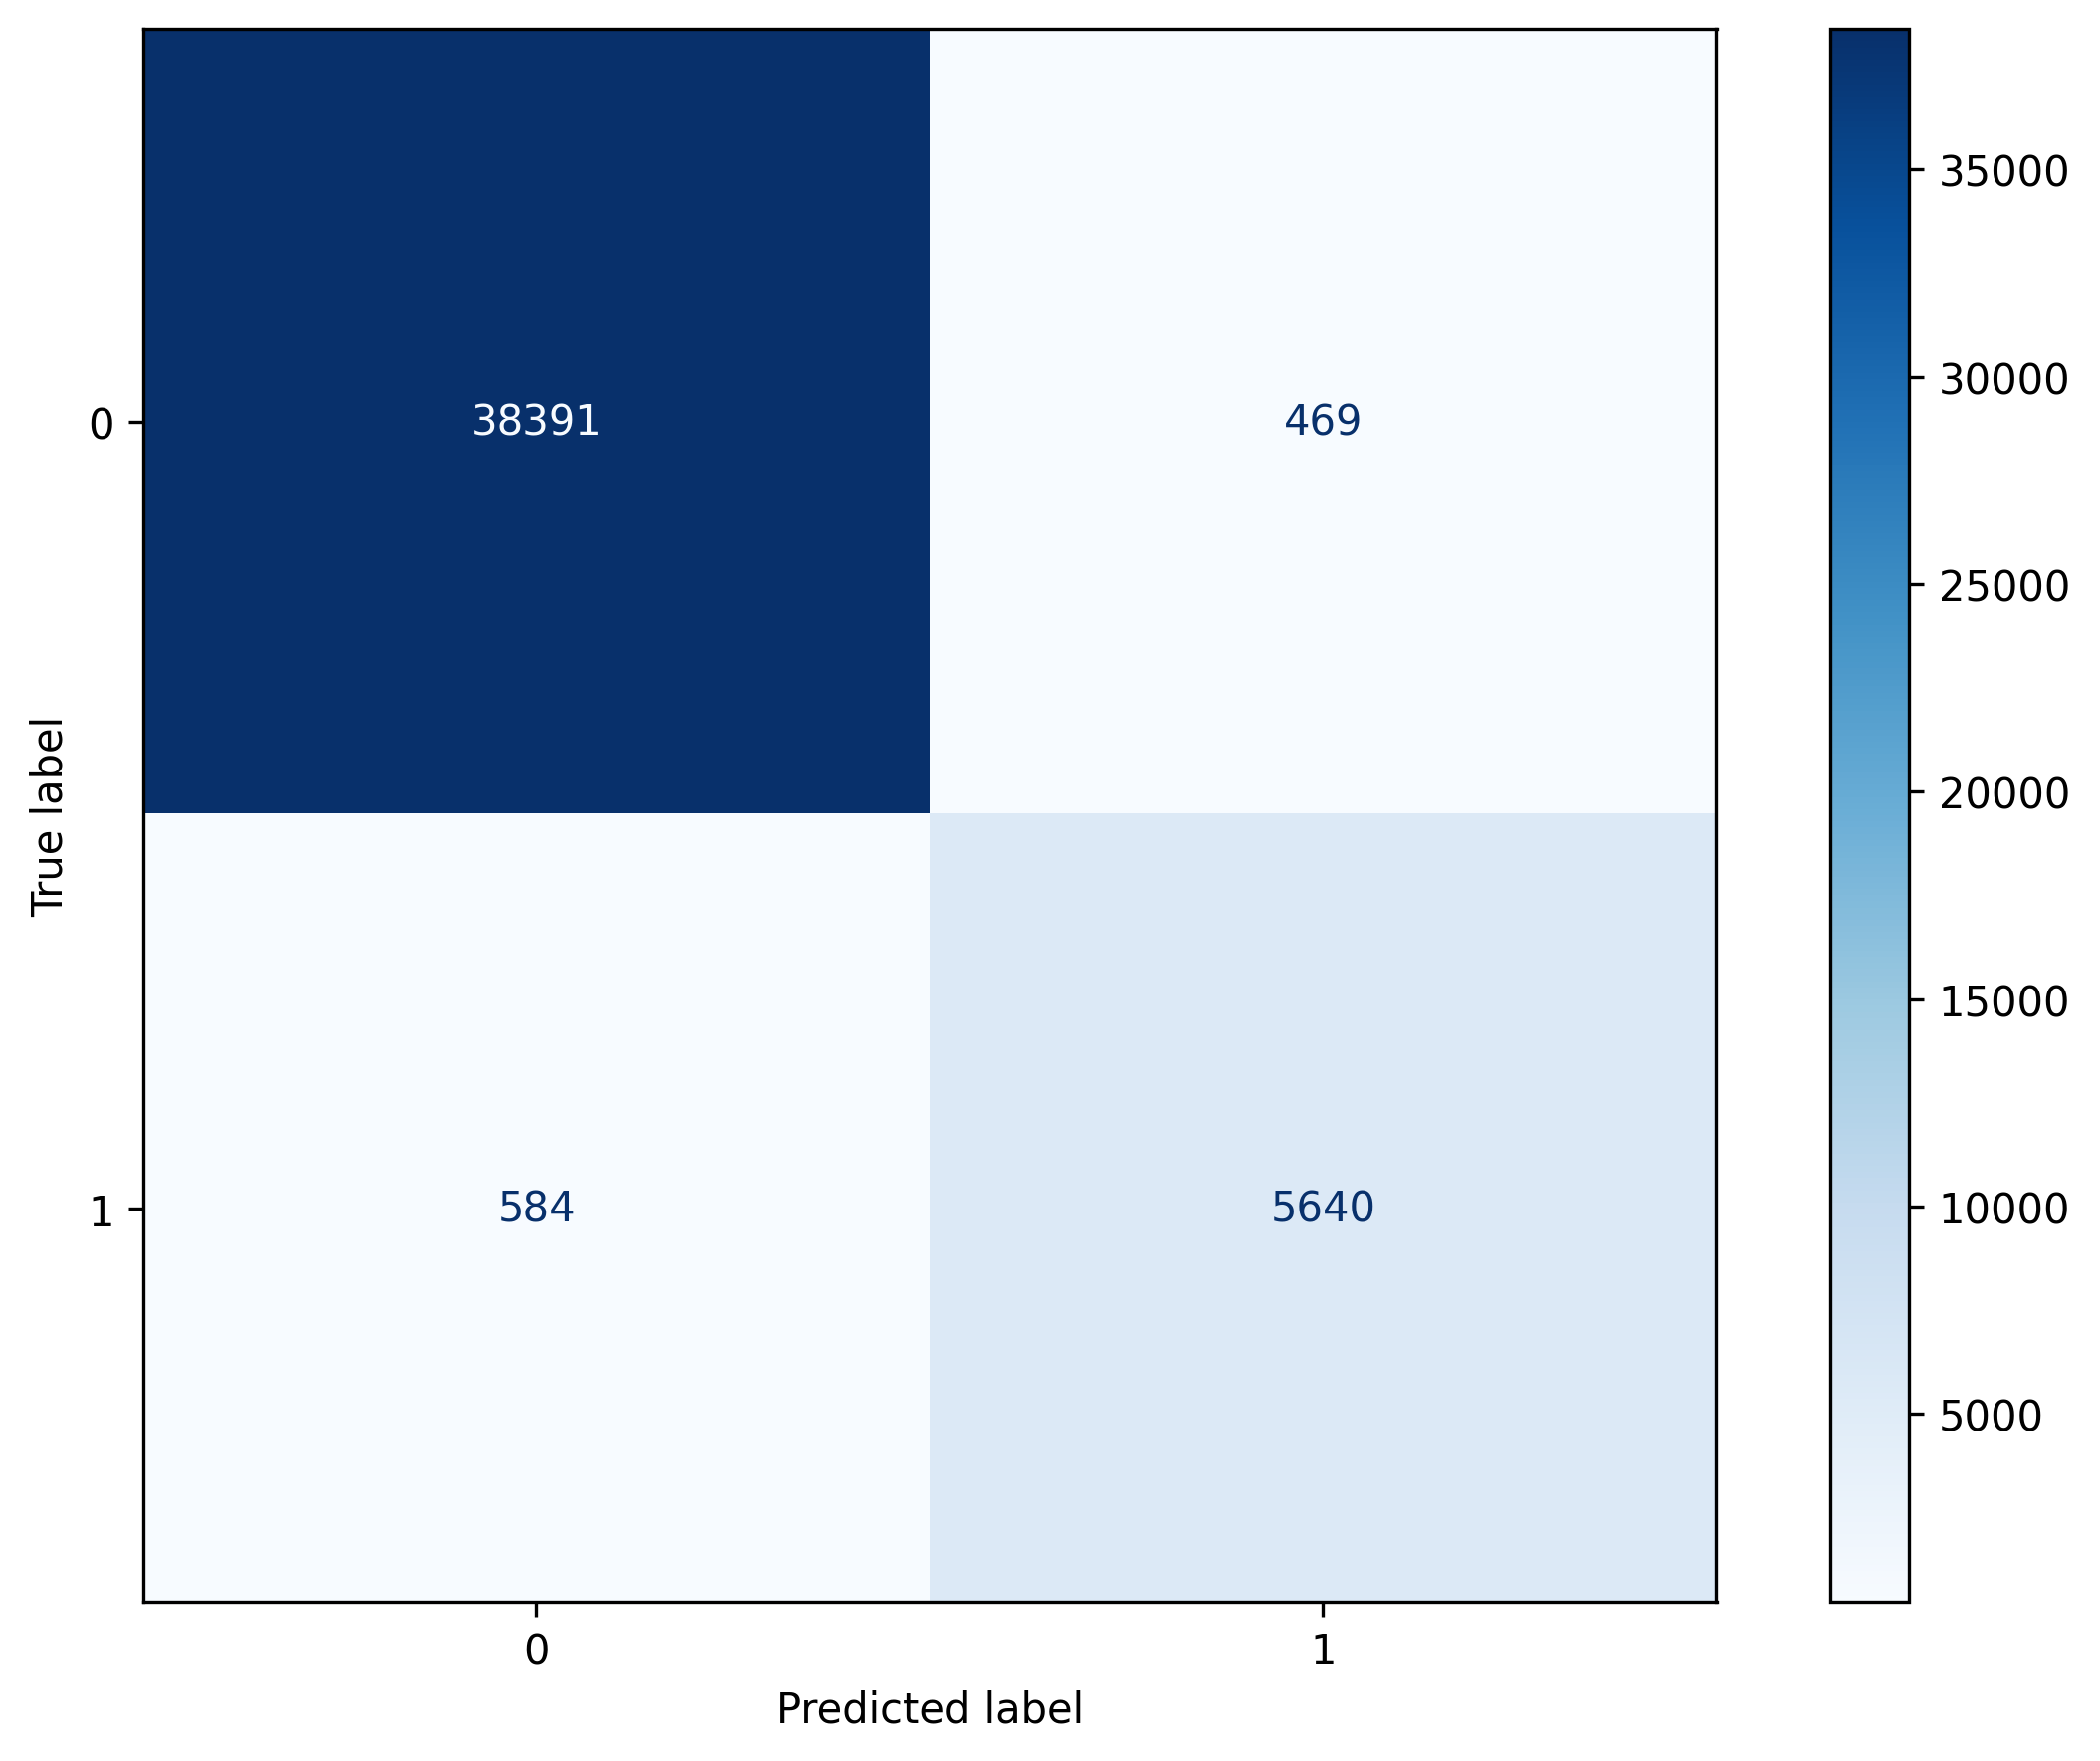

In [23]:
ValidateModel(svm_x_test, svm_y_test, model)

# SVM - Tuning

In [ ]:
svm_tuning = False

import warnings
# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

if svm_tuning:
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    from sklearn.svm import SVC
    from sklearn.preprocessing import MinMaxScaler

    # Assuming df is your DataFrame and class_map maps your classes
    #labels = df['label'].apply(lambda x: class_map[x])
    #features = df.drop('label', axis=1).copy()

    # Split the dataset
    #X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

    
    import copy

    svm_x_train = copy.deepcopy(X_train)
    svm_x_test = copy.deepcopy(X_test)

    svm_y_train = copy.deepcopy(y_train)
    svm_y_test = copy.deepcopy(y_test)

    
    #############################
    # SUBSAMPLE FOR GRID SEARCH #
    #############################
    subsample = 1.0
    if subsample < 1.0:
        svm_x_train, _, svm_y_train, _ = train_test_split(
            X_train,
            y_train,
            test_size=1.0 - subsample,
            random_state=42,
            shuffle=True,
            stratify=y_train
        )

    # Preprocessing: Fill NaNs and scale features
    svm_x_train = svm_x_train.fillna(0)
    #svm_X_test = svm_X_test.fillna(0)
    scaler = MinMaxScaler()
    svm_x_train = scaler.fit_transform(svm_x_train)
    #svm_X_test = scaler.transform(svm_X_test)

    # SVM base model
    svm = SVC(random_state=7)

    # Grid of parameters to search
    grid = {
        "C": [58, 59, 60],  # Regularization parameter
        #"gamma": ["scale", "auto"],  # Kernel coefficient
        "gamma": [0.09, 0.1, 0.11],
        "kernel": ["rbf"], #['rbf', 'linear', 'poly', 'sigmoid']
        #"shrinking": [True, False]
    }

    # Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

    # Grid Search
    grid_search = GridSearchCV(
        estimator=svm,
        param_grid=grid,
        cv=cv,
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(svm_x_train, svm_y_train)

    # Best estimator
    best_svm = grid_search.best_estimator_

    # Results
    scores = pd.DataFrame(grid_search.cv_results_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .......C=58, gamma=0.09, kernel=rbf, shrinking=True; total time=19.8min
[CV] END .......C=58, gamma=0.09, kernel=rbf, shrinking=True; total time=18.2min
[CV] END .......C=58, gamma=0.09, kernel=rbf, shrinking=True; total time=17.8min
[CV] END .....C=58, gamma=0.09, kernel=rbf, shrinking=False; total time=114.8min
[CV] END .....C=58, gamma=0.09, kernel=rbf, shrinking=False; total time=112.2min
[CV] END .....C=58, gamma=0.09, kernel=rbf, shrinking=False; total time=113.3min
[CV] END ........C=58, gamma=0.1, kernel=rbf, shrinking=True; total time=19.2min
[CV] END ........C=58, gamma=0.1, kernel=rbf, shrinking=True; total time=18.0min
[CV] END ........C=58, gamma=0.1, kernel=rbf, shrinking=True; total time=18.2min
[CV] END ......C=58, gamma=0.1, kernel=rbf, shrinking=False; total time=114.2min
[CV] END ......C=58, gamma=0.1, kernel=rbf, shrinking=False; total time=113.5min
[CV] END ......C=58, gamma=0.1, kernel=rbf, shri

In [ ]:
if svm_tuning:
    DisplayTuningGraph(scores)

scores

# Decision Tree

## Decision Tree - Training

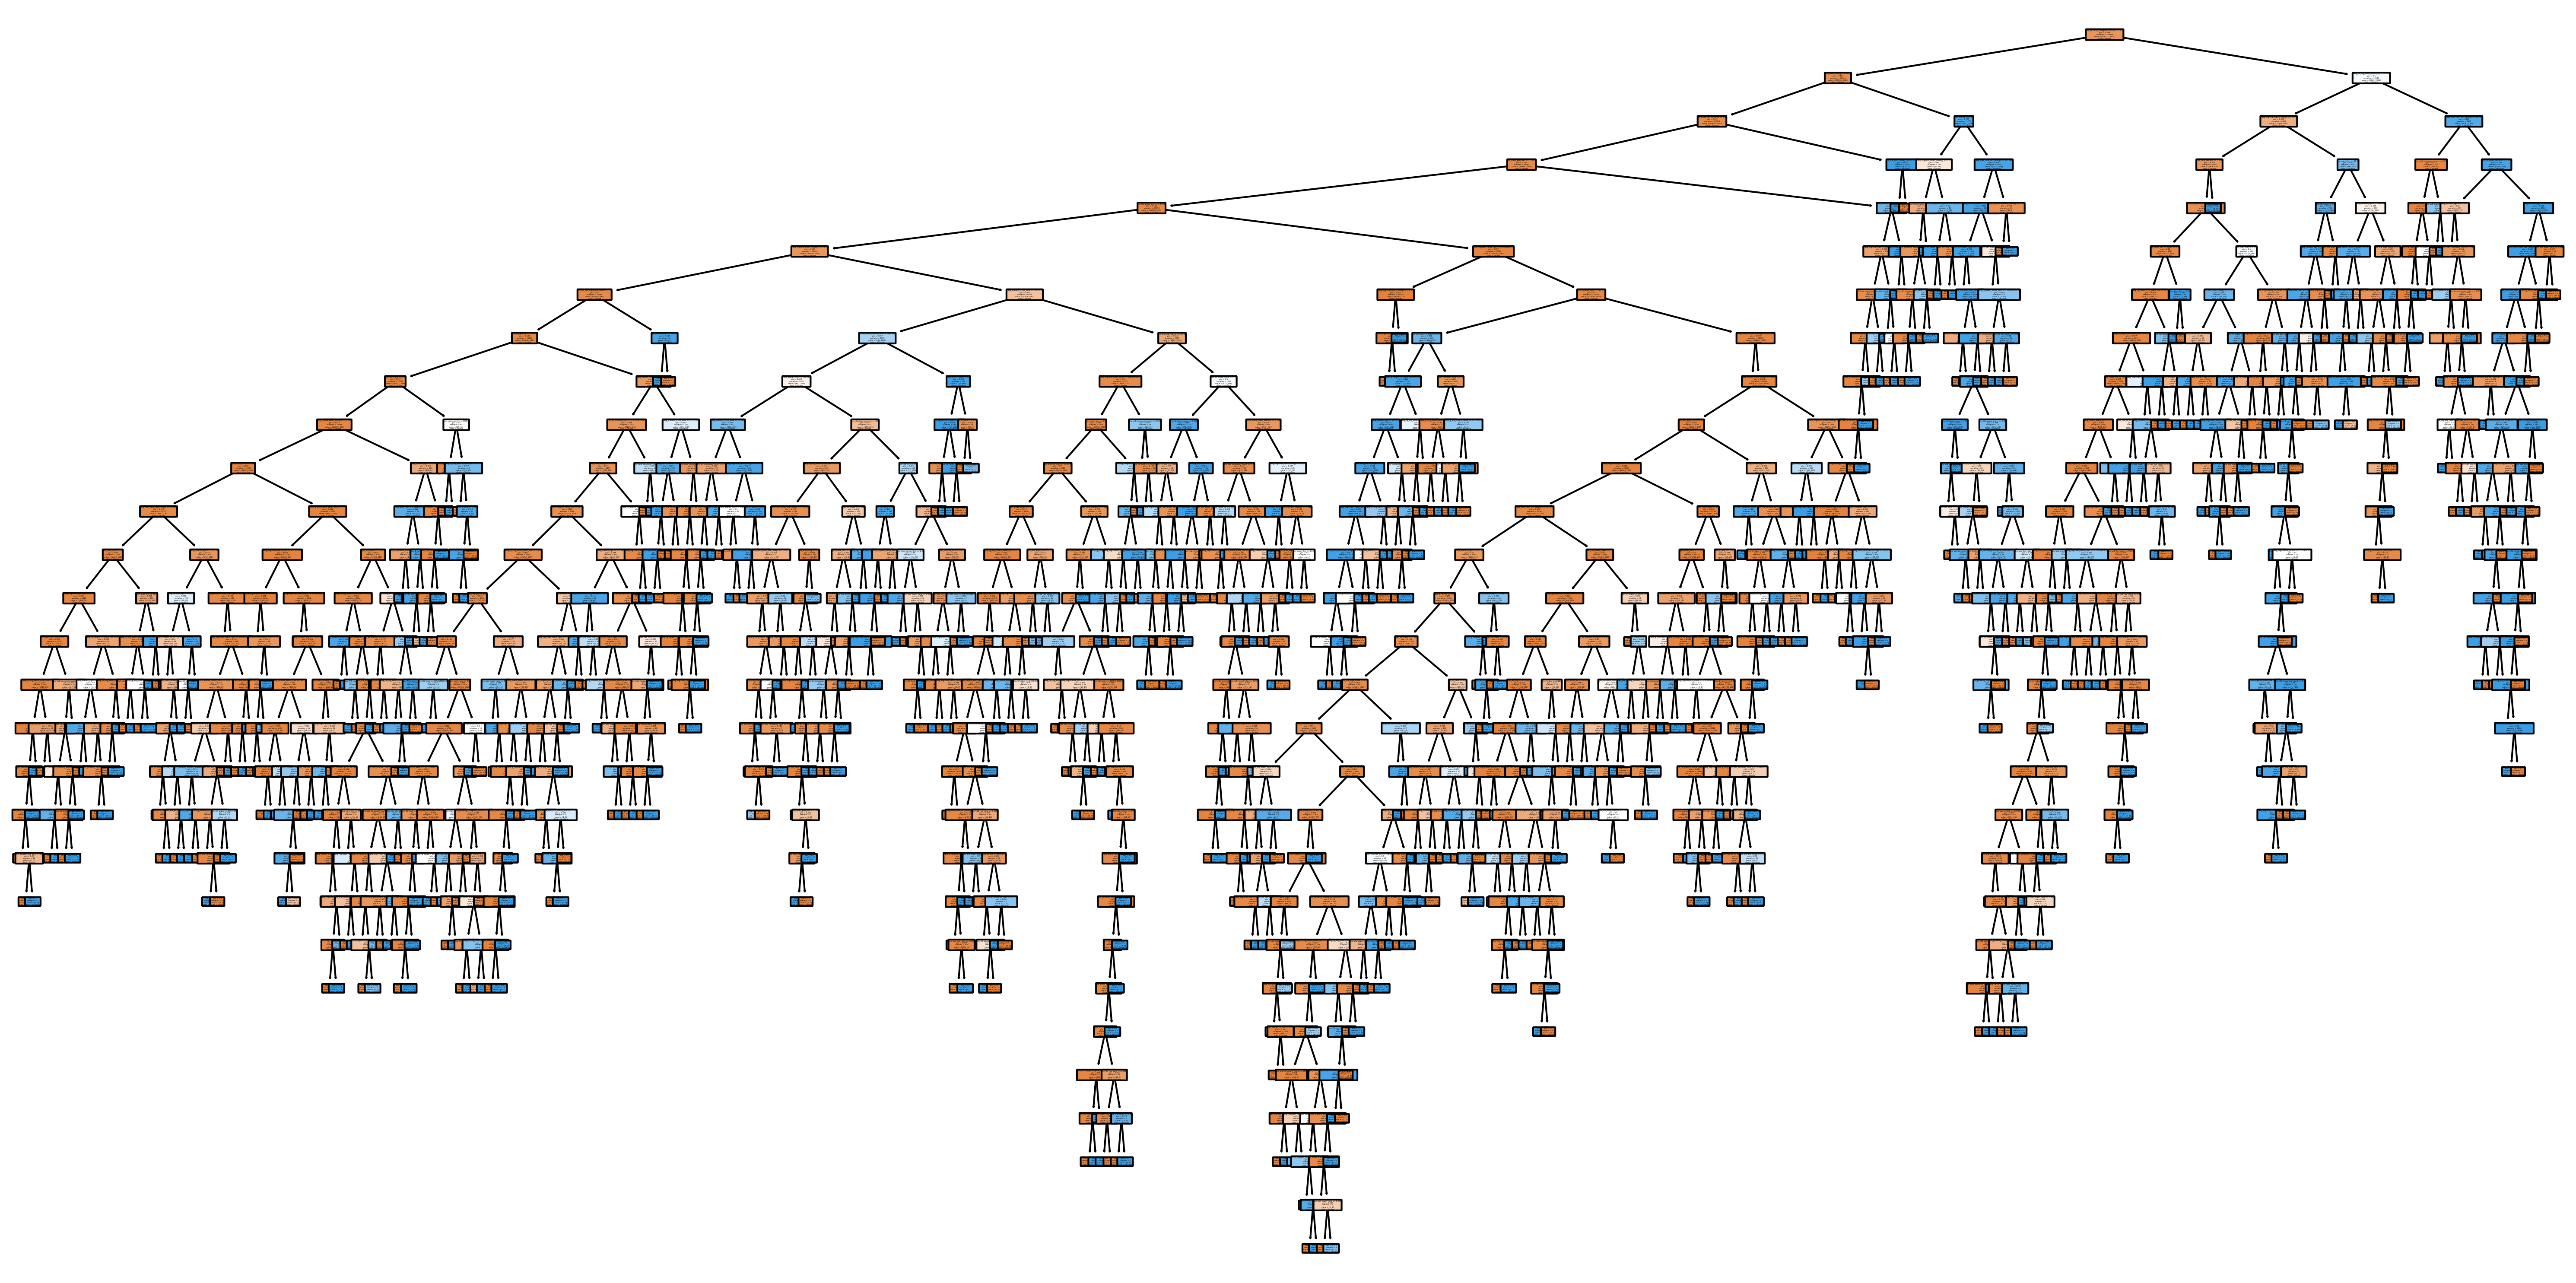

<Figure size 2400x1800 with 0 Axes>

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

params = {
    "max_depth": 30,
    "max_leaf_nodes": 803,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "random_state": 7
}

model = DecisionTreeClassifier(**params)
model.fit(X_train, y_train)


from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# To visualize the trained Decision Tree
plt.figure(figsize=(20, 10))  # Set the figure size, you may need to adjust this to fit the tree
plot_tree(model, filled=True, feature_names=X_train.columns, class_names=['benign', 'phishing'], rounded=True)
plt.show()

plt.savefig('decision_tree.pdf', format='pdf', bbox_inches='tight')  # Save the plot to a PDF file

## Decision Tree - Validation

TN: 38434 <-- True Negatives
FP: 426 <-- False Positives
FN: 621 <-- False Negatives
TP: 5603 <-- True Positives
FPR:0.010962429233144621 <-- False Positive Rate
TPR:0.9002249357326478 <-- True Positive Rate (same as Recall)
 
              precision    recall  f1-score   support

           0     0.9841    0.9890    0.9866     38860
           1     0.9293    0.9002    0.9146      6224

    accuracy                         0.9768     45084
   macro avg     0.9567    0.9446    0.9506     45084
weighted avg     0.9765    0.9768    0.9766     45084



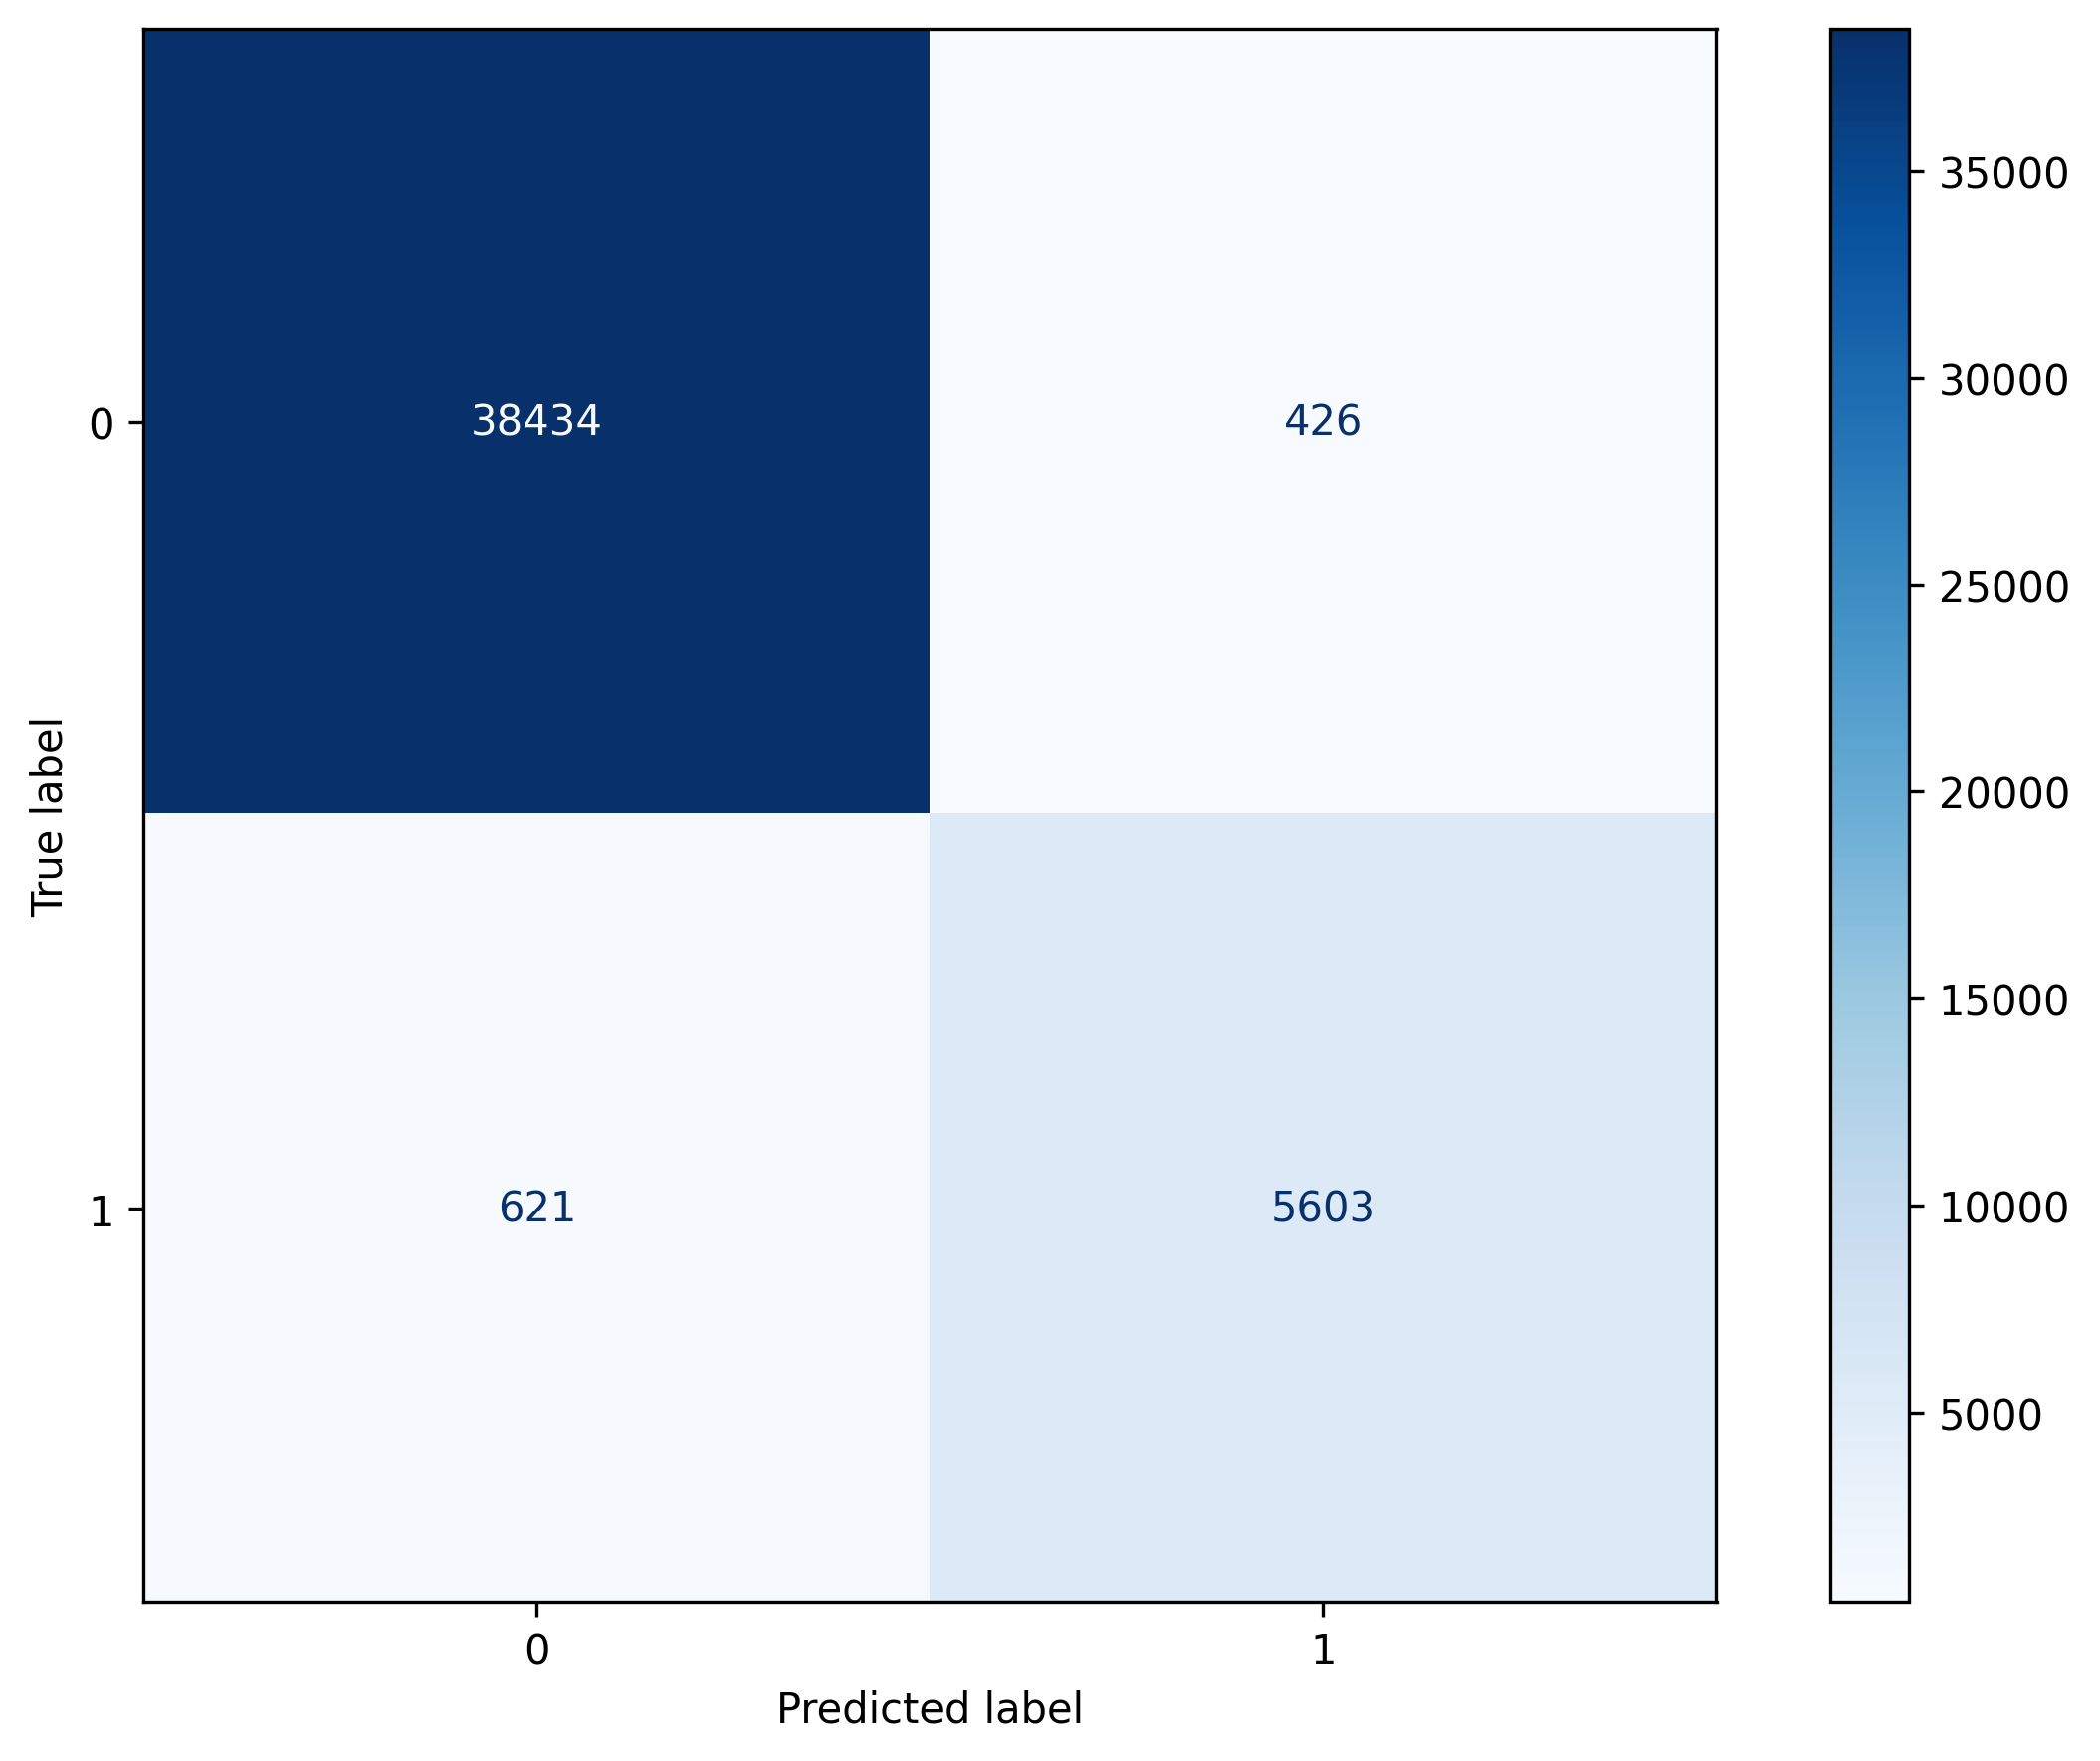

In [25]:
ValidateModel(X_test, y_test, model)

## Decision Tree - Tuning

In [26]:
dt_tuning = False

if dt_tuning:

    import pandas as pd
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    from sklearn.tree import DecisionTreeClassifier

    # Assuming df is your DataFrame and class_map maps your classes
    #labels = df['label'].apply(lambda x: class_map[x])
    #features = df.drop('label', axis=1).copy()

    # Split the dataset
    #X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

    # Fixed parameters
    params = {
        "max_depth": 30, # Maximum depth of the tree
        "min_samples_leaf": 1, # Minimum number of samples required to be at a leaf node
        "max_leaf_nodes": 803, # Maximum number of leaf nodes
    }
    
    # Decision Tree base model
    dt = DecisionTreeClassifier(**params, random_state=7)

    # Grid of parameters to search
    grid = {
        'min_samples_split': [5,6,7],  # Minimum number of samples required to split an internal node
    }

    # Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

    # Grid Search
    grid_search = GridSearchCV(
        estimator=dt,
        param_grid=grid,
        cv=cv,
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    # Best estimator
    best_dt = grid_search.best_estimator_

    # Results
    scores = pd.DataFrame(grid_search.cv_results_)


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       6.929393      0.188401         0.028412        0.000104   
1       6.906136      0.213907         0.028341        0.000105   
2       6.921084      0.197799         0.028450        0.000211   
3       6.908233      0.207246         0.028353        0.000187   
4       6.921447      0.199538         0.028384        0.000120   
5       6.919840      0.202296         0.028371        0.000139   
6       6.926538      0.205010         0.028810        0.000934   
7       6.920783      0.204862         0.028324        0.000105   

  param_max_depth param_max_leaf_nodes param_min_samples_leaf  \
0              30                  801                      1   
1              30                  801                      1   
2              30                  802                      1   
3              30                  802                      1   
4              30                  803                      1   
5     

/tmp/ipykernel_1072040/2406135756.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = means_df[col_name][max_ids[i]]
/tmp/ipykernel_1072040/2406135756.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  id = max_ids[i]
/tmp/ipykernel_1072040/2406135756.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       6.929393      0.188401         0.028412        0.000104   
1       6.906136      0.213907         0.028341        0.000105   
2       6.921084      0.197799         0.028450        0.000211   
3       6.908233      0.207246         0.028353        0.000187   
4       6.921447      0.199538         0.028384        0.000120   
5       6.919840      0.202296         0.028371        0.000139   
6       6.926538      0.205010         0.028810        0.000934   
7       6.920783      0.204862         0.028324        0.000105   

  param_max_depth param_max_leaf_nodes param_min_samples_leaf  \
0              30                  801                      1   
1              30                  801                      1   
2              30                  802                      1   
3              30                  802                      1   
4              30                  803                      1   
5              30                  803                      1   
6              30                  804                      1   
7              30                  804                      1   

  param_min_samples_split                                             params  \
0                       4  {'max_depth': 30, 'max_leaf_nodes': 801, 'min_...   
1                       5  {'max_depth': 30, 'max_leaf_nodes': 801, 'min_...   
2                       4  {'max_depth': 30, 'max_leaf_nodes': 802, 'min_...   
3                       5  {'max_depth': 30, 'max_leaf_nodes': 802, 'min_...   
4                       4  {'max_depth': 30, 'max_leaf_nodes': 803, 'min_...   
5                       5  {'max_depth': 30, 'max_leaf_nodes': 803, 'min_...   
6                       4  {'max_depth': 30, 'max_leaf_nodes': 804, 'min_...   
7                       5  {'max_depth': 30, 'max_leaf_nodes': 804, 'min_...   

   split0_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0           0.947413  ...         0.949120        0.001518                8   
1           0.947357  ...         0.949142        0.001483                7   
2           0.947469  ...         0.949144        0.001465                6   
3           0.947357  ...         0.949177        0.001481                3   
4           0.947469  ...         0.949155        0.001453                5   
5           0.947357  ...         0.949198        0.001483                1   
6           0.947469  ...         0.949167        0.001446                4   
7           0.947357  ...         0.949178        0.001436                2   

   split0_train_score  split1_train_score  split2_train_score  \
0            0.969781            0.969678            0.969875   
1            0.969724            0.969678            0.969835   
2            0.969795            0.969705            0.969889   
3            0.969739            0.969705            0.969877   
4            0.969795            0.969731            0.969889   
5            0.969753            0.969731            0.969889   
6            0.969823            0.969742            0.969931   
7            0.969753            0.969742            0.969903   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0            0.971178            0.970798          0.970262         0.000608  
1            0.971191            0.970798          0.970245         0.000627  
2            0.971178            0.970881          0.970290         0.000614  
3            0.971203            0.970881          0.970281         0.000632  
4            0.971178            0.970908          0.970300         0.000614  
5            0.971203            0.970908          0.970297         0.000629  
6            0.971178            0.970923          0.970319         0.000605  
7            0.971203            0.970923          0.970305         0.000628  

[8 rows x 24 columns]

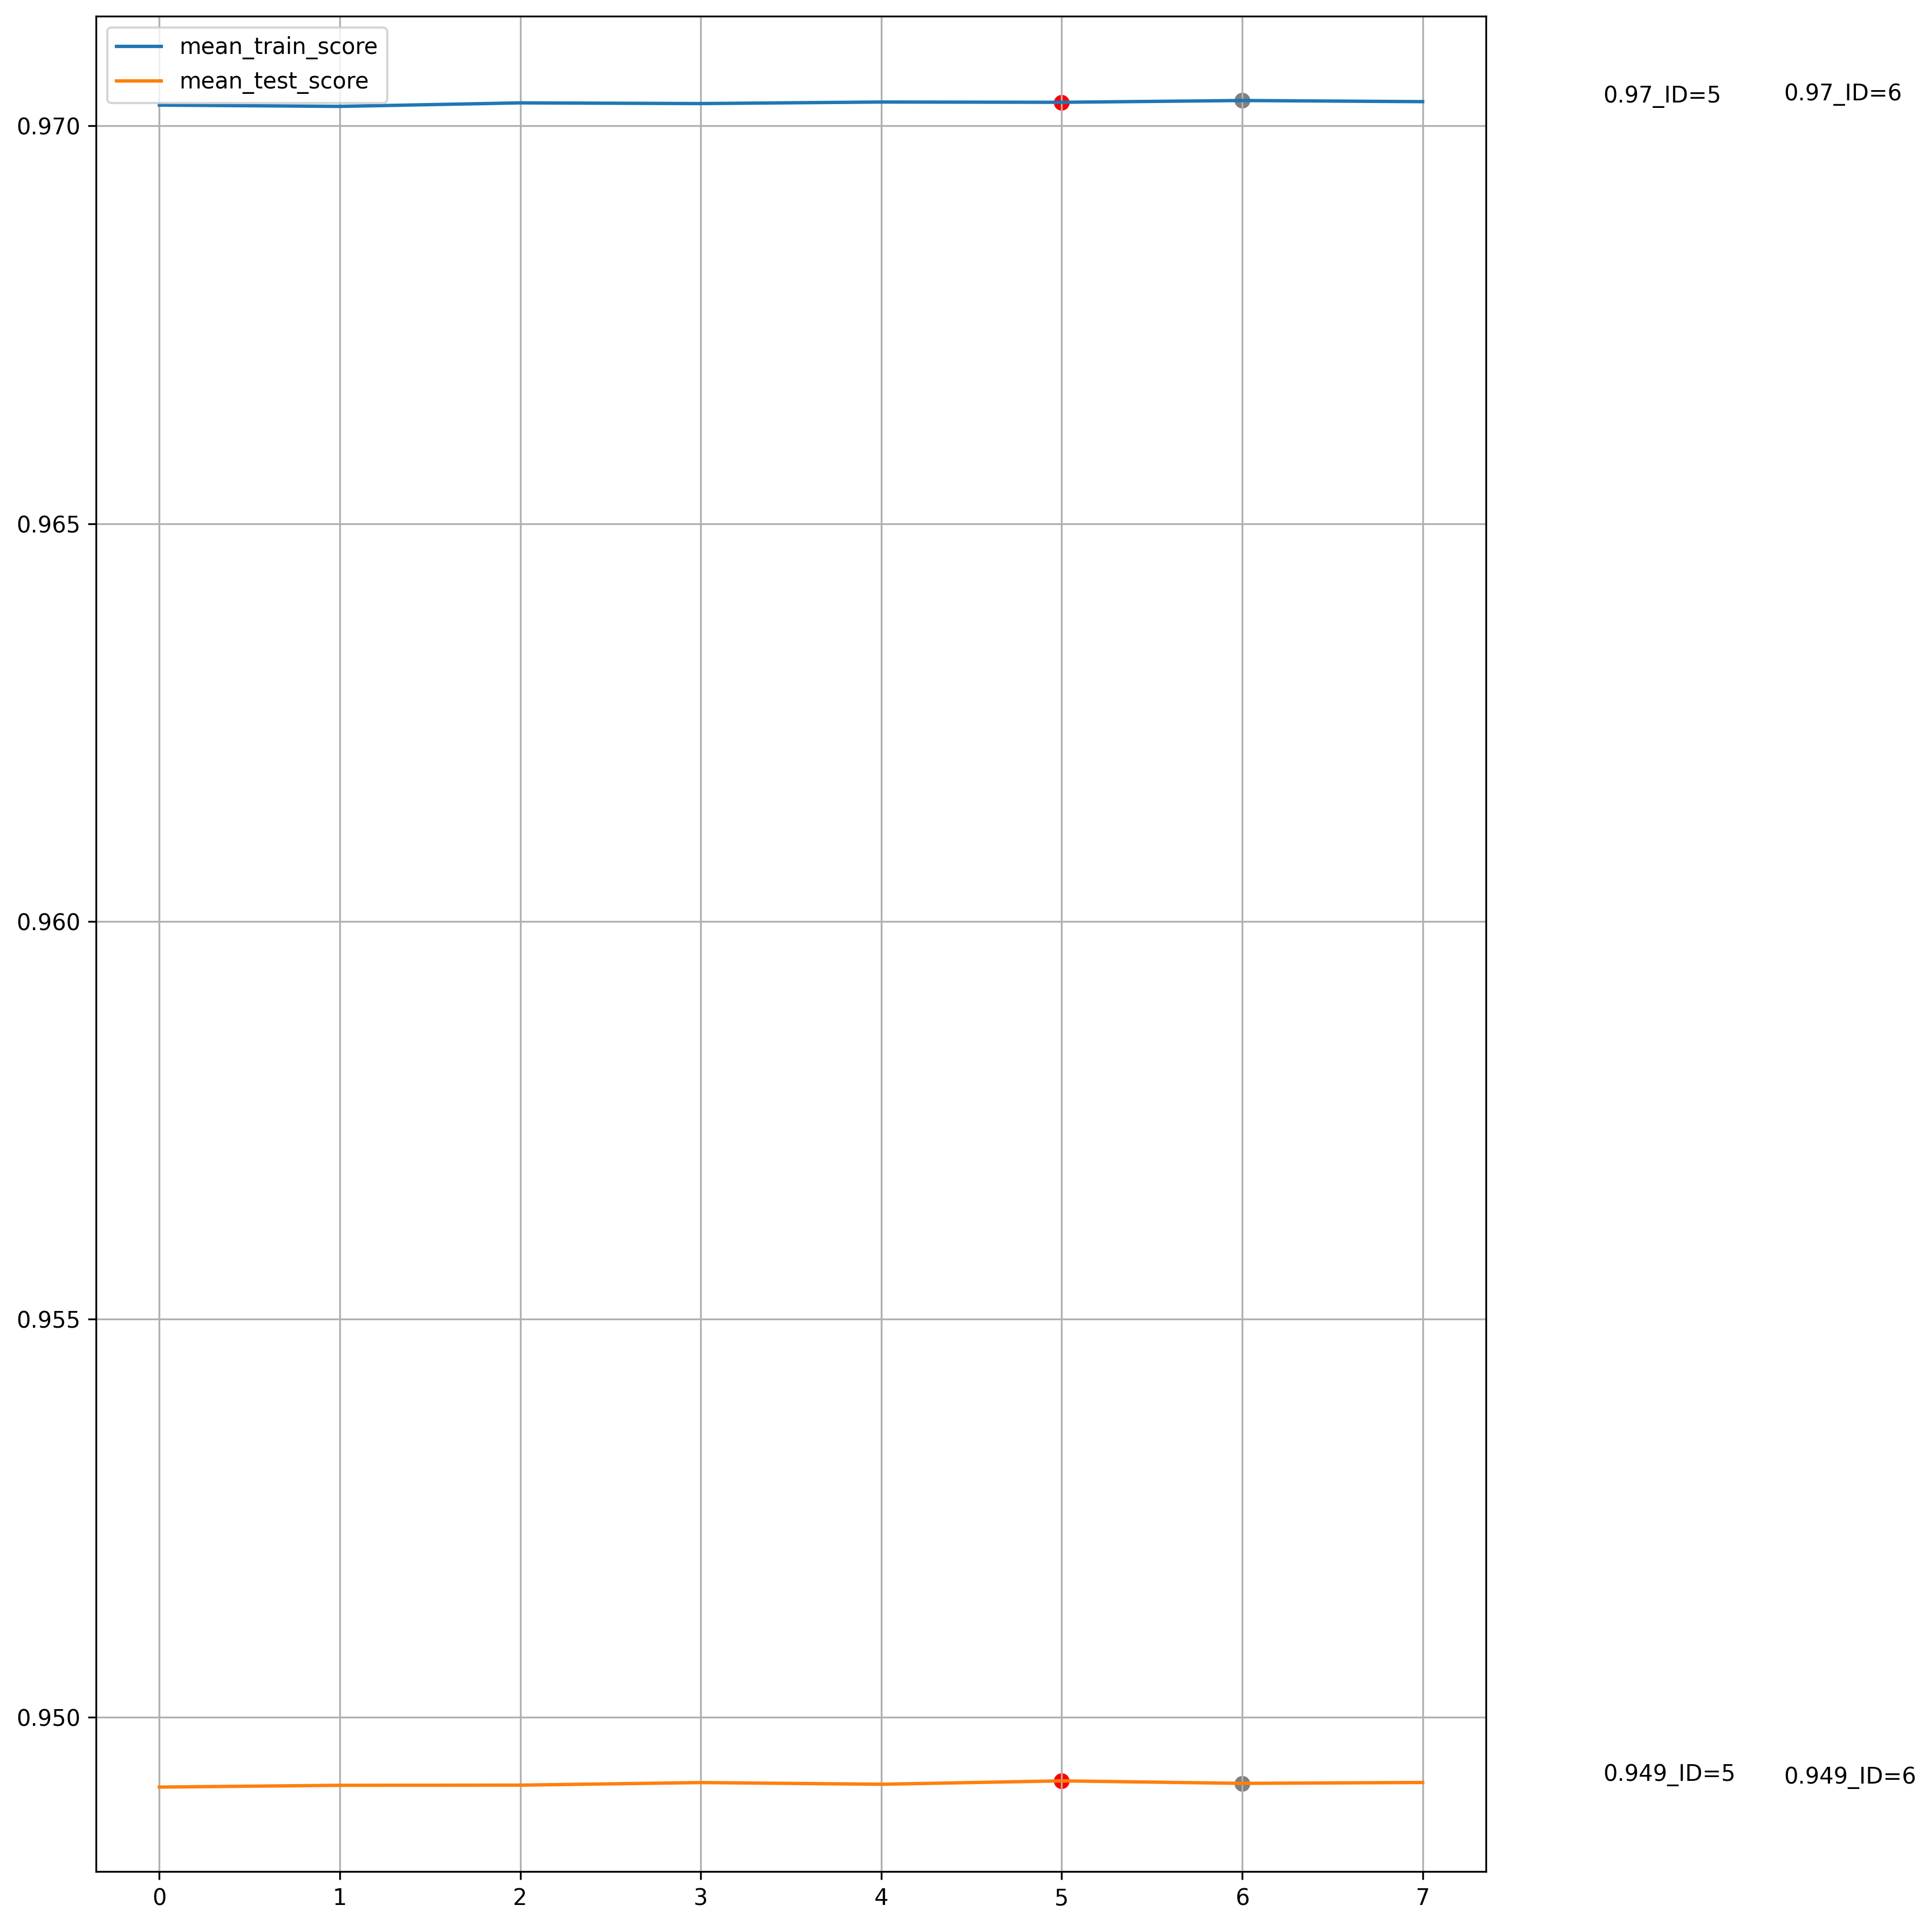

In [84]:
if dt_tuning:
    DisplayTuningGraph(scores)

scores

# Random Forest

## Random Forest - Training

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Random Forest parameters
params = {
    "n_estimators": 143,
    "criterion": 'entropy',
    "max_depth": 19,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_leaf_nodes": 174,
    
    "random_state":7
}
model = RandomForestClassifier(**params)


# at last, train the model
_ = model.fit(X_train, y_train)





## Random Forest - Validation

              precision    recall  f1-score   support

           0     0.9779    0.9974    0.9875     25947
           1     0.9811    0.8574    0.9151      4109

    accuracy                         0.9782     30056
   macro avg     0.9795    0.9274    0.9513     30056
weighted avg     0.9783    0.9782    0.9776     30056

Confusion Matrix:
TN: 25879 FP: 68 FN: 586 TP: 3523


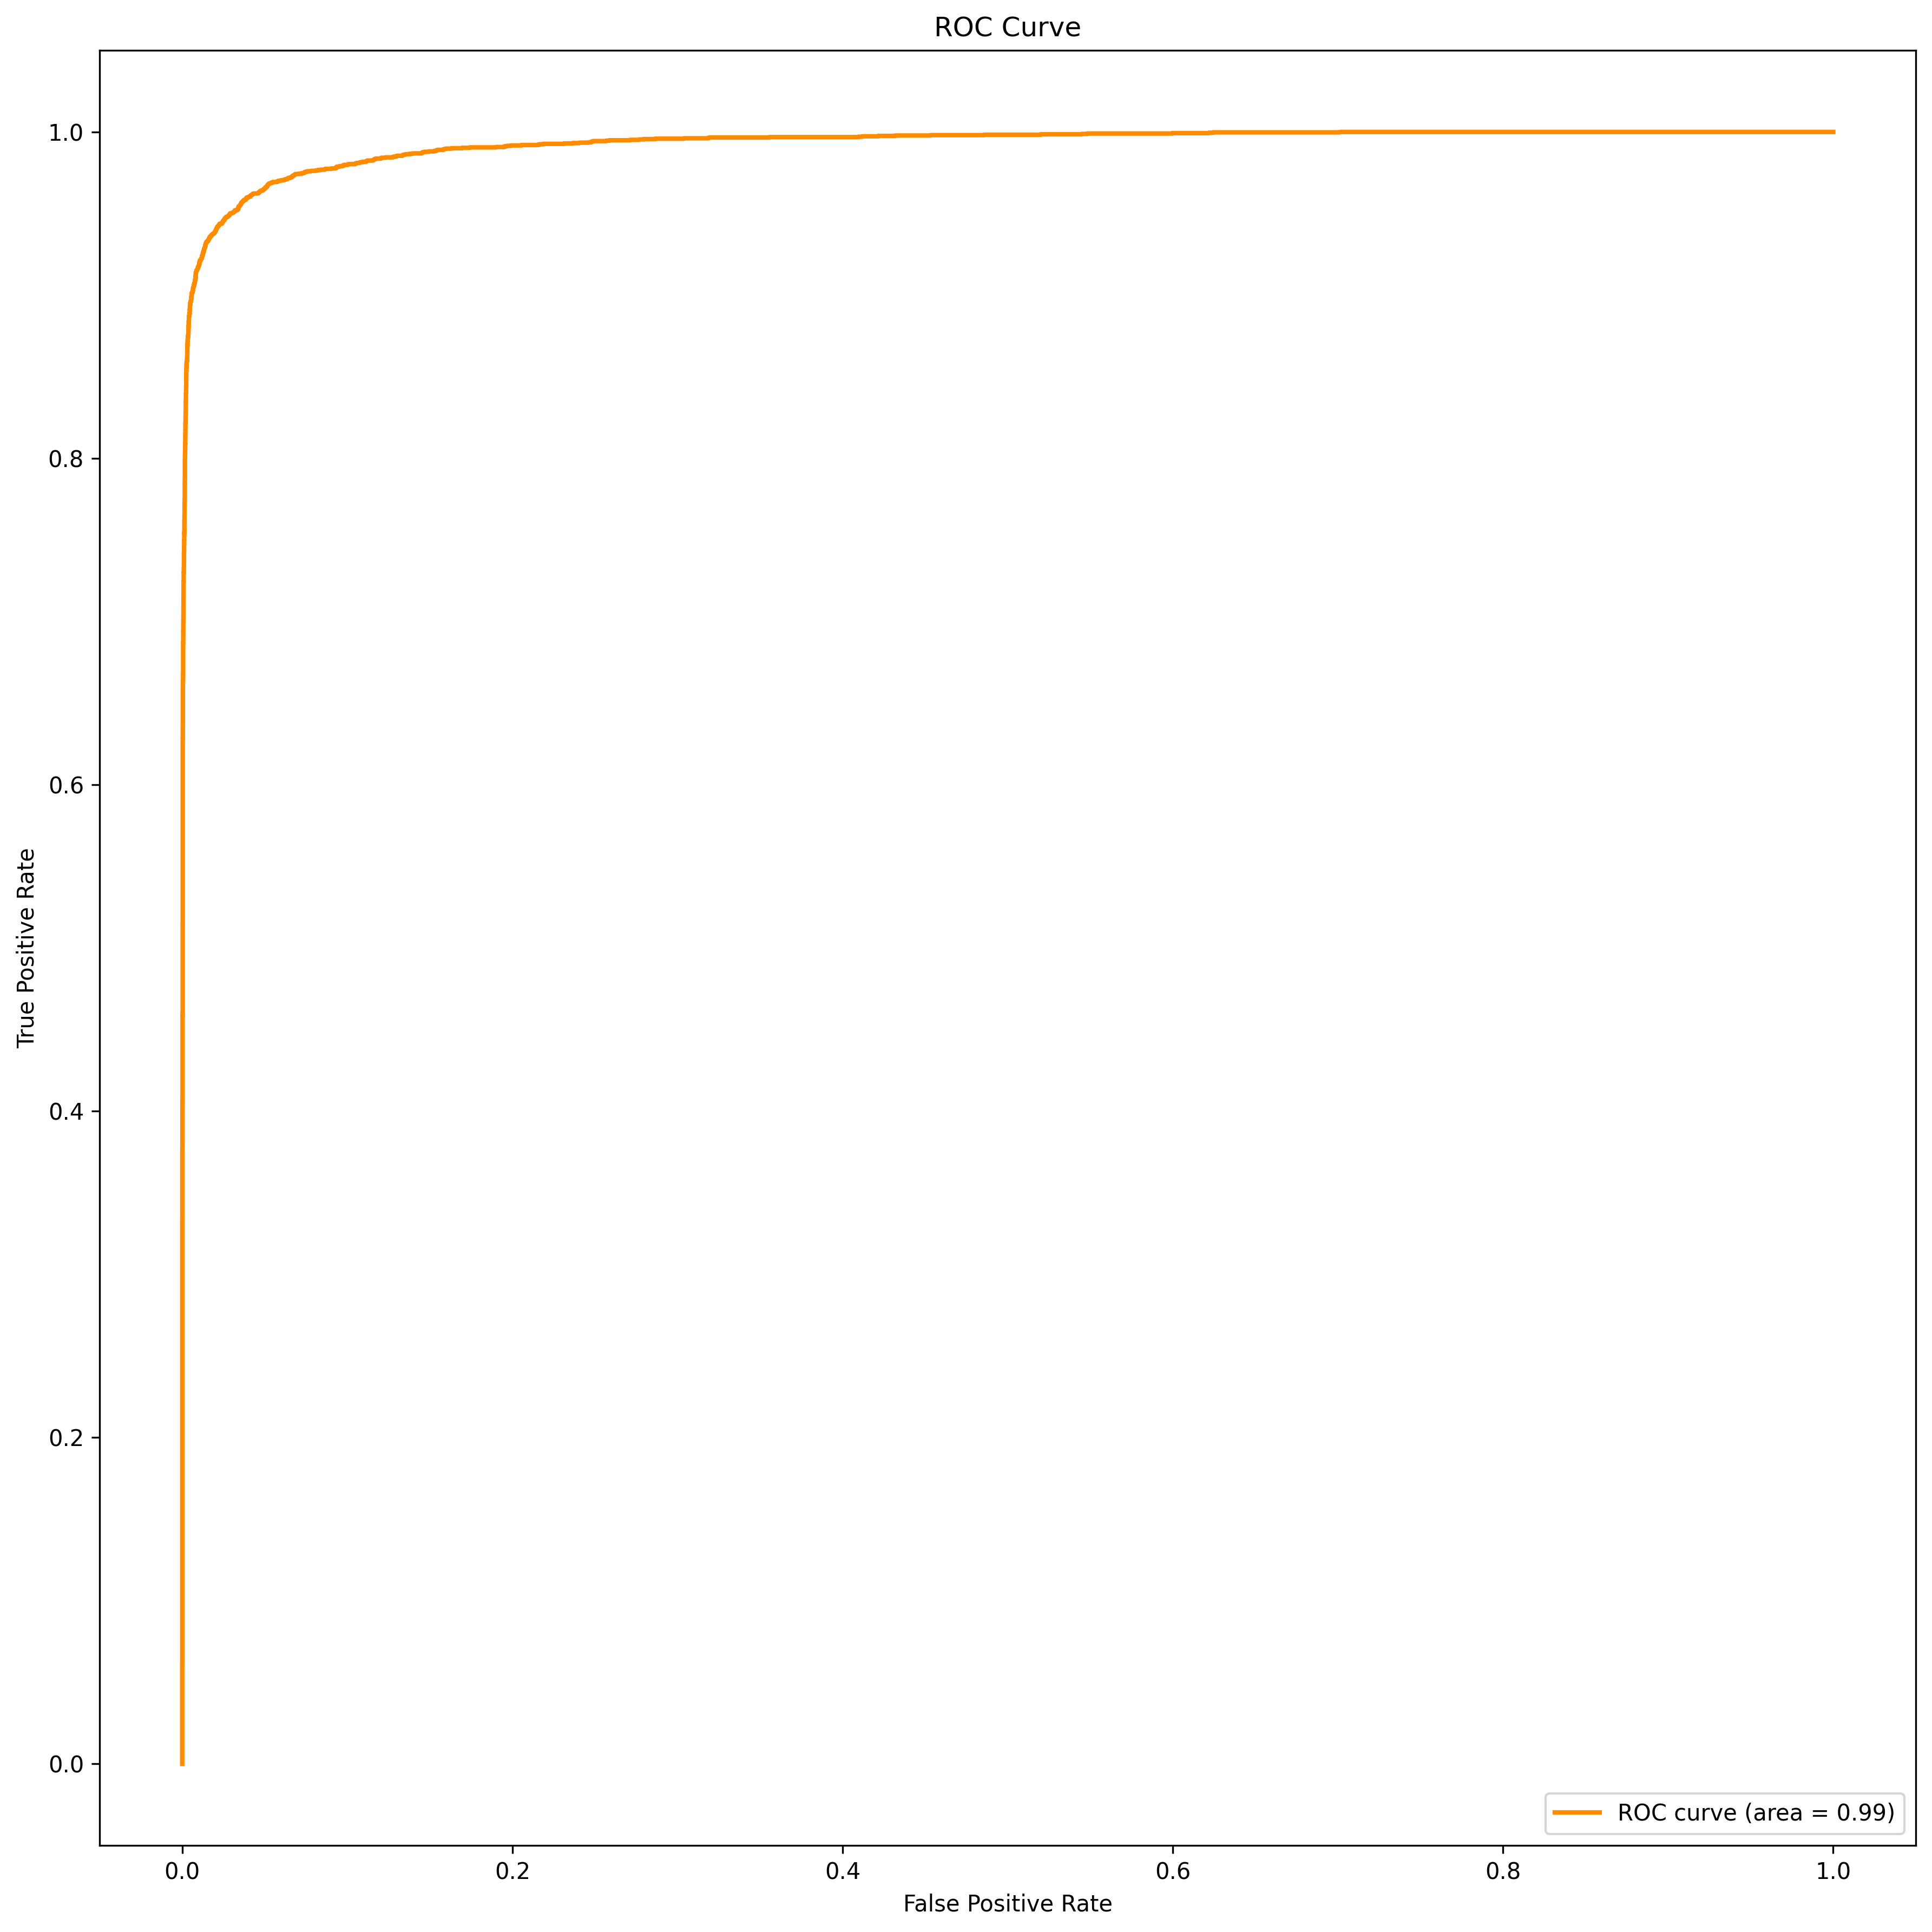

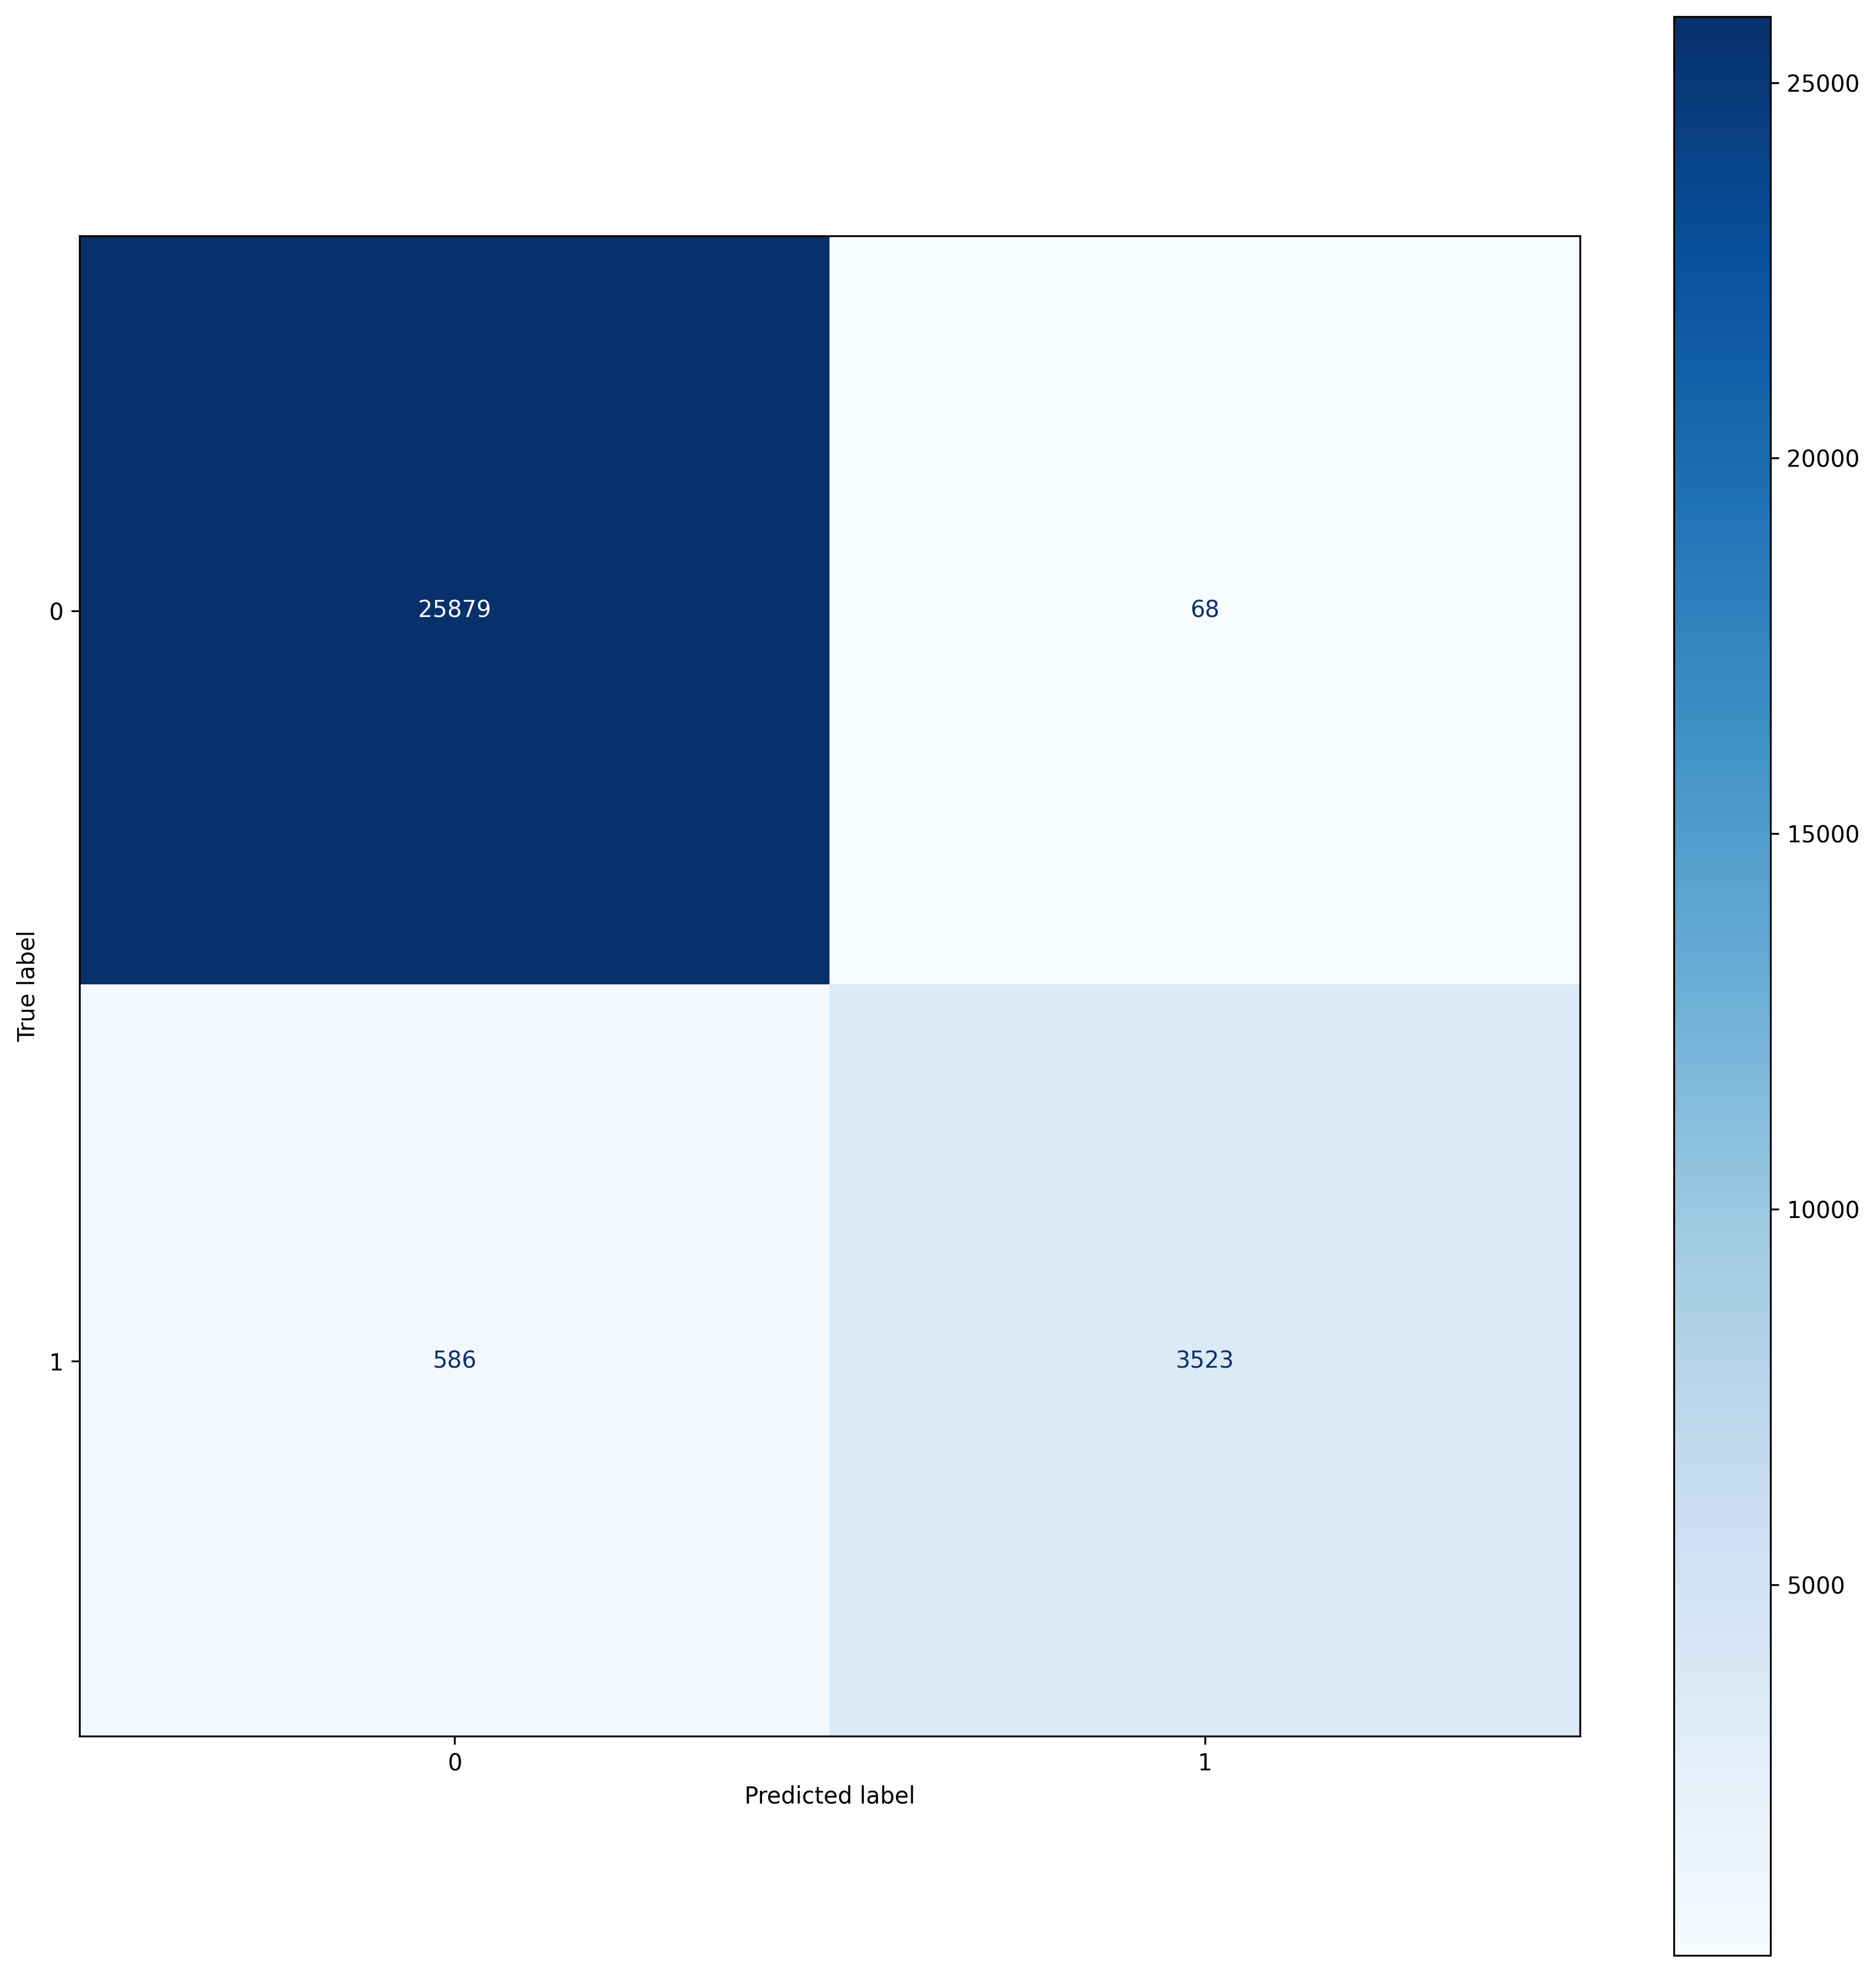

In [69]:
ValidateModel_advanced(X_test, y_test, model)

## Random Forest - Tuning

In [59]:
rf_tuning = True

if rf_tuning:
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    import pandas as pd

    # Assuming df is your DataFrame and class_map maps your classes
    labels = df['label'].apply(lambda x: class_map[x])
    features = df.drop('label', axis=1).copy()

   
    params = {
        "n_estimators": 143,
        "criterion": 'entropy',
        "max_depth": 19,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        #"max_features": None,
        #"max_leaf_nodes": 174,
    }
    
     # Random Forest base model
    rf = RandomForestClassifier(random_state=7, **params)
    
    # Grid of parameters to search    
    grid = {
        #'n_estimators': [143],  # Number of trees in the forest
        #'max_depth': [18, 19, 20],  # Maximum depth of the tree
        #'min_samples_split': [2],  # Minimum number of samples required to split an internal node
        #'min_samples_leaf': [1, 2, 3],  # Minimum number of samples required to be at a leaf node
        #'max_leaf_nodes': [None, 50],  # Maximum number of leaf nodes, None means unlimited
        # Add other parameters here if needed
    }

    # Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=7)

    # Grid Search
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=grid,
        cv=cv,
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    # Best estimator
    best_rf = grid_search.best_estimator_

    # Results
    scores = pd.DataFrame(grid_search.cv_results_)


Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END max_depth=18, min_samples_leaf=1, min_samples_split=2;, score=(train=0.502, test=0.467) total time=   8.1s
[CV 2/2] END max_depth=18, min_samples_leaf=1, min_samples_split=2;, score=(train=0.502, test=0.467) total time=   8.1s
[CV 1/2] END max_depth=18, min_samples_leaf=2, min_samples_split=2;, score=(train=0.497, test=0.466) total time=   8.1s
[CV 2/2] END max_depth=18, min_samples_leaf=2, min_samples_split=2;, score=(train=0.497, test=0.467) total time=   8.0s
[CV 1/2] END max_depth=18, min_samples_leaf=3, min_samples_split=2;, score=(train=0.490, test=0.466) total time=   8.0s
[CV 2/2] END max_depth=18, min_samples_leaf=3, min_samples_split=2;, score=(train=0.490, test=0.465) total time=   8.3s
[CV 1/2] END max_depth=19, min_samples_leaf=1, min_samples_split=2;, score=(train=0.504, test=0.467) total time=   8.6s
[CV 2/2] END max_depth=19, min_samples_leaf=1, min_samples_split=2;, score=(train=0.503, test=0.467)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       6.103486      0.081395         1.998659        0.037408   
1       6.022788      0.017866         1.996893        0.025254   
2       6.103910      0.141947         2.067184        0.006925   
3       6.413139      0.012714         2.146540        0.012591   
4       6.287759      0.046884         2.082003        0.000847   
5       6.387046      0.108770         2.124717        0.028061   
6       6.389014      0.021462         2.096521        0.026630   
7       6.396135      0.042568         2.086342        0.019762   
8       6.304087      0.054151         2.172356        0.078907   

  param_max_depth param_min_samples_leaf param_min_samples_split  \
0              18                      1                       2   
1              18                      2                       2   
2              18                      3                       2   
3              19                      1                 

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       6.103486      0.081395         1.998659        0.037408   
1       6.022788      0.017866         1.996893        0.025254   
2       6.103910      0.141947         2.067184        0.006925   
3       6.413139      0.012714         2.146540        0.012591   
4       6.287759      0.046884         2.082003        0.000847   
5       6.387046      0.108770         2.124717        0.028061   
6       6.389014      0.021462         2.096521        0.026630   
7       6.396135      0.042568         2.086342        0.019762   
8       6.304087      0.054151         2.172356        0.078907   

  param_max_depth param_min_samples_leaf param_min_samples_split  \
0              18                      1                       2   
1              18                      2                       2   
2              18                      3                       2   
3              19                      1                       2   
4              19                      2                       2   
5              19                      3                       2   
6              20                      1                       2   
7              20                      2                       2   
8              20                      3                       2   

                                              params  split0_test_score  \
0  {'max_depth': 18, 'min_samples_leaf': 1, 'min_...           0.466619   
1  {'max_depth': 18, 'min_samples_leaf': 2, 'min_...           0.466308   
2  {'max_depth': 18, 'min_samples_leaf': 3, 'min_...           0.466409   
3  {'max_depth': 19, 'min_samples_leaf': 1, 'min_...           0.466655   
4  {'max_depth': 19, 'min_samples_leaf': 2, 'min_...           0.466016   
5  {'max_depth': 19, 'min_samples_leaf': 3, 'min_...           0.465606   
6  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...           0.466656   
7  {'max_depth': 20, 'min_samples_leaf': 2, 'min_...           0.465902   
8  {'max_depth': 20, 'min_samples_leaf': 3, 'min_...           0.465501   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  \
0           0.467277         0.466948        0.000329                2   
1           0.466761         0.466534        0.000226                4   
2           0.465182         0.465795        0.000613                9   
3           0.467322         0.466989        0.000333                1   
4           0.466463         0.466239        0.000223                6   
5           0.466405         0.466005        0.000400                7   
6           0.466784         0.466720        0.000064                3   
7           0.466578         0.466240        0.000338                5   
8           0.466249         0.465875        0.000374                8   

   split0_train_score  split1_train_score  mean_train_score  std_train_score  
0            0.502295            0.502069          0.502182         0.000113  
1            0.496535            0.496582          0.496559         0.000023  
2            0.490499            0.490428          0.490463         0.000036  
3            0.503552            0.503130          0.503341         0.000211  
4            0.497459            0.497696          0.497578         0.000118  
5            0.491307            0.490380          0.490843         0.000464  
6            0.503972            0.503629          0.503800         0.000172  
7            0.498283            0.499001          0.498642         0.000359  
8            0.492463            0.491256          0.491860         0.000603

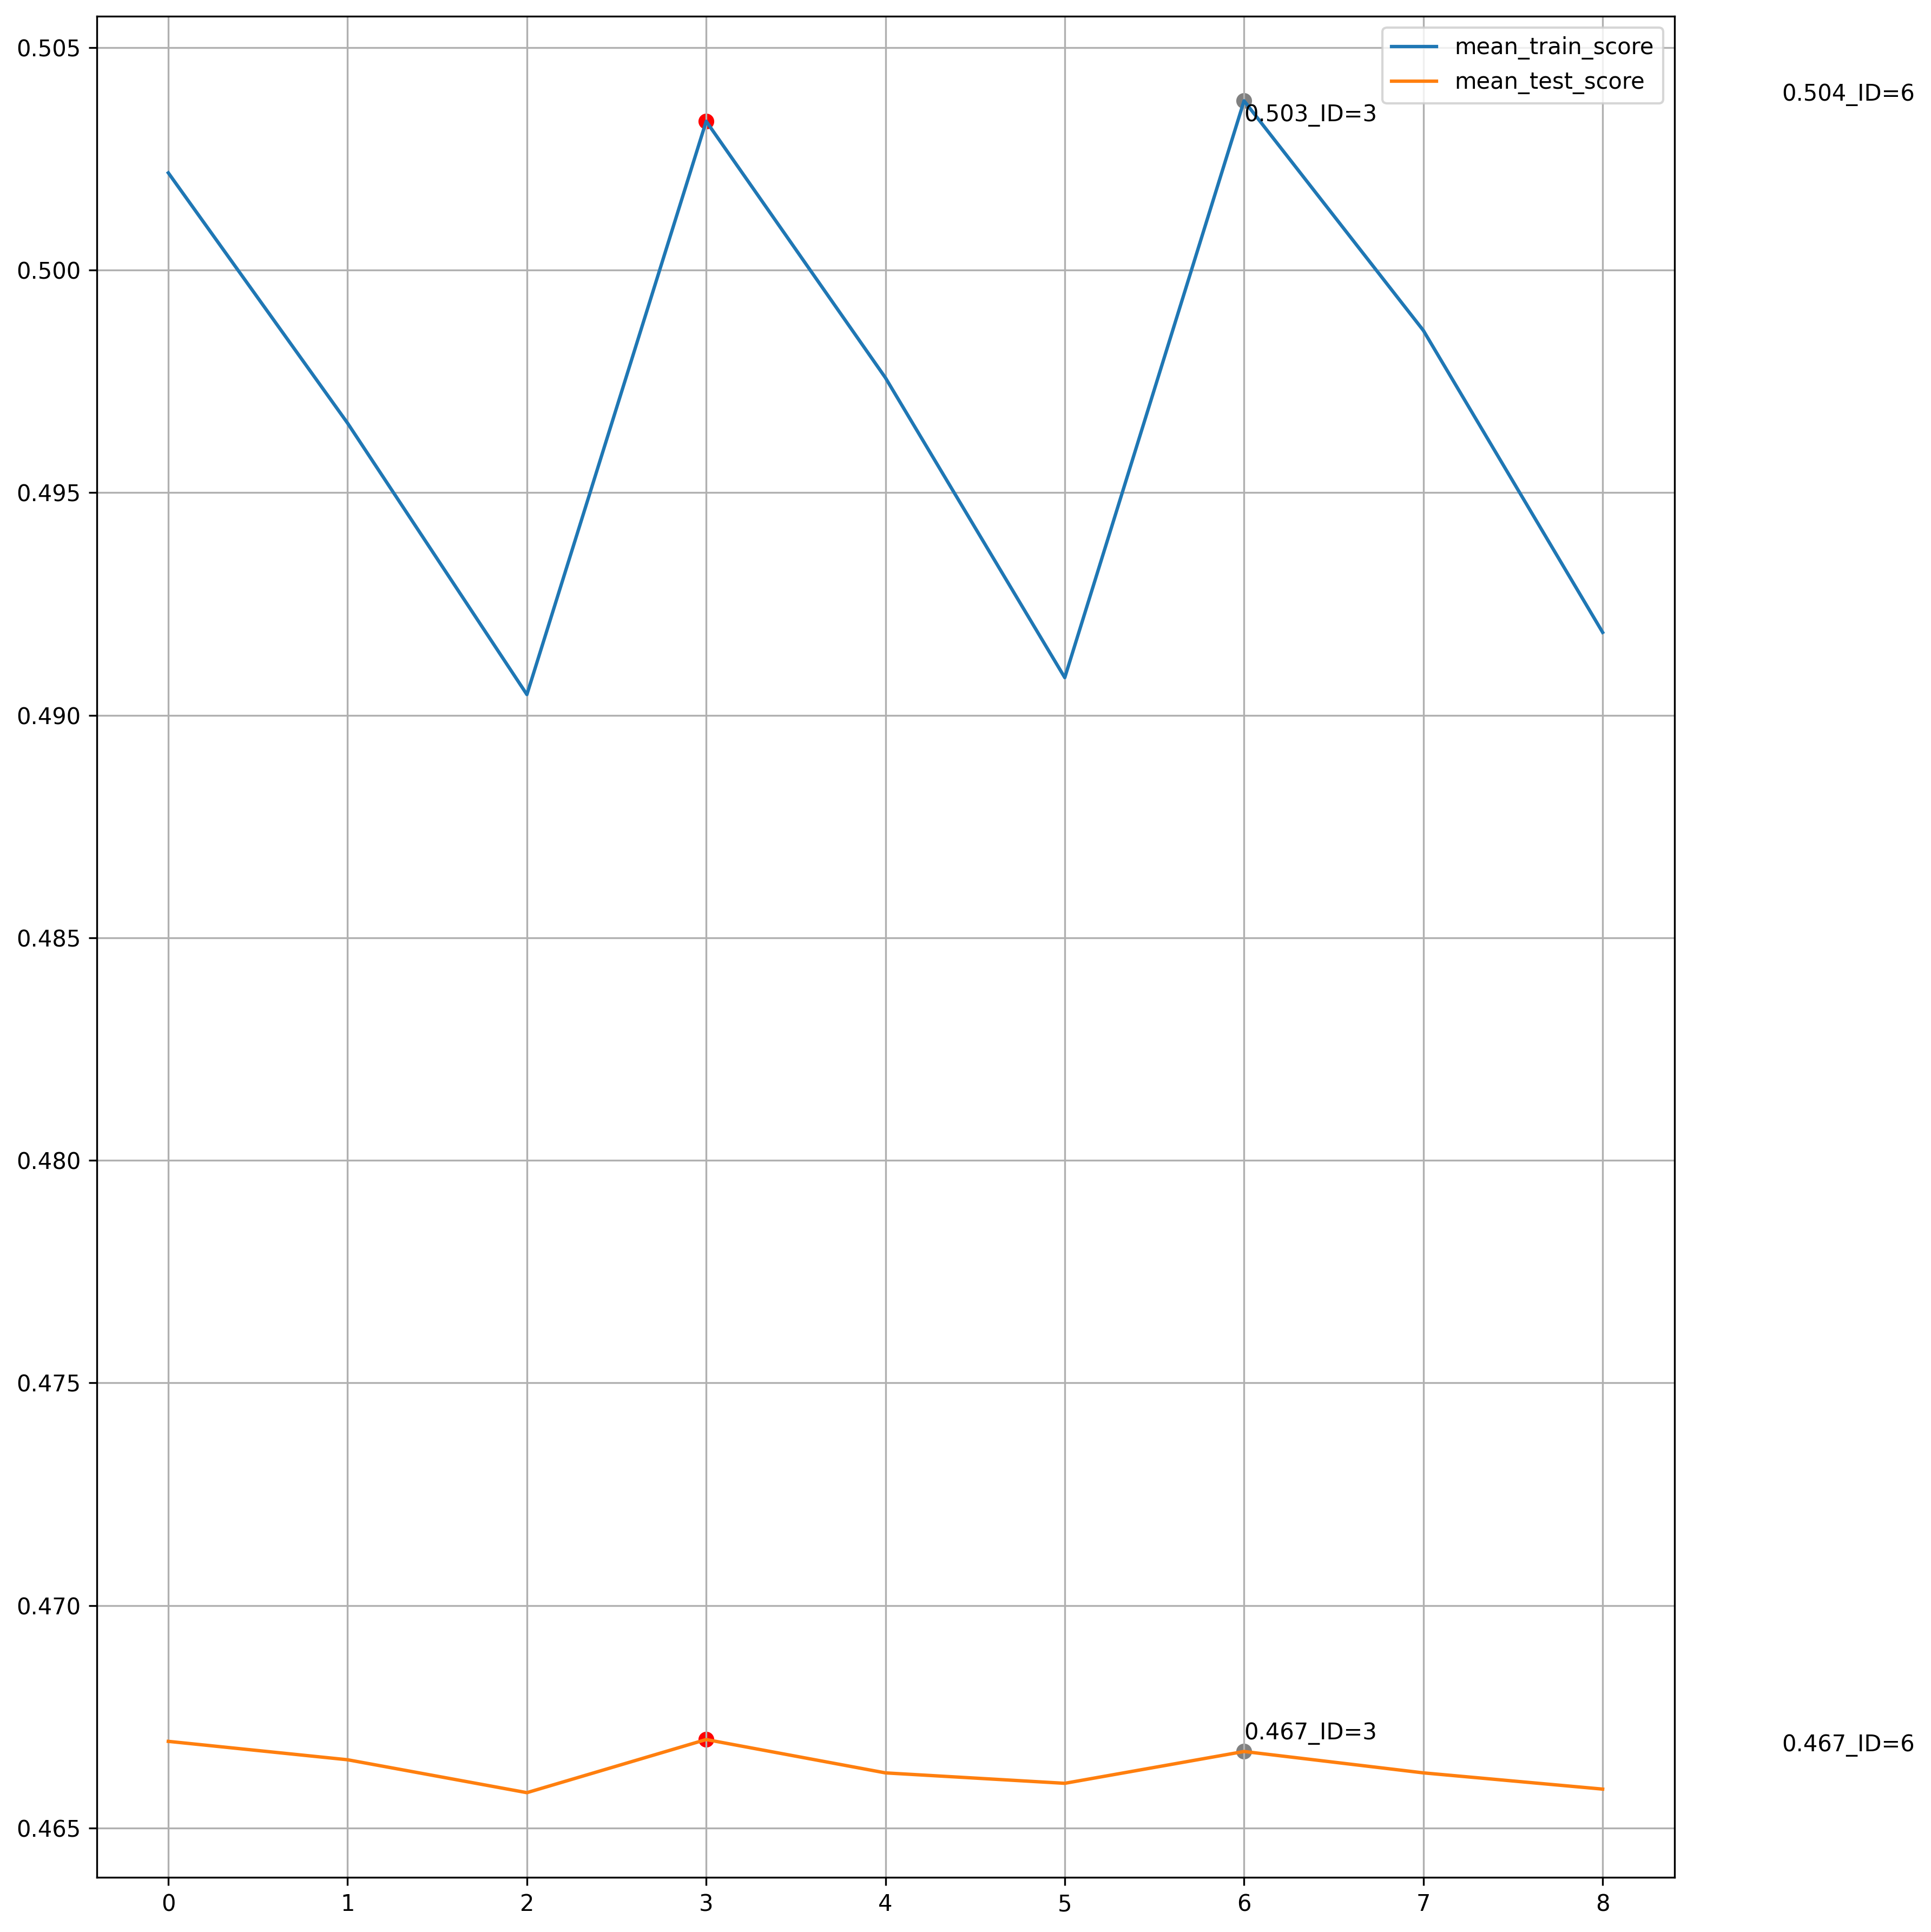

In [60]:
if rf_tuning:
    DisplayTuningGraph(scores)

scores

# AdaBoost

## AdaBoost - Training

In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# AdaBoost parameters with variable seed
params = {
    #"base_estimator": DecisionTreeClassifier(max_depth=4),  #  base estimator
    #"n_estimators": 643,  # Number of weak learners to train iteratively
    "base_estimator": DecisionTreeClassifier(max_depth=2),  #  base estimator
    "n_estimators": 643,  # Number of weak learners to train iteratively
    "random_state": 7,  # It will control the randomness of the algorithm
}

# Create and train the model
model = AdaBoostClassifier(
    **params,
)
model.fit(X_train, y_train)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=200, random_state=7)

## AdaBoost - Validation

TN: 38487 <-- True Negatives
FP: 373 <-- False Positives
FN: 800 <-- False Negatives
TP: 5424 <-- True Positives
FPR:0.00959855892949048 <-- False Positive Rate
TPR:0.87146529562982 <-- True Positive Rate (same as Recall)
 
              precision    recall  f1-score   support

           0     0.9796    0.9904    0.9850     38860
           1     0.9357    0.8715    0.9024      6224

    accuracy                         0.9740     45084
   macro avg     0.9576    0.9309    0.9437     45084
weighted avg     0.9736    0.9740    0.9736     45084



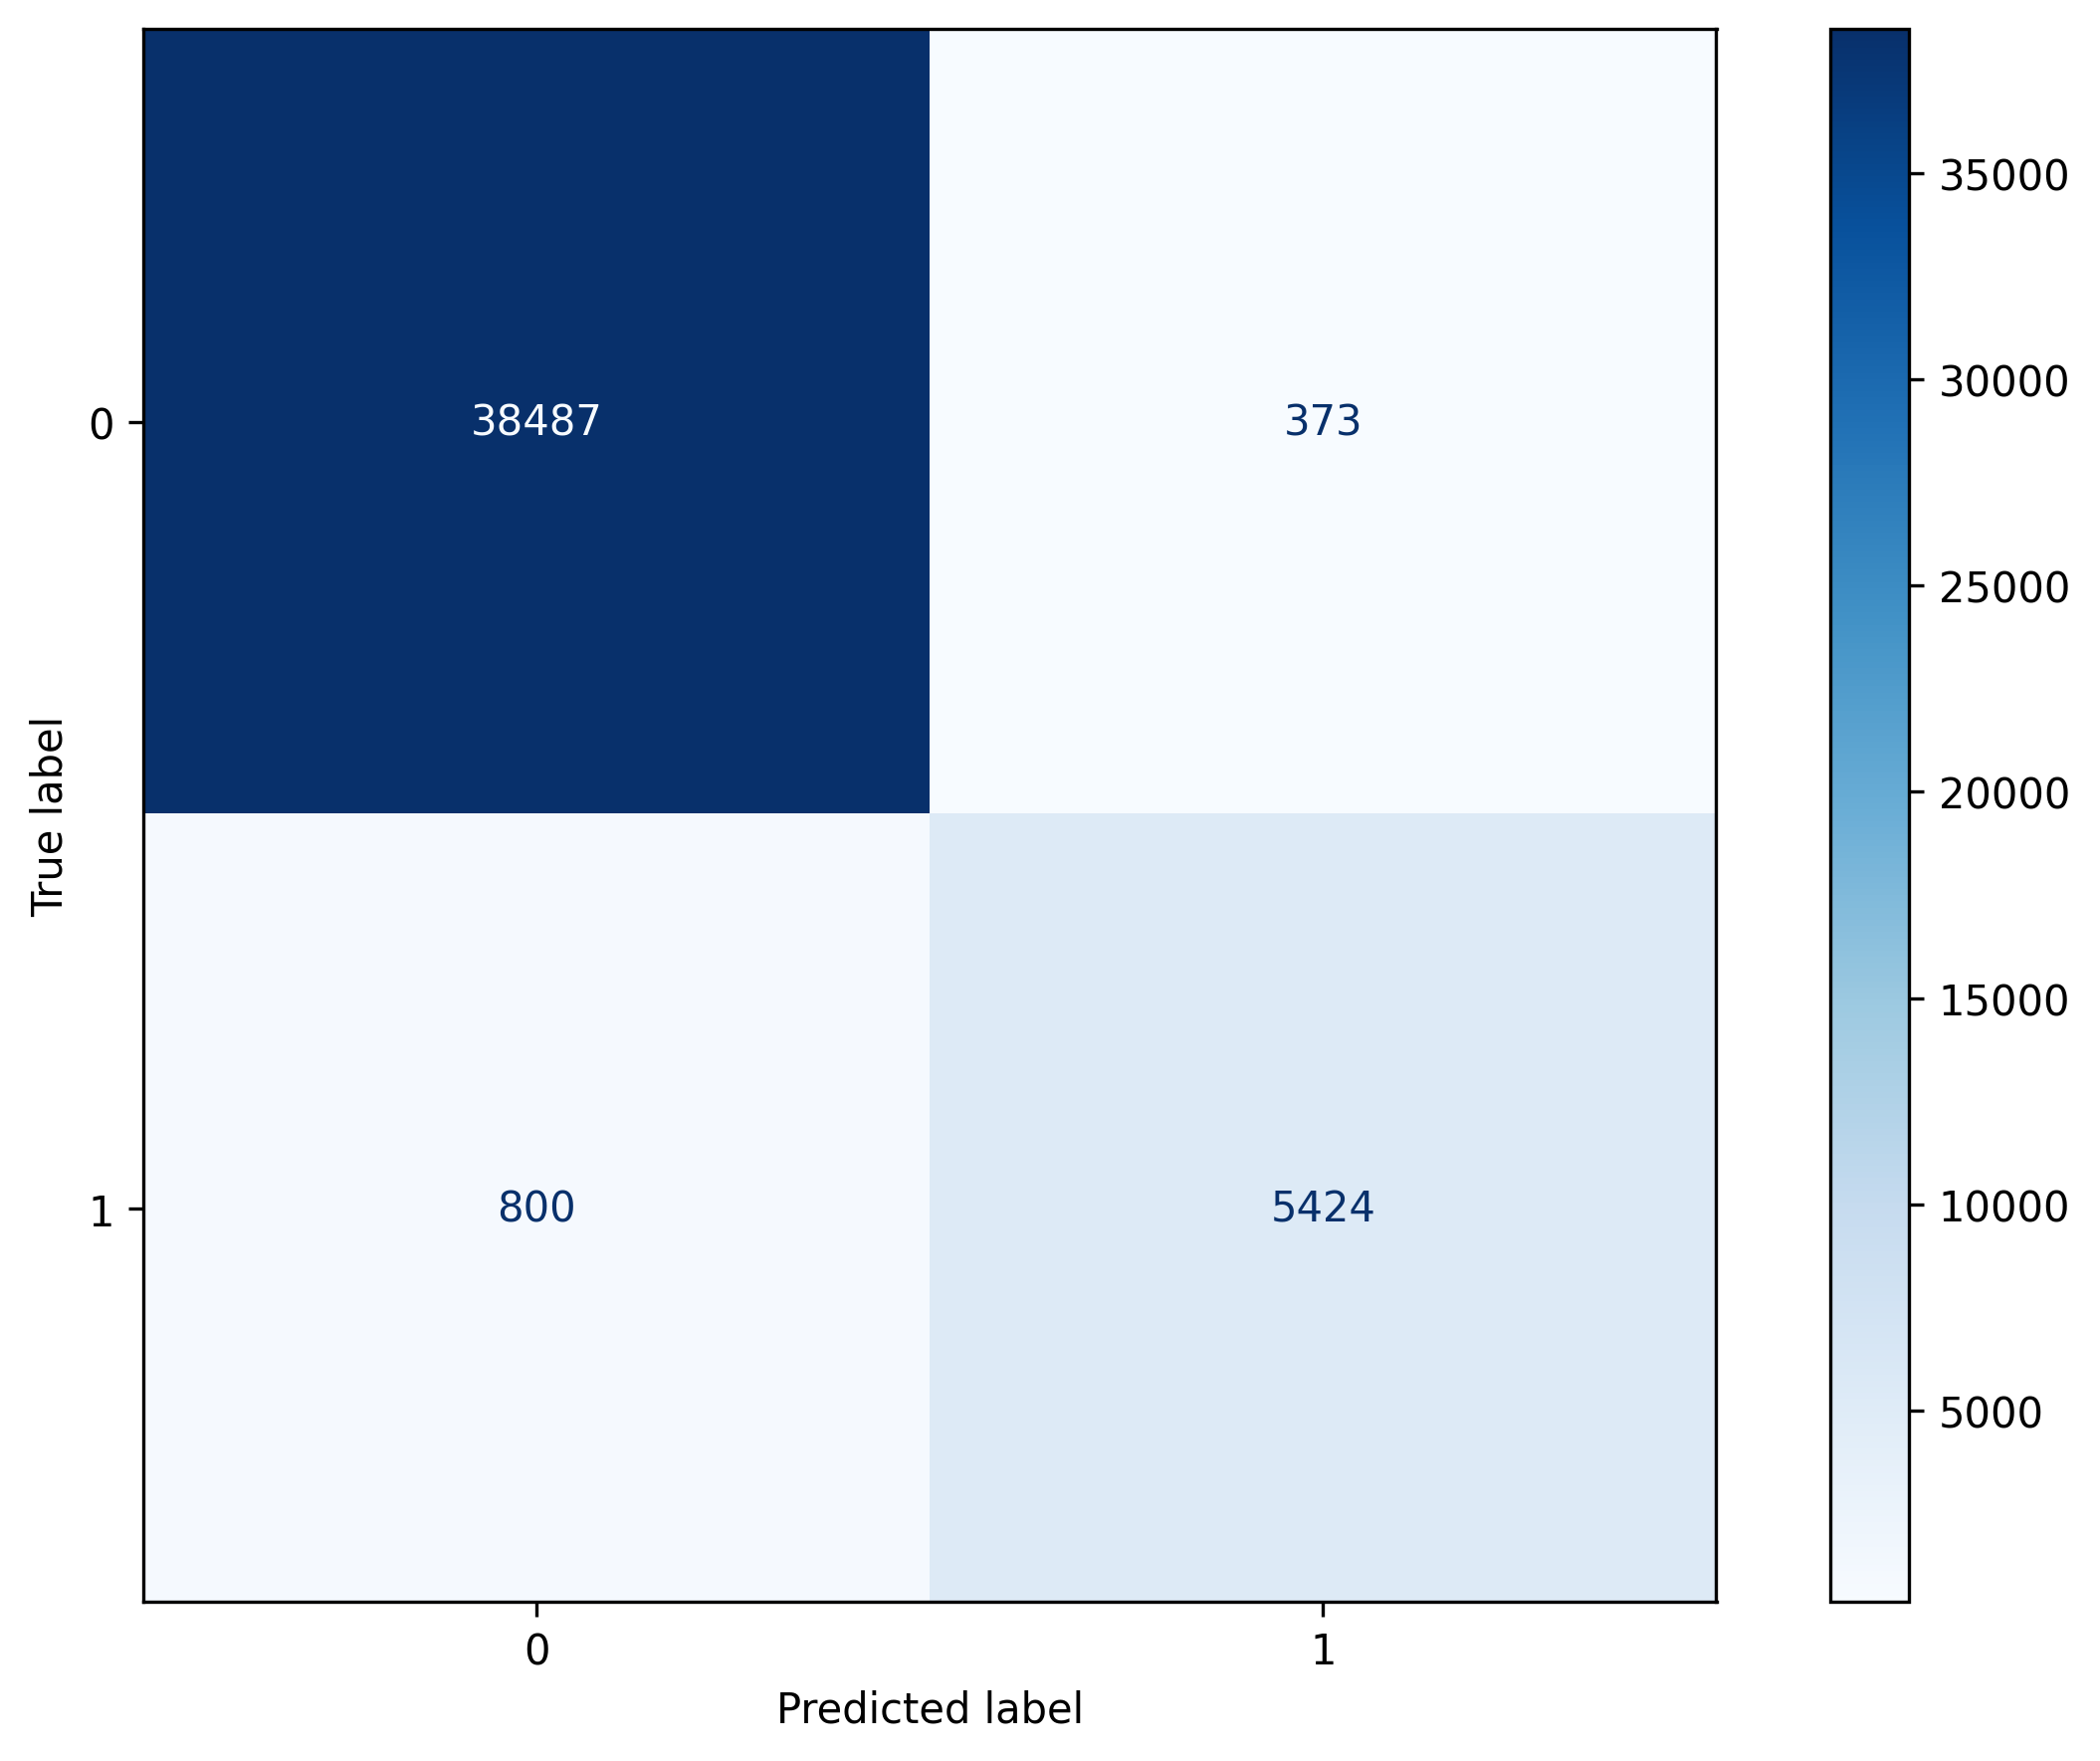

In [28]:
ValidateModel(X_test, y_test, model)

## AdaBoost - Tuning

In [73]:
ada_tuning = True

if ada_tuning:
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    import pandas as pd

    # Assuming df is your DataFrame and class_map maps your classes
    labels = df['label'].apply(lambda x: class_map[x])
    features = df.drop('label', axis=1)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

    # AdaBoost base model parameters
    params = {
        "base_estimator": DecisionTreeClassifier(max_depth=4),  # Base estimator
        "random_state": 7
    }

    # AdaBoost base model
    ada = AdaBoostClassifier(**params)

    # Grid of parameters to search
    grid = {
        #"base_estimator": [DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=4), DecisionTreeClassifier(max_depth=5)], 
        "n_estimators": [200, 400, 650],  # Number of weak learners to train iteratively
        #'learning_rate': [0.01, 0.1, 1.0],  # Learning rate shrinks the contribution of each classifier
        # Add other parameters here if needed
    }

    # Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=7)

    # Grid Search
    grid_search = GridSearchCV(
        estimator=ada,
        param_grid=grid,
        cv=cv,
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    # Best estimator
    best_ada = grid_search.best_estimator_

    # Results
    scores = pd.DataFrame(grid_search.cv_results_)


Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END n_estimators=200;, score=(train=0.505, test=0.463) total time= 1.1min
[CV 2/2] END n_estimators=200;, score=(train=0.504, test=0.468) total time= 1.1min
[CV 1/2] END n_estimators=400;, score=(train=0.504, test=0.467) total time= 2.3min
[CV 2/2] END n_estimators=400;, score=(train=0.504, test=0.471) total time= 2.1min
[CV 1/2] END n_estimators=650;, score=(train=0.504, test=0.470) total time= 4.0min
[CV 2/2] END n_estimators=650;, score=(train=0.504, test=0.473) total time= 3.6min


In [ ]:
if ada_tuning:
    DisplayTuningGraph(scores)

scores

# XGBoost

## XGBoost - Training

In [132]:
from xgboost import XGBClassifier
# uncomment the two disabled lines to use GPU
params = {
    "max_depth": 9,
    "eta": 0.15,
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    "min_child_weight": 2.0,
    "subsample": 0.6,
    "sampling_method": "gradient_based",
    "alpha": 0,
    "gamma": 0.1,
    "lambda": 1.0,
    "max_delta_step": 0,
    "grow_policy": "lossguide",
    "max_bin": 512,
    "n_estimators": 270,
    
    "random_state": 7,
}

model = XGBClassifier(
  **params,
  eval_metric=["error", "logloss", "auc"]
)

# at last, train the model
eval_set = [(X_train, y_train), (X_test, y_test)]
_ = model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

/home/fitcrack/.local/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/fitcrack/.local/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/fitcrack/.local/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/fitcrack/.local/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/fitcrack/.local/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


## XGBoost - Validation

              precision    recall  f1-score   support

           0     0.9962    0.9984    0.9973    129772
           1     0.9895    0.9759    0.9826     20506

    accuracy                         0.9953    150278
   macro avg     0.9928    0.9871    0.9900    150278
weighted avg     0.9953    0.9953    0.9953    150278

Confusion Matrix:
TN: 129559 FP: 213 FN: 494 TP: 20012


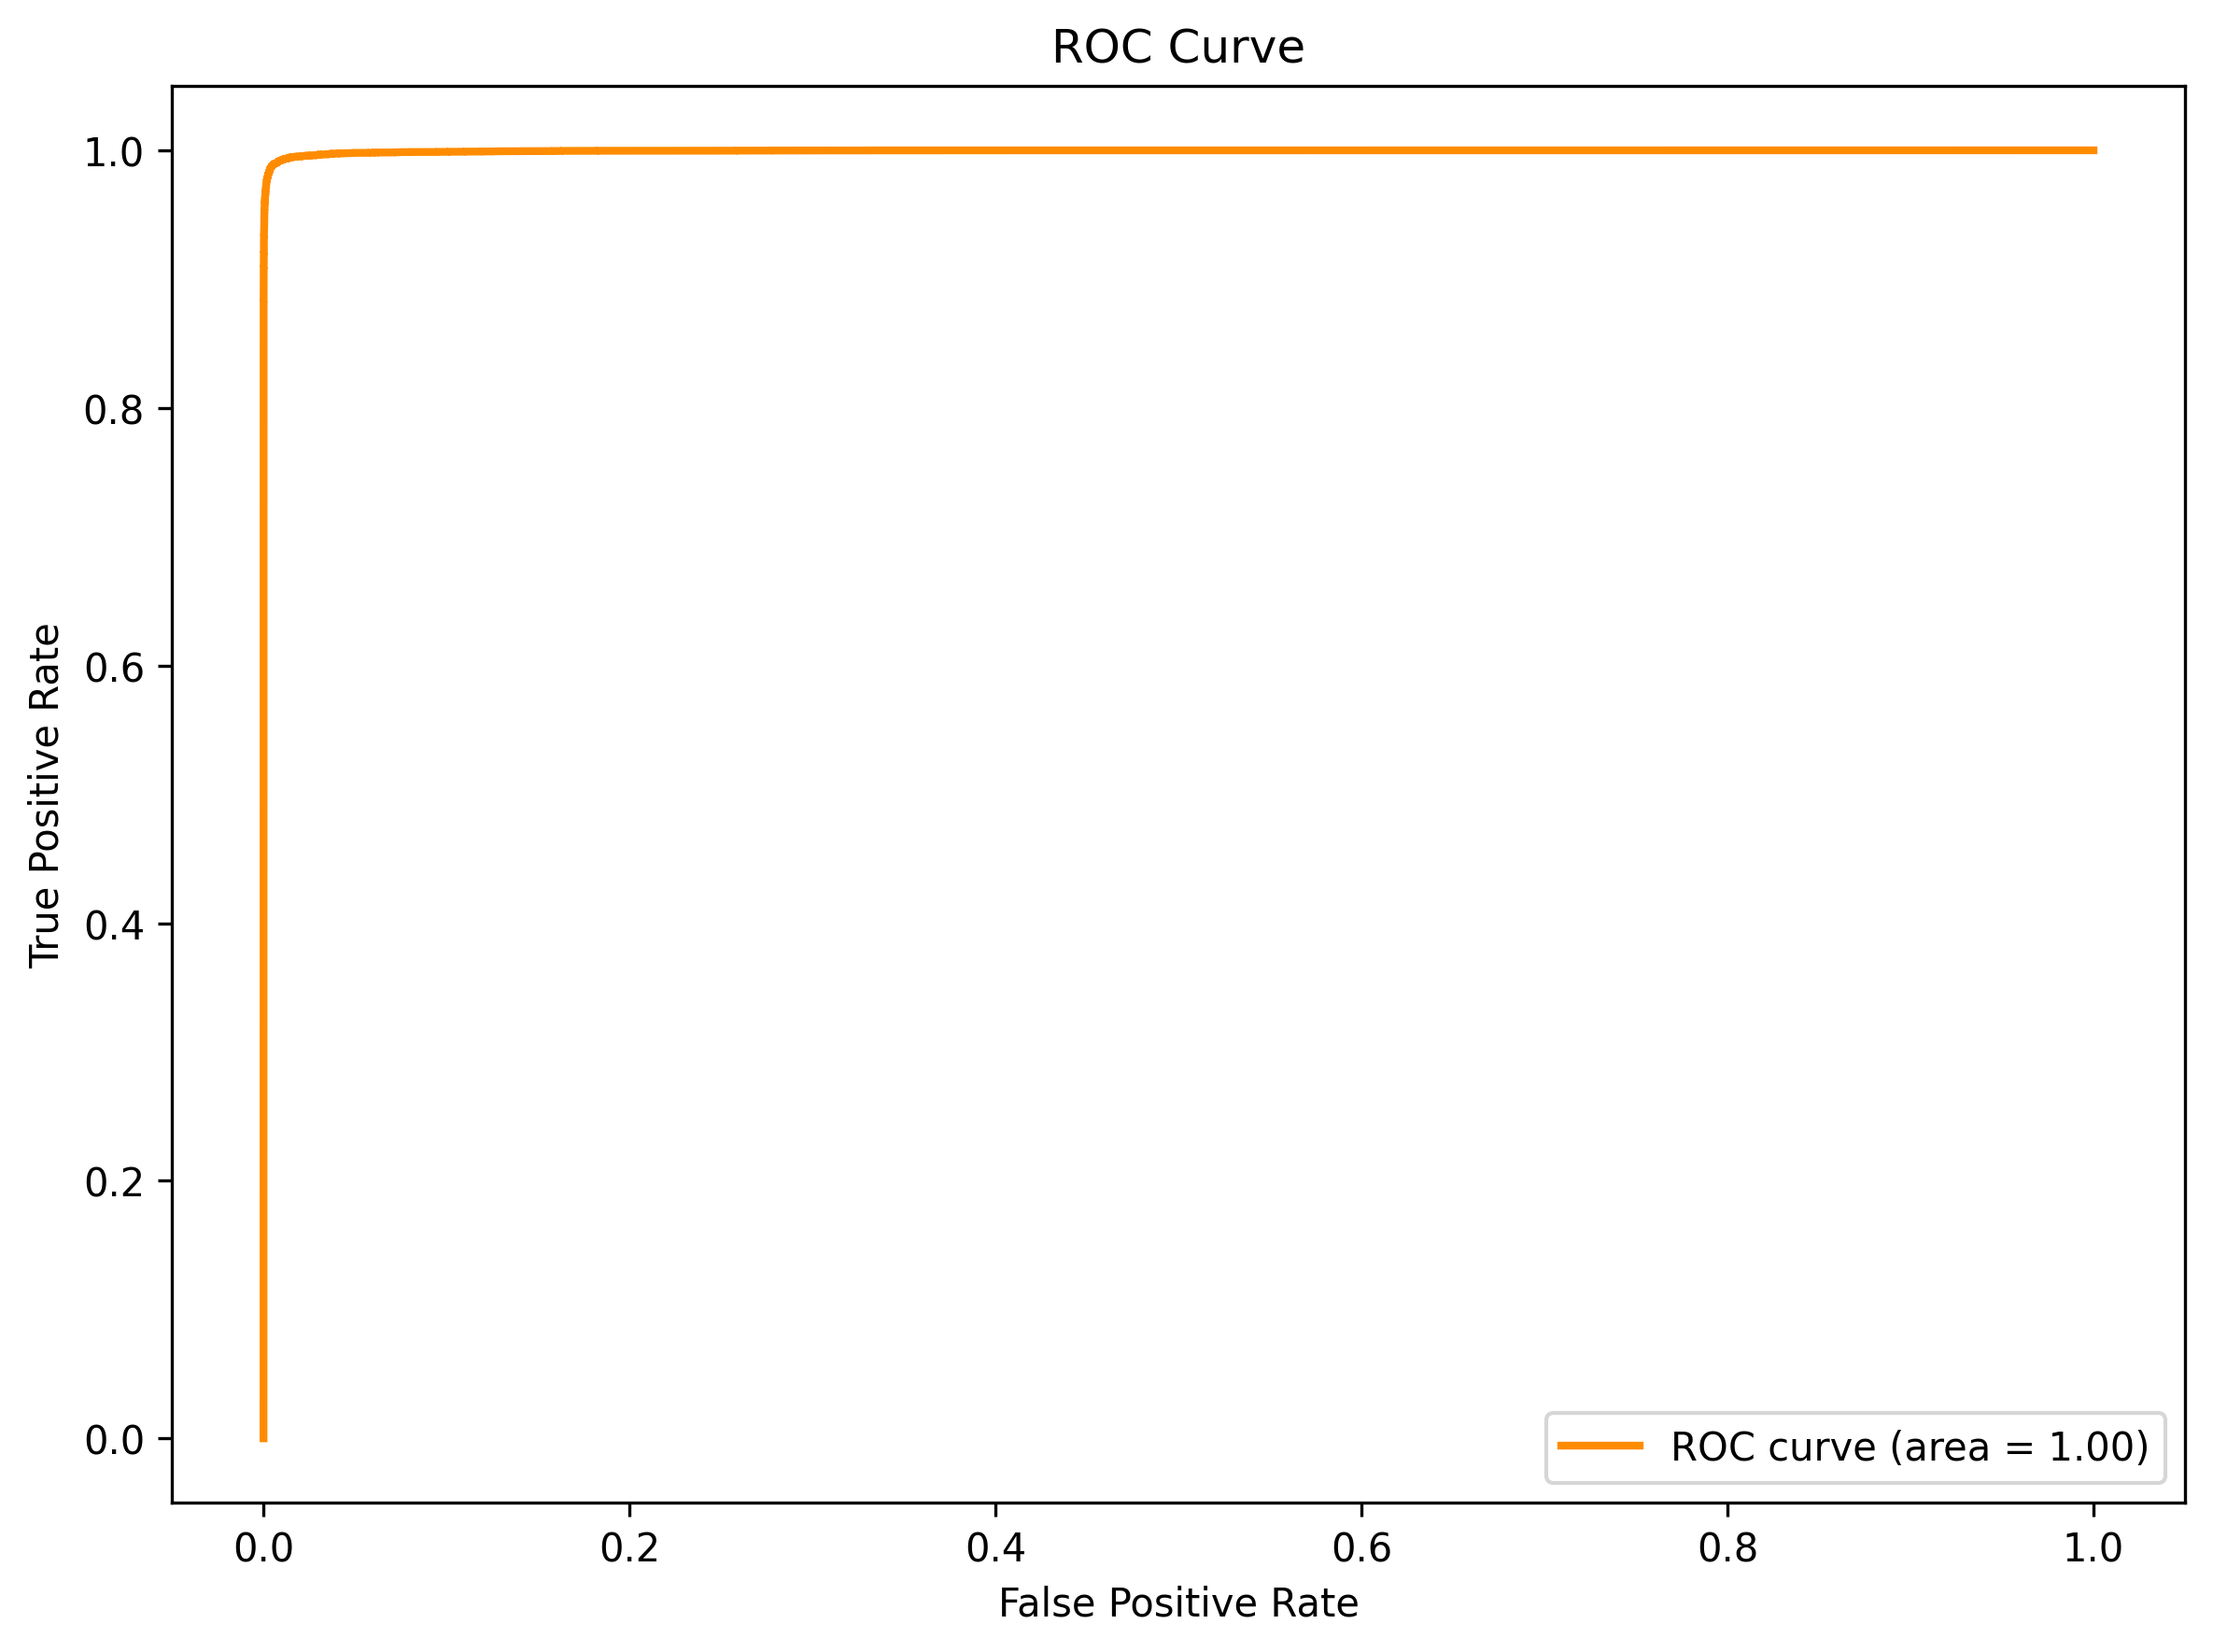

Training metrics: odict_keys(['error', 'logloss', 'auc'])
Validation metrics: odict_keys(['error', 'logloss', 'auc'])


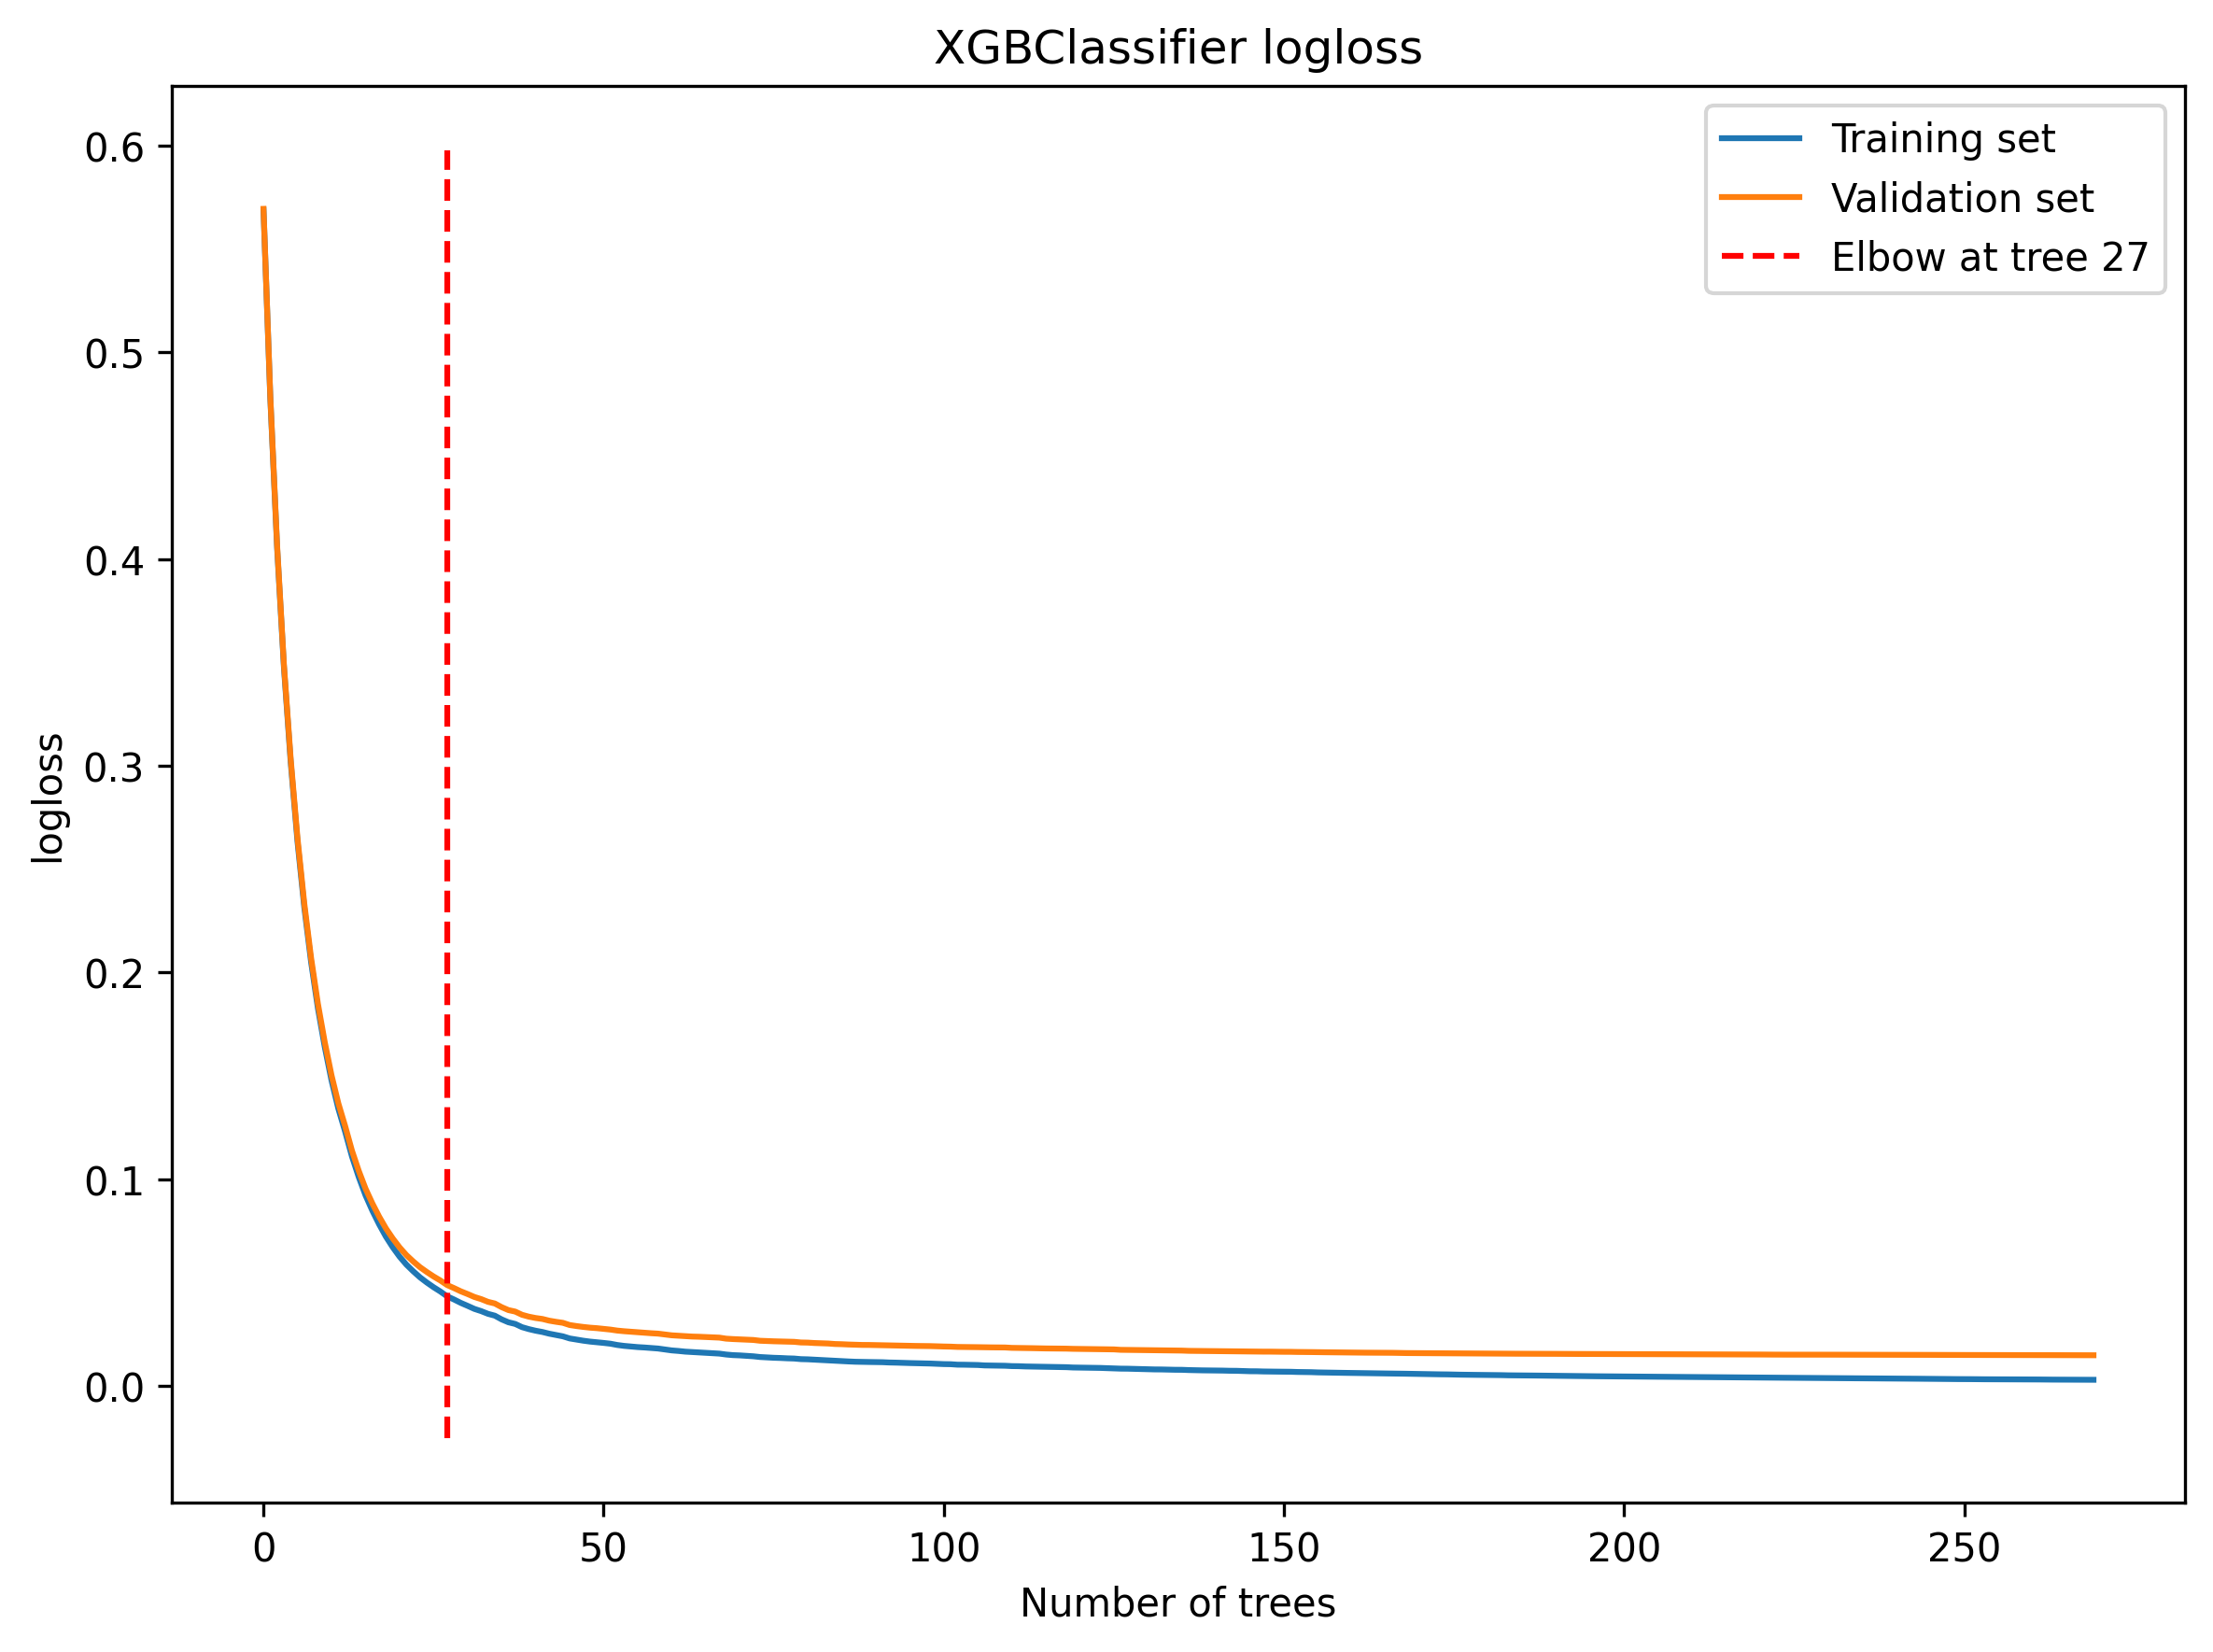

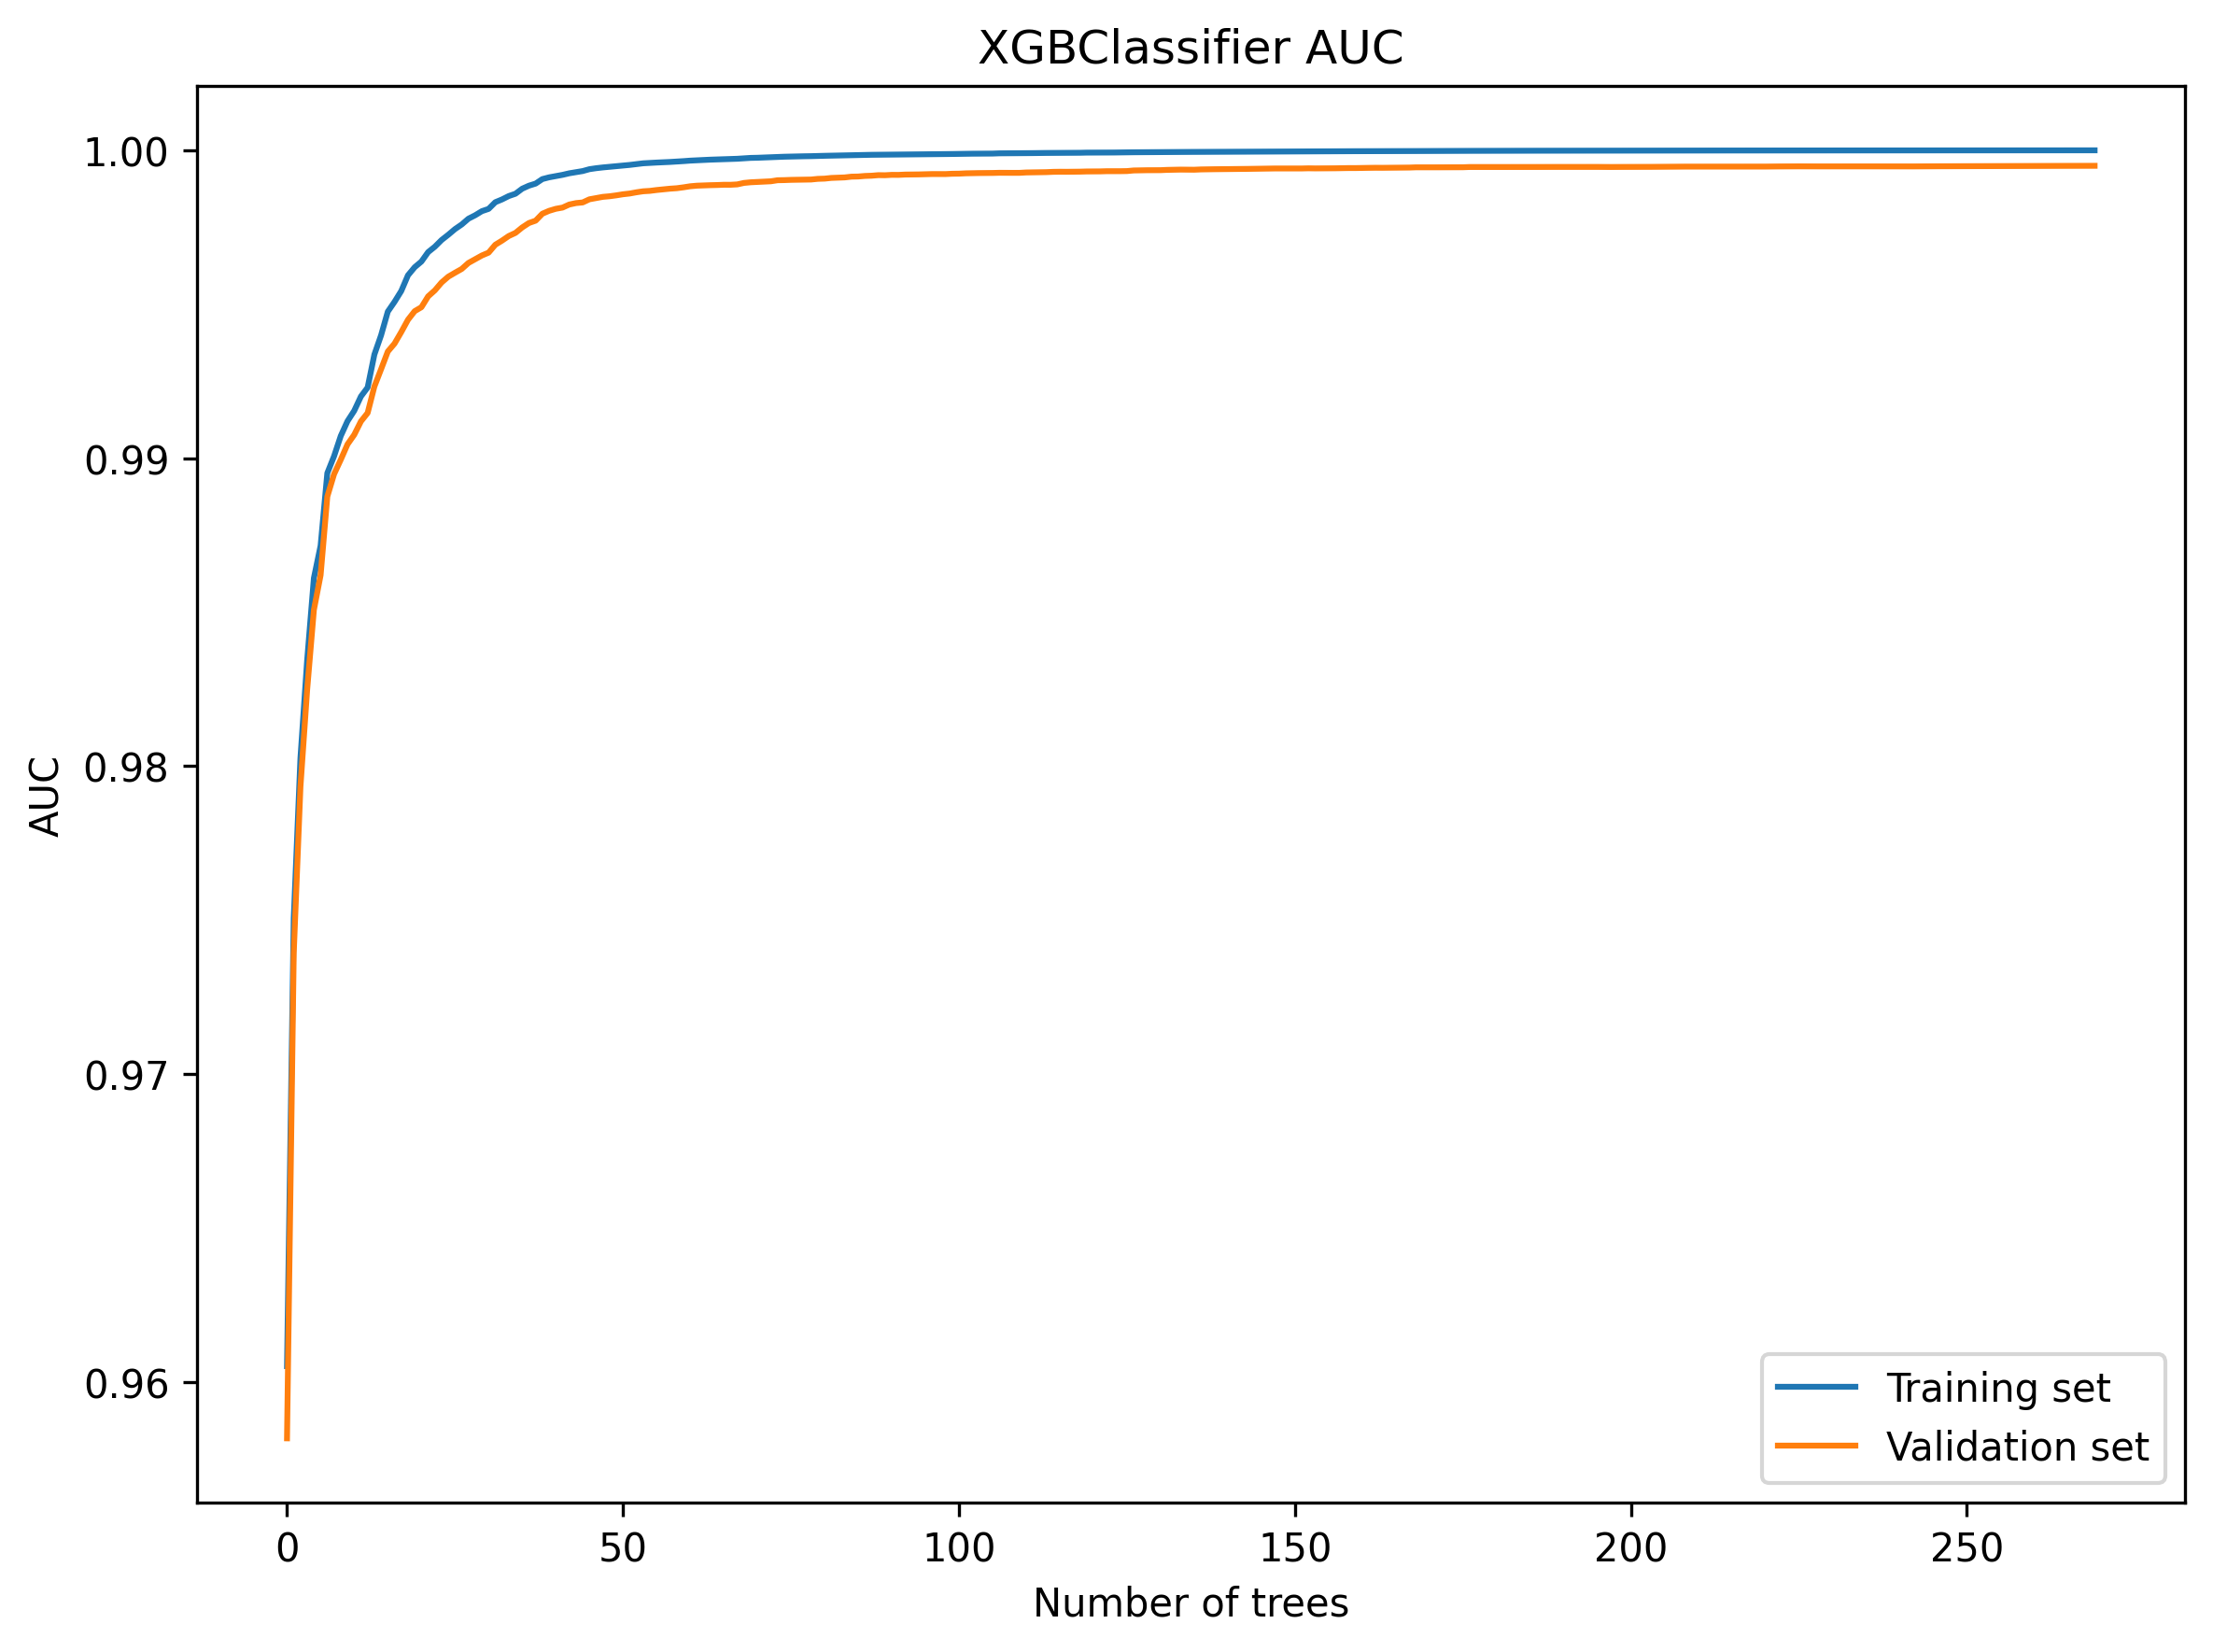

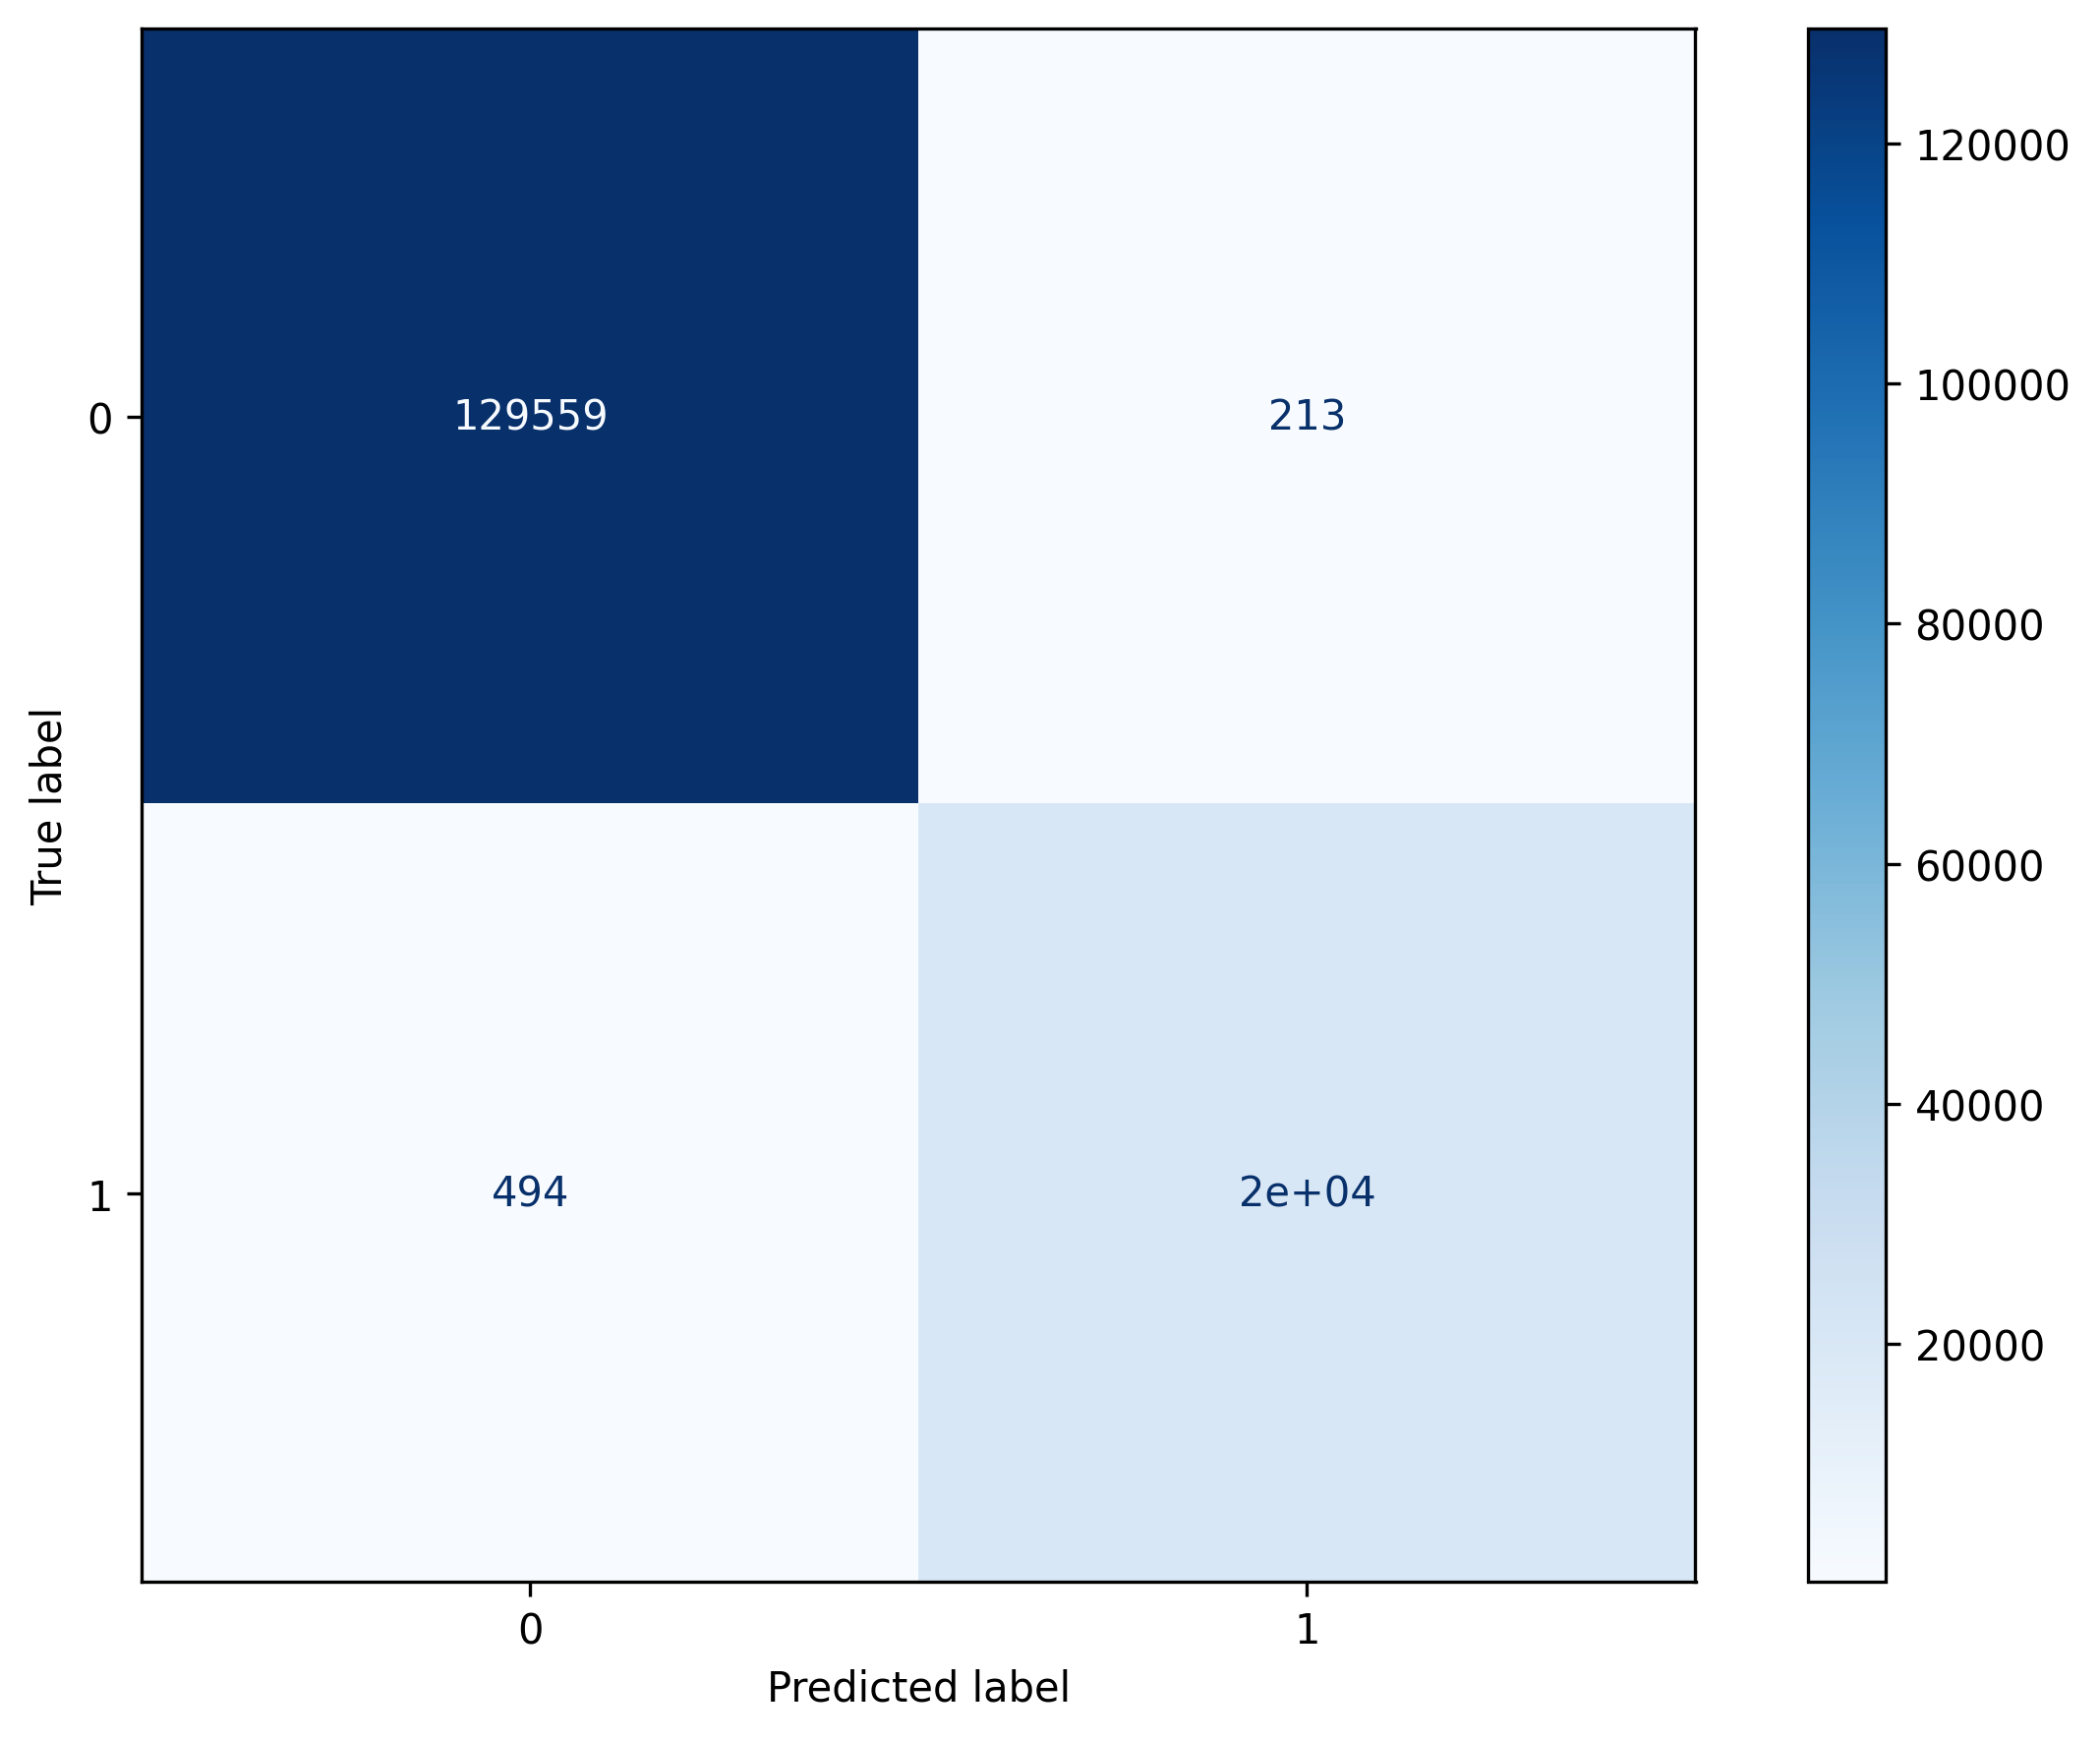

In [137]:
ValidateModel_advanced(X_test, y_test, model)

## XGBoost - Tuning

In [ ]:
xgb_tuning = True

if xgb_tuning:
    from xgboost import XGBClassifier
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    import pandas as pd

    # Assuming df is your DataFrame and class_map maps your classes
    labels = df['label'].apply(lambda x: class_map[x])
    features = df.drop('label', axis=1).copy()

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

    params = {
        "objective": "binary:logistic",
        "tree_method": "gpu_hist"
        "eval_metric": ["error", "logloss", "auc"],
        "random_state": 7
    }
    
    # XGBoost base model
    xgb = XGBClassifier(**params)
    
    # Grid of parameters to search    
    grid = {
        'n_estimators': [200, 270],  # Number of trees
        'max_depth': [7, 9, 11],  # Maximum depth of a tree
        'eta': [0.1, 0.15, 0.2],  # Learning rate
        'min_child_weight': [1, 2],  # Minimum sum of instance weight needed in a child
        'subsample': [0.5, 0.6],  # Subsample ratio of the training instances
        'gamma': [0.1, 0.2],  # Minimum loss reduction required to make a further partition
        # Add other parameters here if needed
    }

    # Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

    # Grid Search
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=grid,
        cv=cv,
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

    # Best estimator
    best_xgb = grid_search.best_estimator_

    # Results
    scores = pd.DataFrame(grid_search.cv_results_)


In [142]:
if xgb_tuning:
    DisplayTuningGraph(scores)

scores

NameError: name 'xgb_tuning' is not defined

# LightGBM

In [46]:
## LightGBM - Training

In [47]:
import warnings

# Suppress specific FutureWarnings from XGBoost
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost.*')
# Suppress specific FutureWarnings from Sklearn
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.*')

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# LightGBM parameters
params = {
    'objective': 'binary',  # binary classification
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'n_estimators': 897,  # Number of boosted trees to fit, equivalent to number of boosting iterations
    'num_leaves': 59,
    #'max_depth': 20,
    'max_depth': 10,
    'random_state': 7,
    #'subsample': 1.0,
    'objective': 'binary',
    'reg_lambda': 0.1,
    'min_child_samples': 27,
    'scale_pos_weight': 1.8,
    #'min_child_weight': 0.001,
    'colsample_bytree': 0.9,
    #'subsample_for_bin': 220000,
    #'learning_rate': 0.11
    'metric': ['error', 'binary_logloss', 'auc'],
}

model = lgb.LGBMClassifier(**params)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set)



[LightGBM] [Info] Number of positive: 47847, number of negative: 302800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12392
[LightGBM] [Info] Number of data points in the train set: 350647, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136453 -> initscore=-1.845064
[LightGBM] [Info] Start training from score -1.845064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(colsample_bytree=0.9, max_depth=10,
               metric=['error', 'binary_logloss', 'auc'], min_child_samples=27,
               n_estimators=897, num_leaves=59, objective='binary',
               random_state=7, reg_lambda=0.1, scale_pos_weight=1.8)

## LightGBM - Validation

              precision    recall  f1-score   support

           0     0.9945    0.9976    0.9960    129772
           1     0.9847    0.9649    0.9747     20506

    accuracy                         0.9932    150278
   macro avg     0.9896    0.9813    0.9854    150278
weighted avg     0.9931    0.9932    0.9931    150278

Confusion Matrix:
TN: 129464 FP: 308 FN: 719 TP: 19787


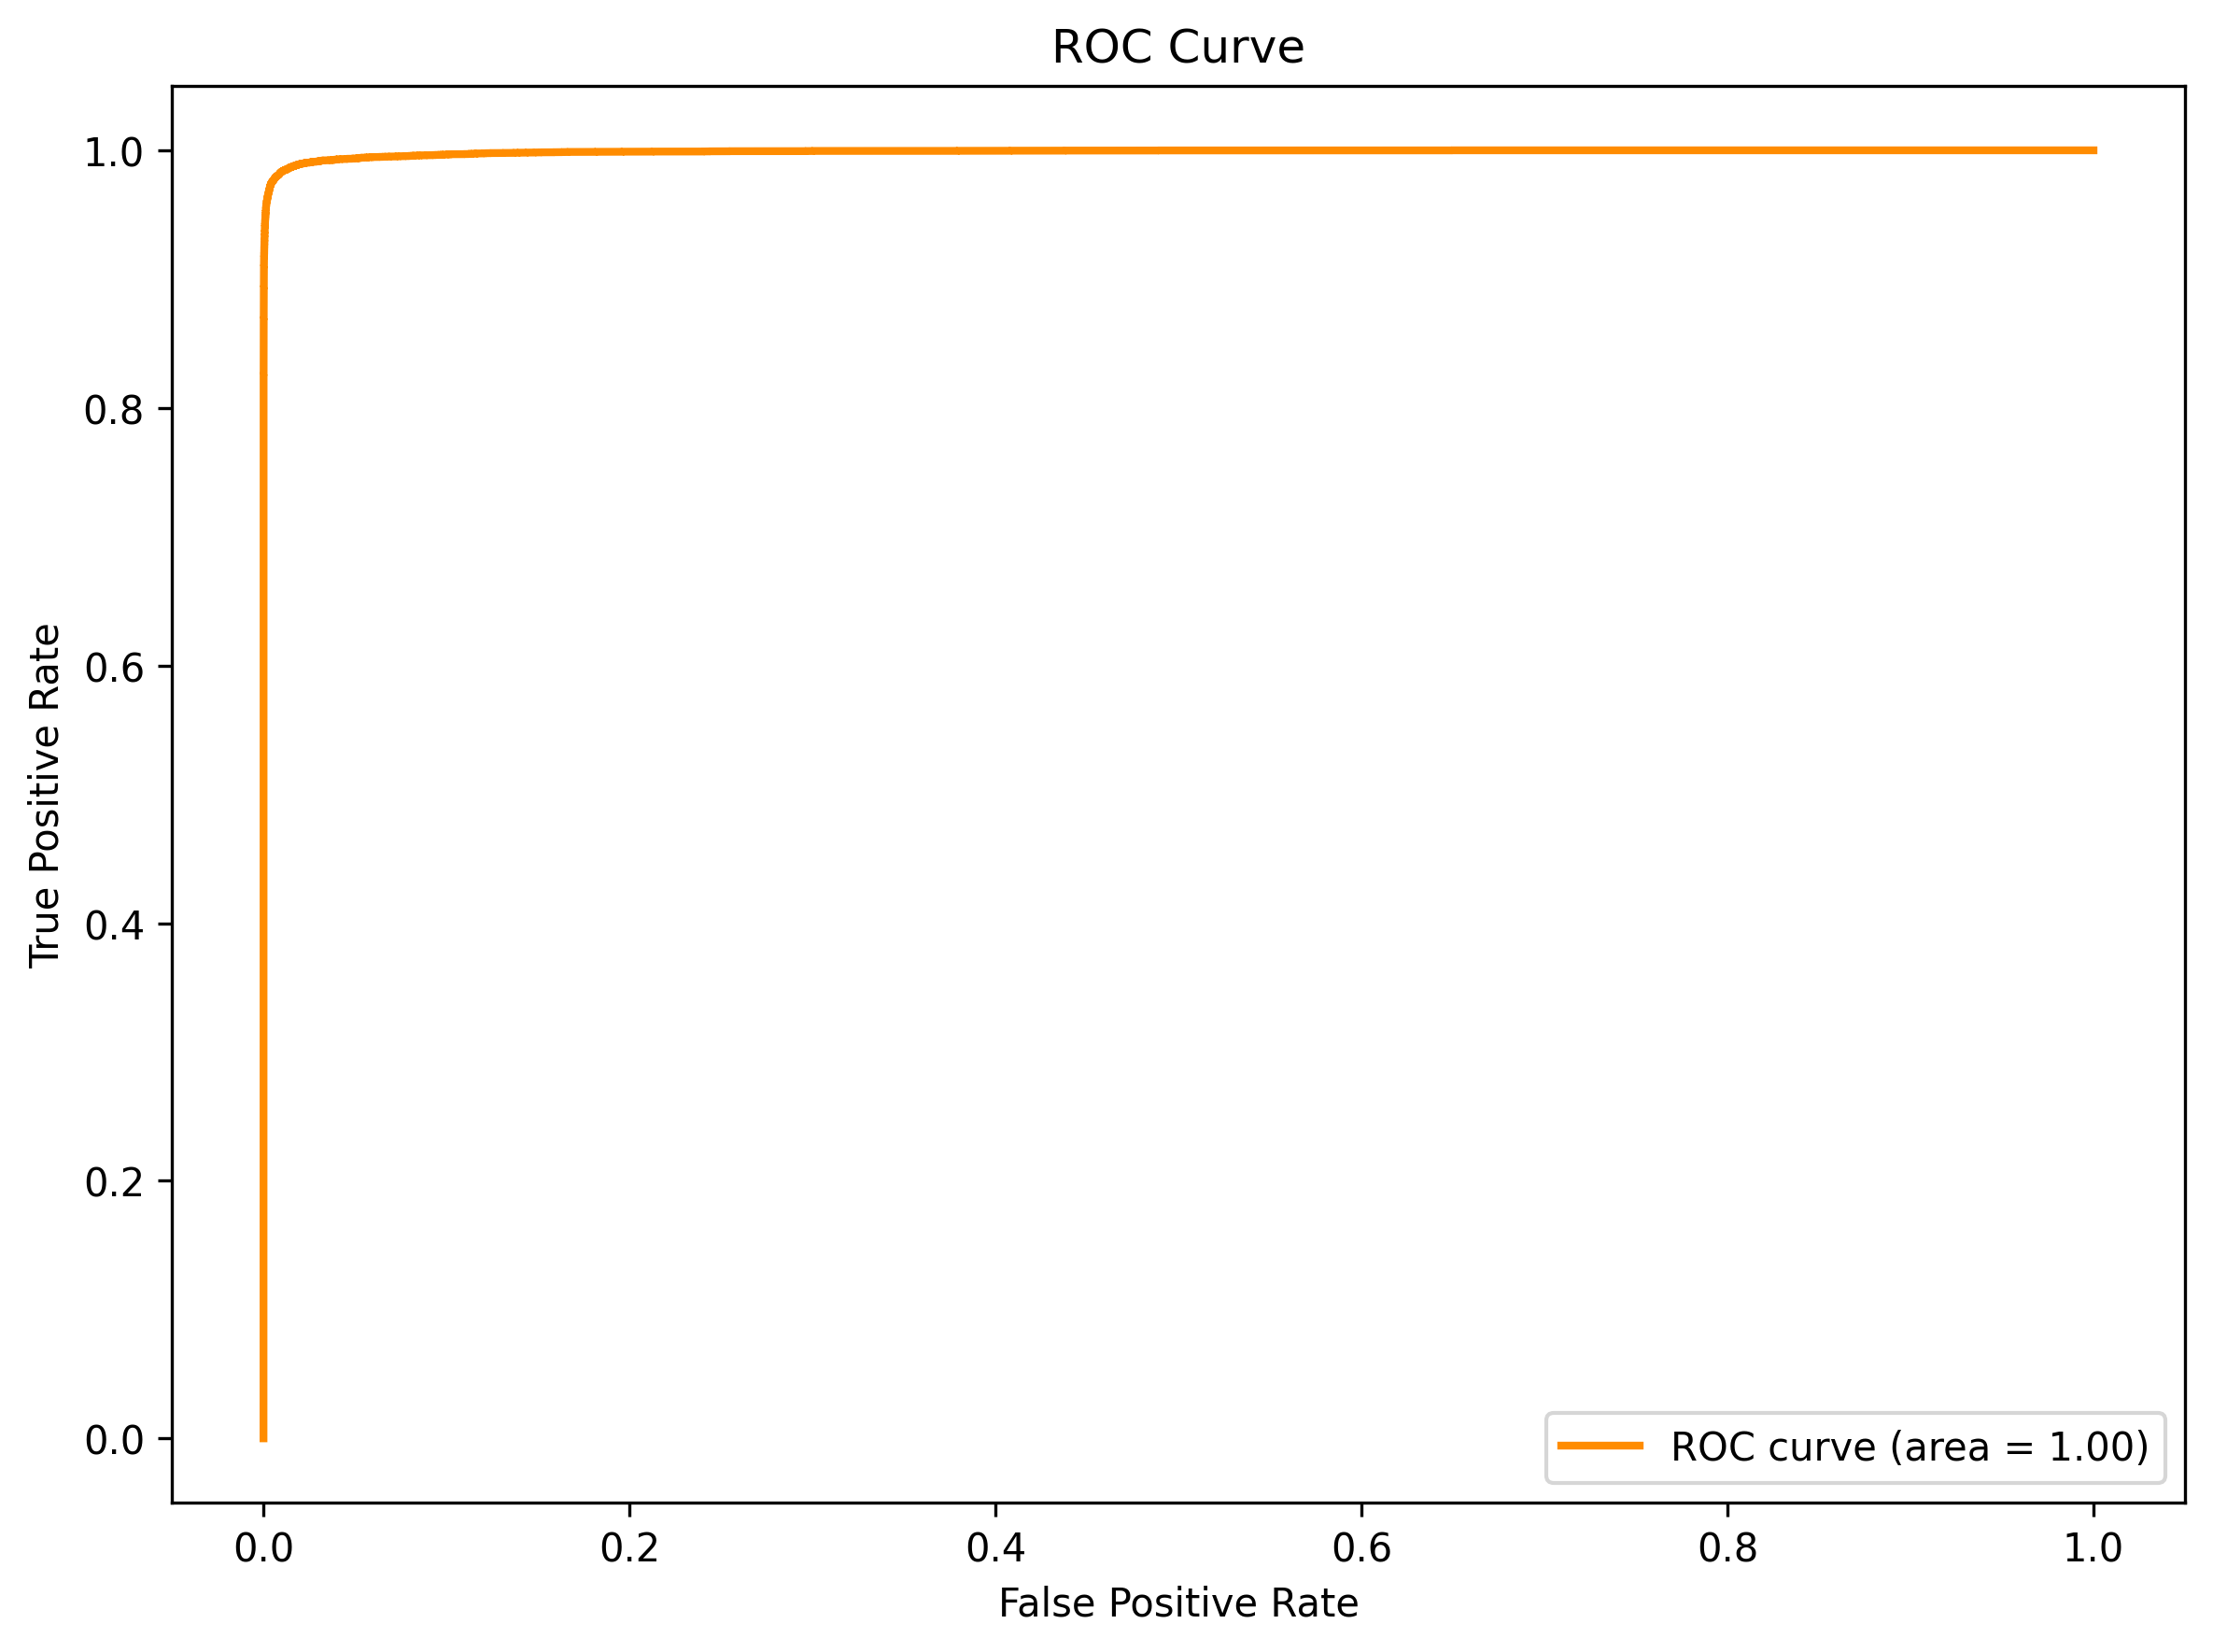

Training metrics: odict_keys(['binary_logloss', 'auc'])
Validation metrics: odict_keys(['binary_logloss', 'auc'])


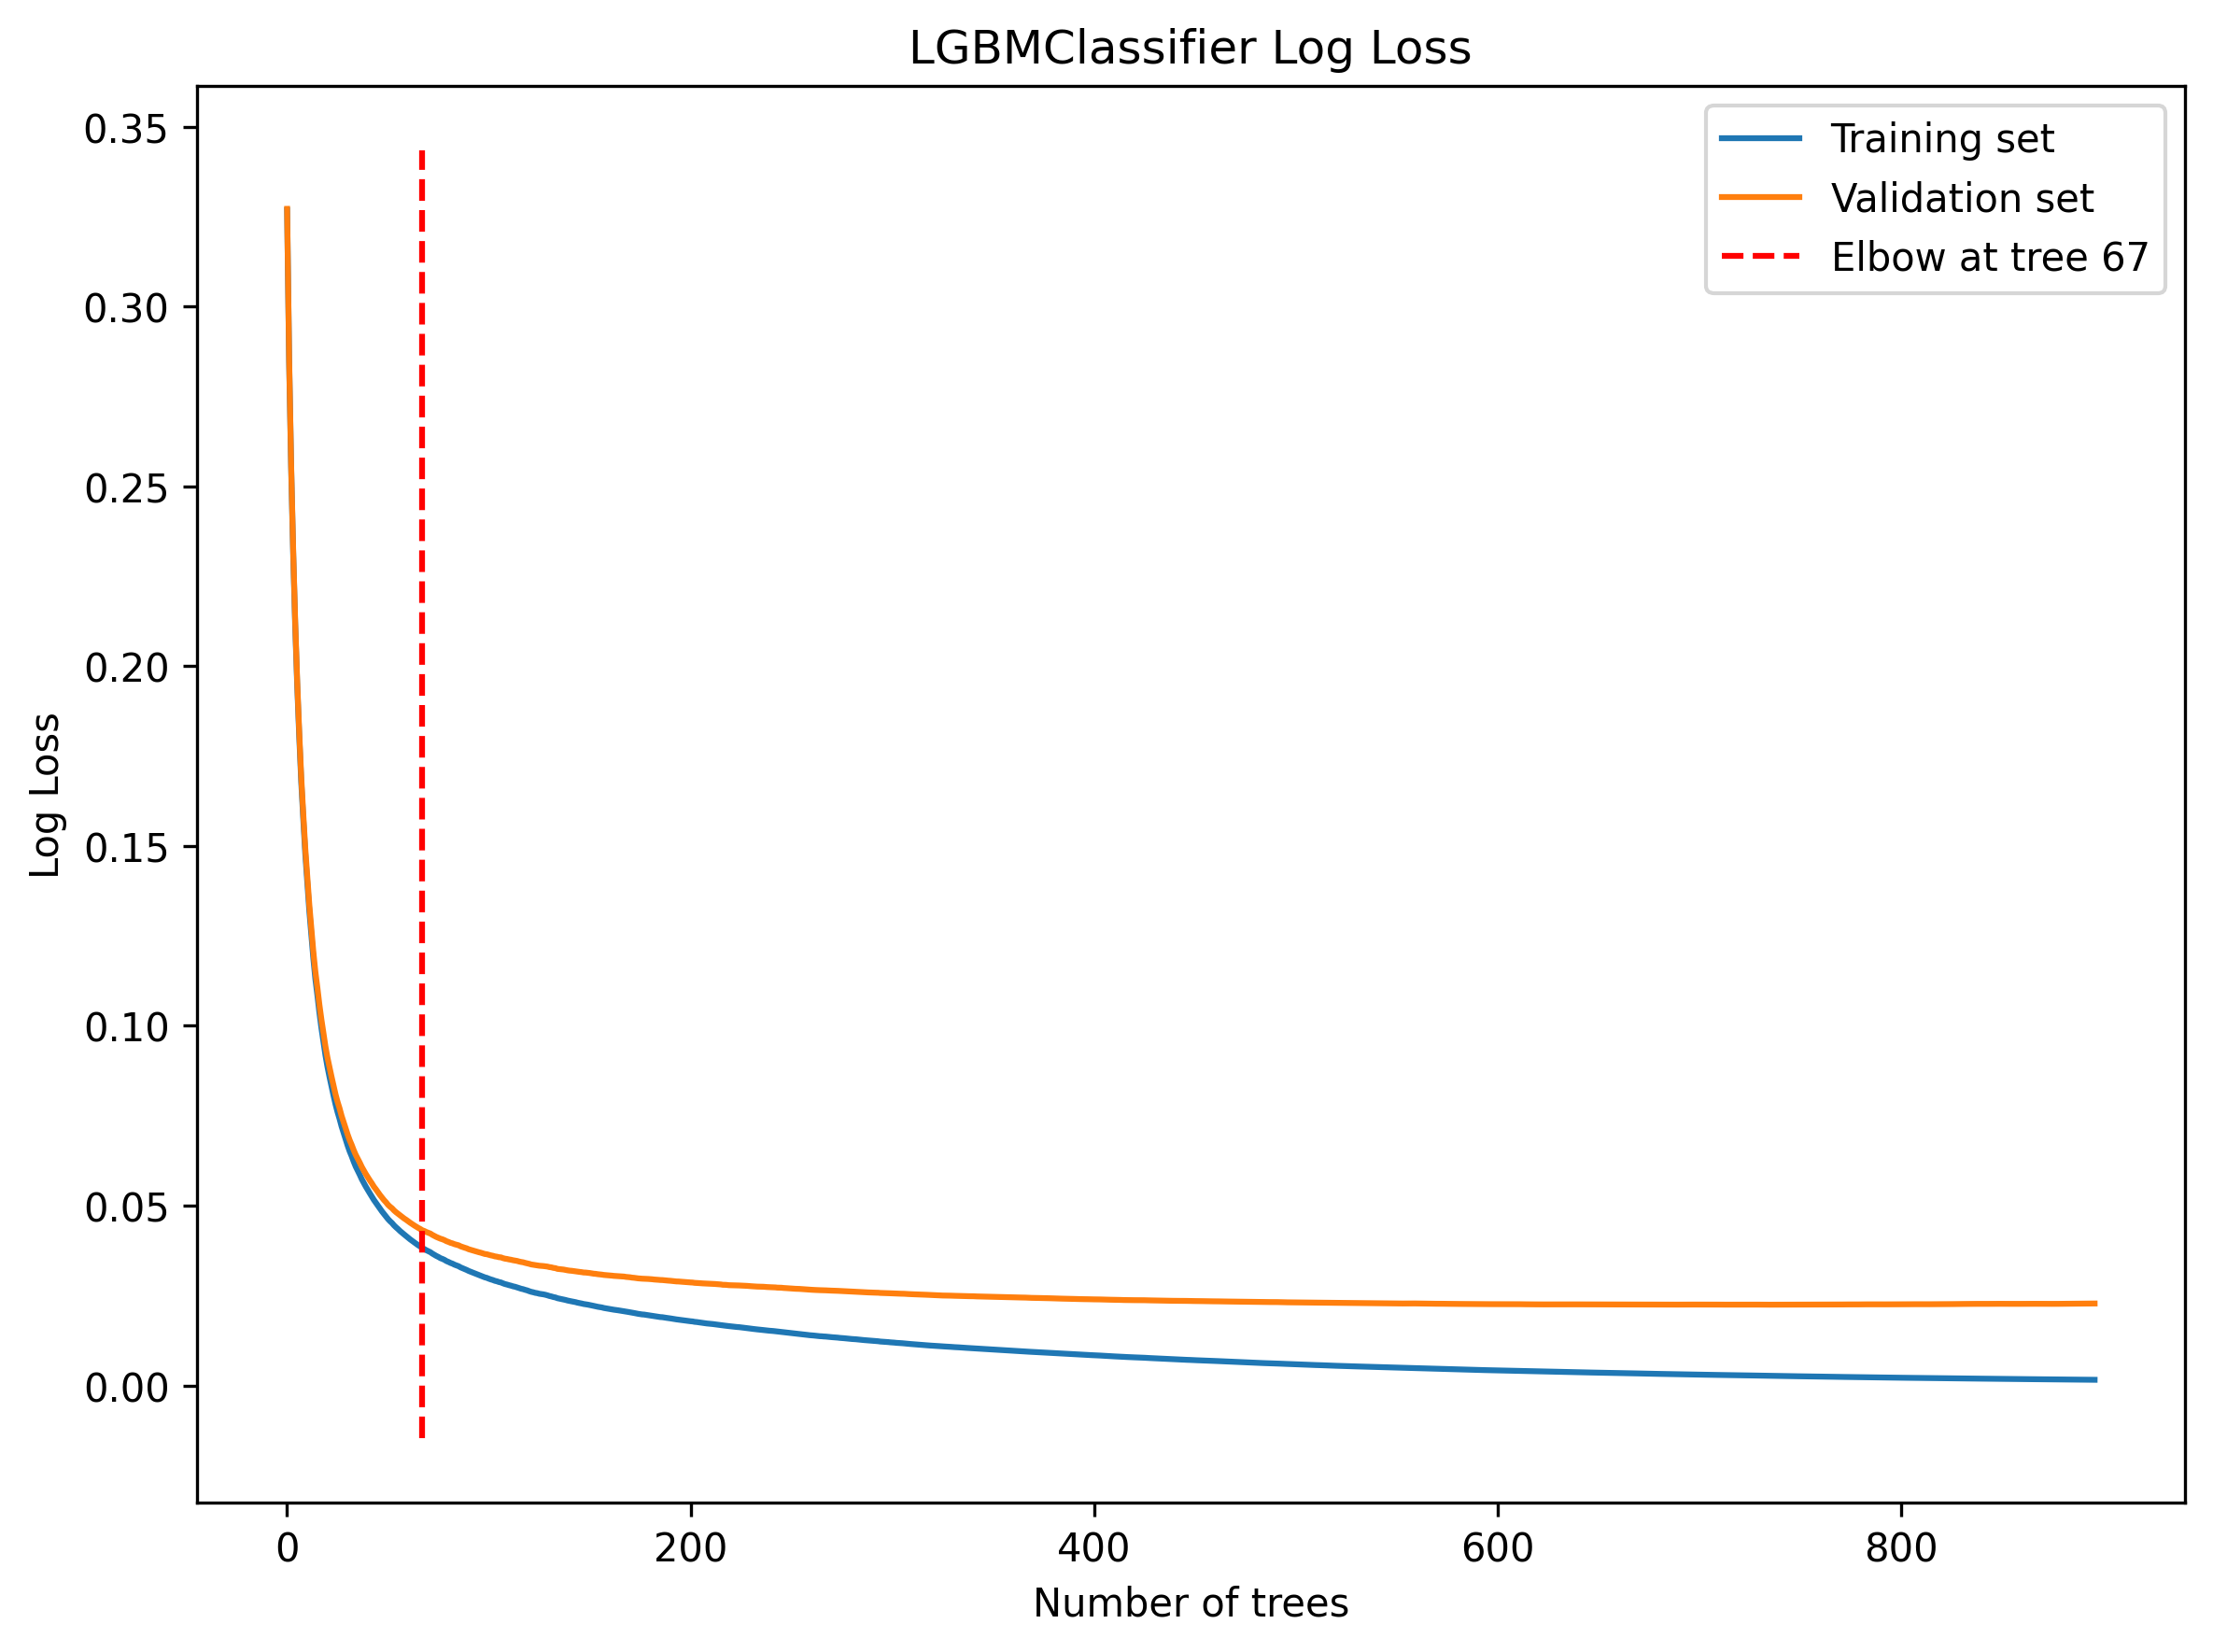

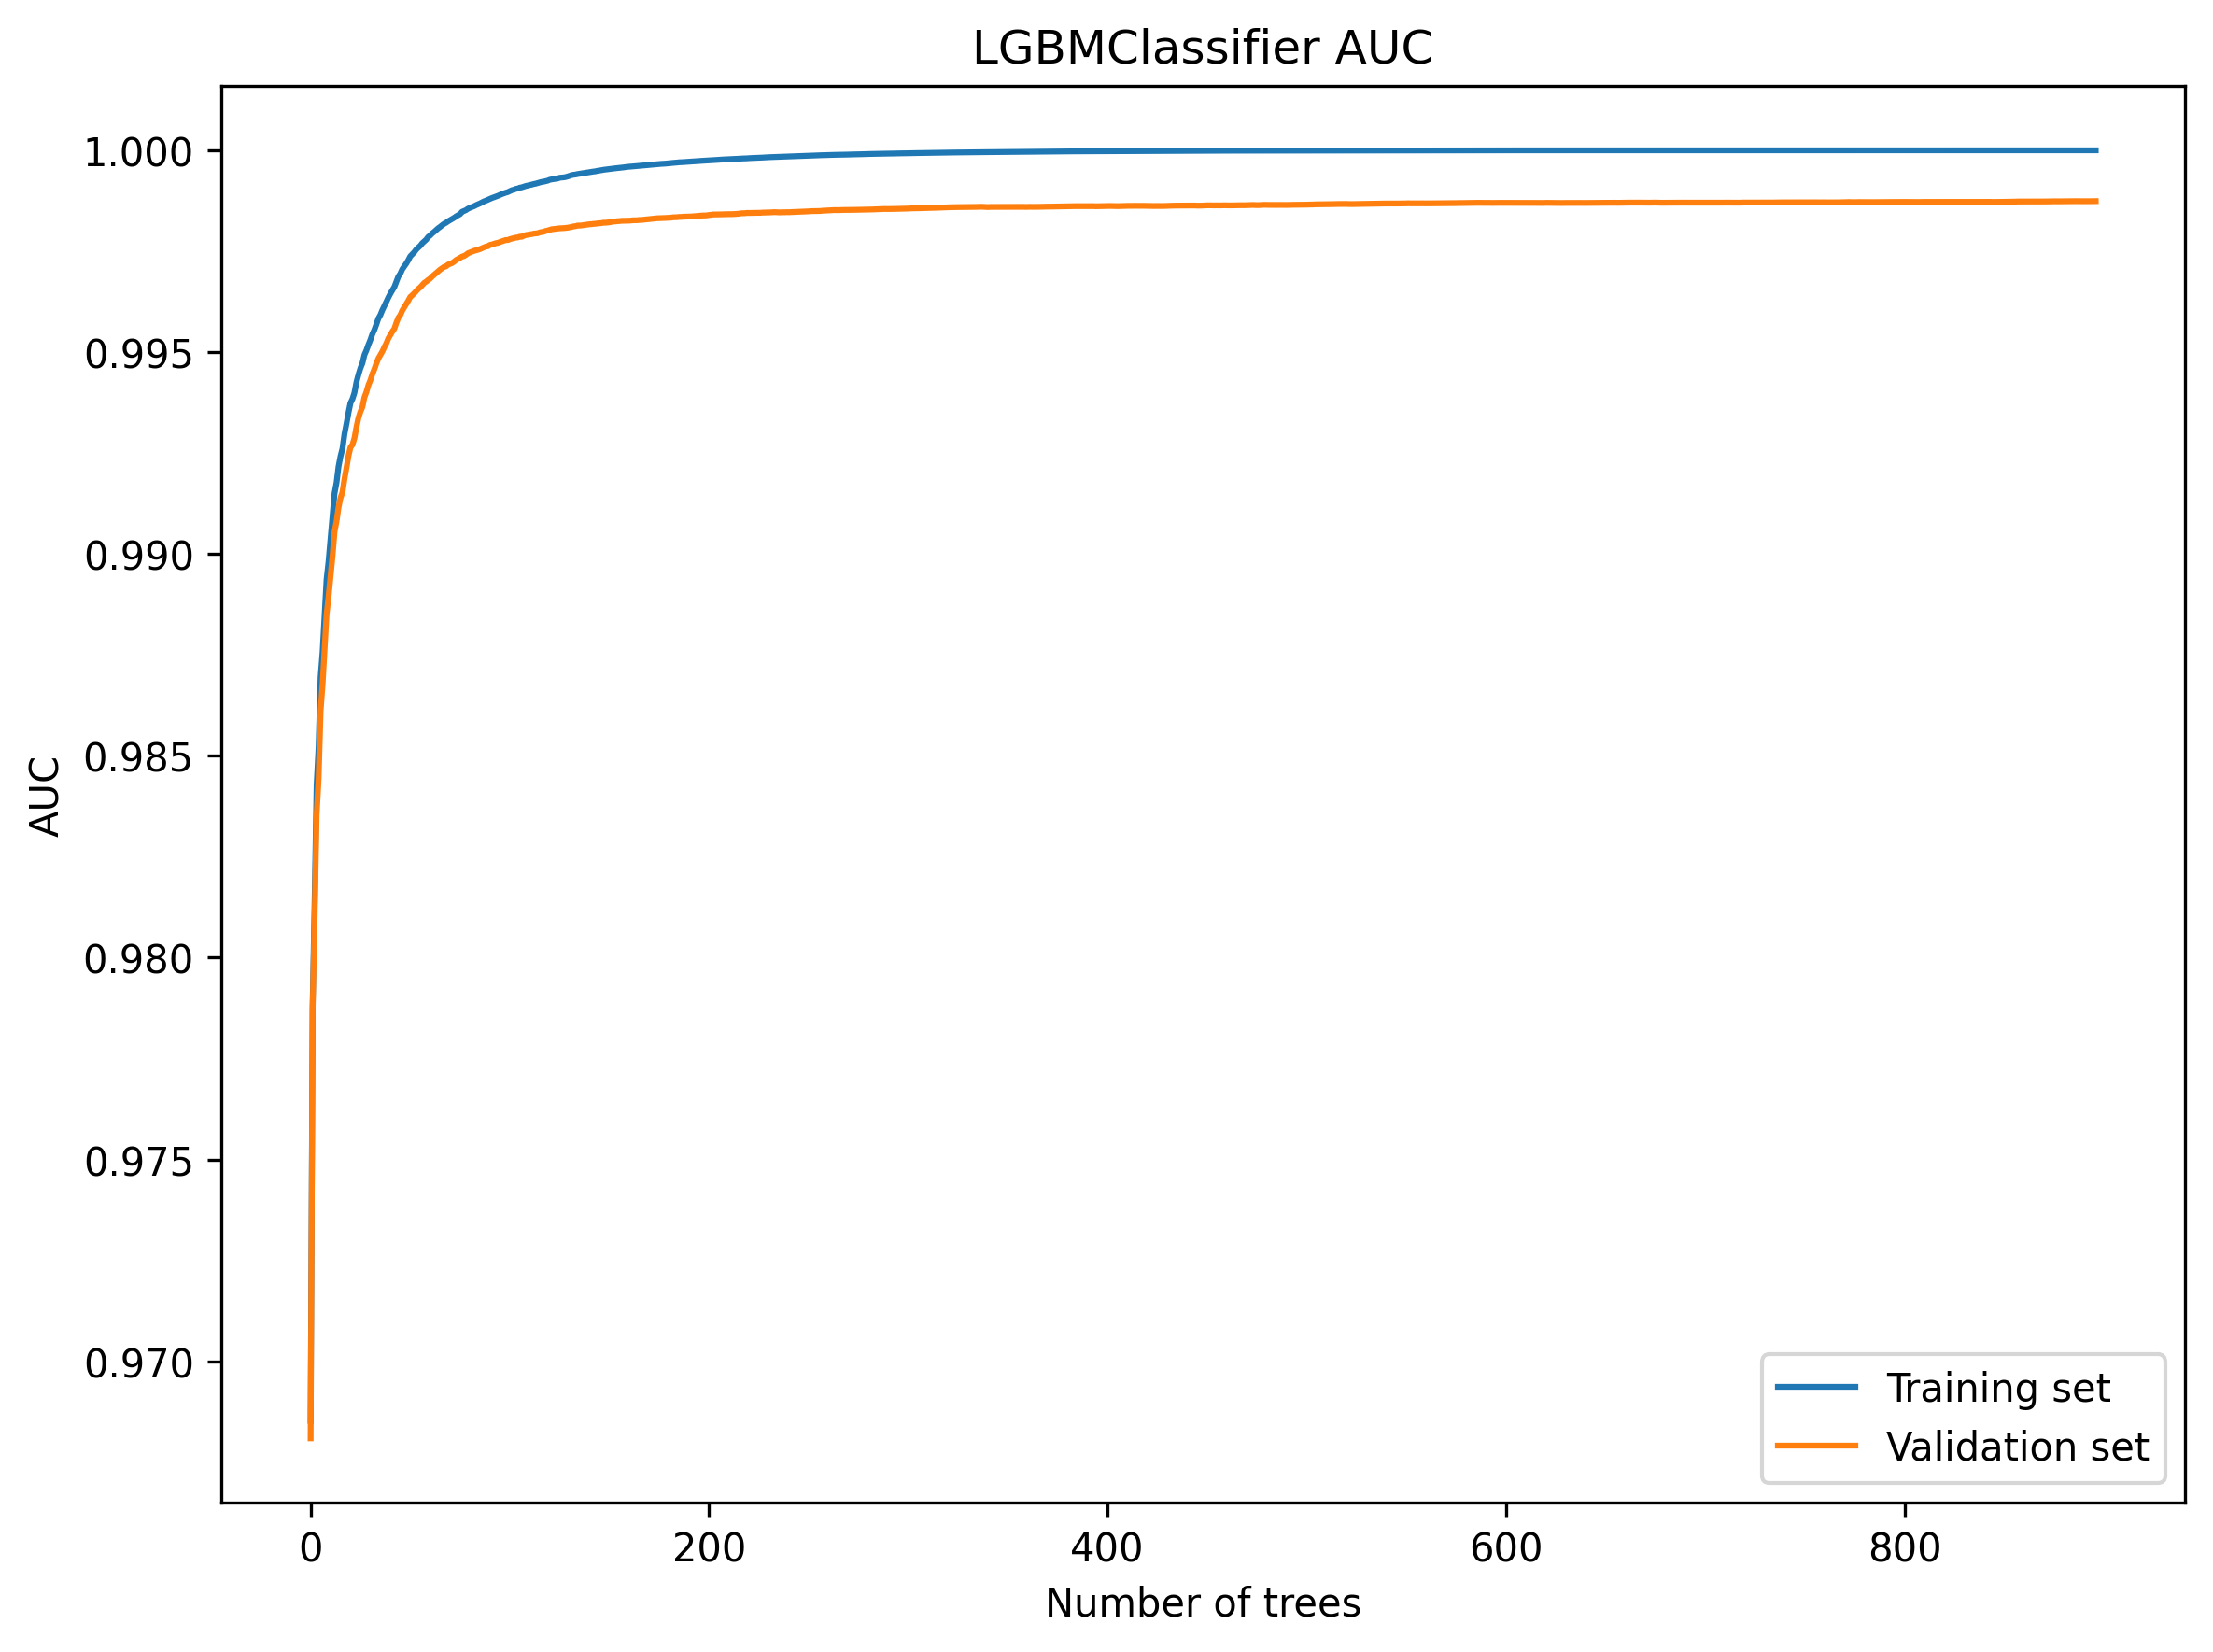

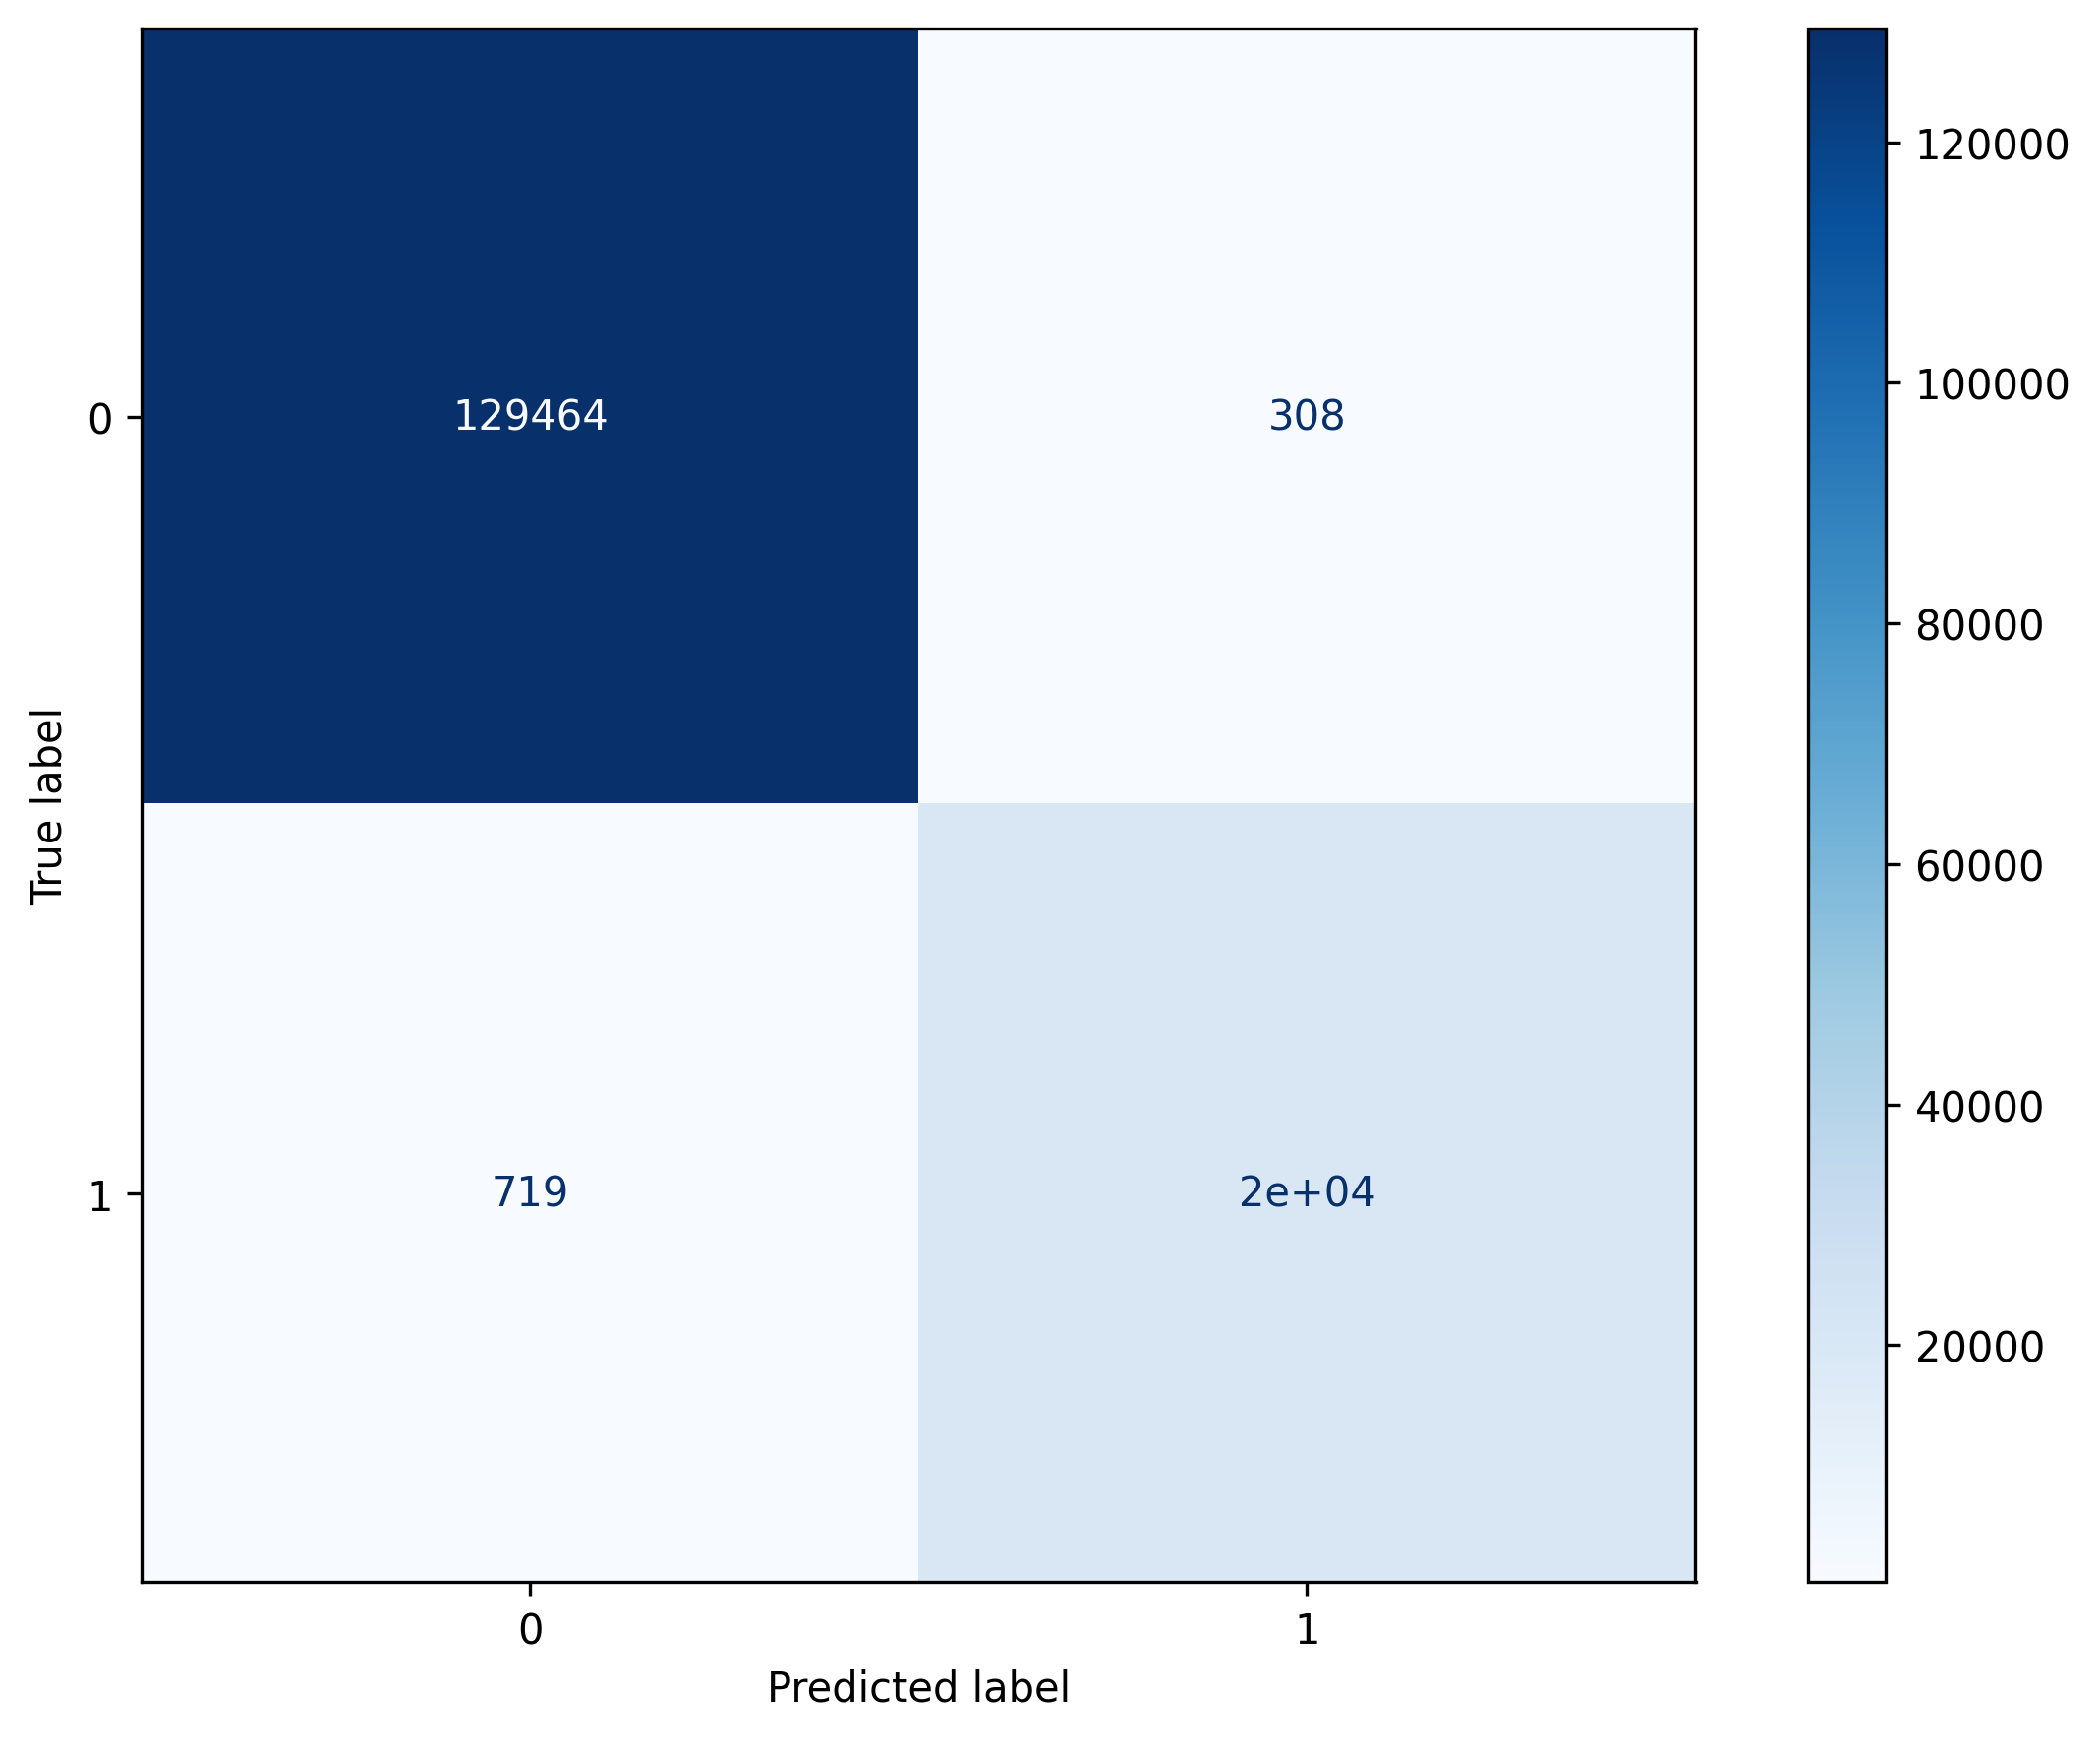

In [51]:
ValidateModel_advanced(X_test, y_test, model)

## LightGBM - Tuning

In [62]:
lgbm_tuning = True

if lgbm_tuning:
    import pandas as pd
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import StratifiedKFold
    from lightgbm import LGBMClassifier  # Updated import

    params = {
        'objective': 'binary',  # binary classification
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        #'n_estimators': 50,  # Number of boosted trees to fit, equivalent to number of boosting iterations
        'random_state': 7,
        "n_estimators": 897,
        "num_leaves": 59,
        "max_depth": 20,
        #"learning_rate": 0.1,
        "objective": "binary",
        "min_child_samples": "27",
        'colsample_bytree': 0.9,
        "reg_lambda": 0.1,
    }

    clf = LGBMClassifier(**params)  # Updated classifier instantiation

    # this is your grid of parameters to search through, every combination will be tried
    grid = {
        "n_estimators": [897, 1350, 1400, 1600],
        "max_depth": [10, 11],
        #"n_estimators": [897],
        #"num_leaves": [59],
        #"max_depth": [20],
        #"learning_rate": [0.11, 0.12, 0.13, 0.2],
        #'scale_pos_weight': [1.7, 1.8, 1.9],
        #"subsample": [0.1],
        #reg_lambda": [0.1],
        #'min_split_gain' : [0.0, 0.1, 0.2]
        #'subsample_for_bin': [215000, 220000, 230000, 240000],
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=grid,
        #n_jobs=-1,
        cv=cv,
        #scoring='neg_log_loss',
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    clf = grid_search.best_estimator_

    scores = pd.DataFrame(grid_search.cv_results_)
    col_names = ['mean_train_score', 'mean_test_score']

    scores = pd.DataFrame(grid_search.cv_results_)



Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 31898, number of negative: 201866
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12388
[LightGBM] [Info] Number of data points in the train set: 233764, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136454 -> initscore=-1.845061
[LightGBM] [Info] Start training from score -1.845061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV 1/3] END max_depth=10, n_estimators=897;, score=(train=1.000, test=0.972) total time=  13.9s
[LightGBM] [Info] Number of positive: 31898, number of negative: 201867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021585 seconds.
You can set `force_row_wise=tr

[CV 2/3] END max_depth=10, n_estimators=1600;, score=(train=1.000, test=0.973) total time=  25.3s
[LightGBM] [Info] Number of positive: 31898, number of negative: 201867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12400
[LightGBM] [Info] Number of data points in the train set: 233765, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136453 -> initscore=-1.845066
[LightGBM] [Info] Start training from score -1.845066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[LightGBM] [Info] Number of positive: 31898, number of negative: 201867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12400
[LightGBM] [Info] Number of data points in the train set: 233765, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136453 -> initscore=-1.845066
[LightGBM] [Info] Start training from score -1.845066
[CV 3/3] END max_depth=11, n_estimators=1600;, score=(train=1.000, test=0.972) total time=  26.0s
[LightGBM] [Info] Number of positive: 47847, number of negative: 302800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12392
[LightGBM] [Info] Number of data points in the train set: 350647, numbe

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      13.062451      0.223880         1.107885        0.023007   
1      19.621575      0.184262         1.702284        0.029593   
2      20.115104      0.199528         1.875011        0.058634   
3      23.107118      0.330284         2.064274        0.173513   
4      12.901465      0.534020         1.151362        0.033506   
5      20.761530      1.994624         1.769609        0.006643   
6      21.566413      2.353979         1.757593        0.071808   
7      23.291121      0.463628         2.060971        0.117186   

  param_max_depth param_n_estimators                                   params  \
0              10                897   {'max_depth': 10, 'n_estimators': 897}   
1              10               1350  {'max_depth': 10, 'n_estimators': 1350}   
2              10               1400  {'max_depth': 10, 'n_estimators': 1400}   
3              10               1600  {'max_depth': 10, 'n_estimators': 

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      13.062451      0.223880         1.107885        0.023007   
1      19.621575      0.184262         1.702284        0.029593   
2      20.115104      0.199528         1.875011        0.058634   
3      23.107118      0.330284         2.064274        0.173513   
4      12.901465      0.534020         1.151362        0.033506   
5      20.761530      1.994624         1.769609        0.006643   
6      21.566413      2.353979         1.757593        0.071808   
7      23.291121      0.463628         2.060971        0.117186   

  param_max_depth param_n_estimators                                   params  \
0              10                897   {'max_depth': 10, 'n_estimators': 897}   
1              10               1350  {'max_depth': 10, 'n_estimators': 1350}   
2              10               1400  {'max_depth': 10, 'n_estimators': 1400}   
3              10               1600  {'max_depth': 10, 'n_estimators': 1600}   
4              11                897   {'max_depth': 11, 'n_estimators': 897}   
5              11               1350  {'max_depth': 11, 'n_estimators': 1350}   
6              11               1400  {'max_depth': 11, 'n_estimators': 1400}   
7              11               1600  {'max_depth': 11, 'n_estimators': 1600}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.971745           0.972408           0.971394         0.971849   
1           0.972383           0.972633           0.972074         0.972363   
2           0.972512           0.972818           0.972168         0.972500   
3           0.972730           0.972920           0.972081         0.972577   
4           0.971903           0.973181           0.970976         0.972020   
5           0.972588           0.973668           0.971721         0.972659   
6           0.972650           0.973858           0.971558         0.972688   
7           0.973037           0.973926           0.971723         0.972895   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.000421                8                 1.0            0.999984   
1        0.000229                6                 1.0            0.999984   
2        0.000266                5                 1.0            0.999984   
3        0.000359                4                 1.0            0.999984   
4        0.000904                7                 1.0            0.999984   
5        0.000796                3                 1.0            0.999984   
6        0.000939                2                 1.0            0.999984   
7        0.000905                1                 1.0            0.999984   

   split2_train_score  mean_train_score  std_train_score  
0                 1.0          0.999995         0.000007  
1                 1.0          0.999995         0.000007  
2                 1.0          0.999995         0.000007  
3                 1.0          0.999995         0.000007  
4                 1.0          0.999995         0.000007  
5                 1.0          0.999995         0.000007  
6                 1.0          0.999995         0.000007  
7                 1.0          0.999995         0.000007

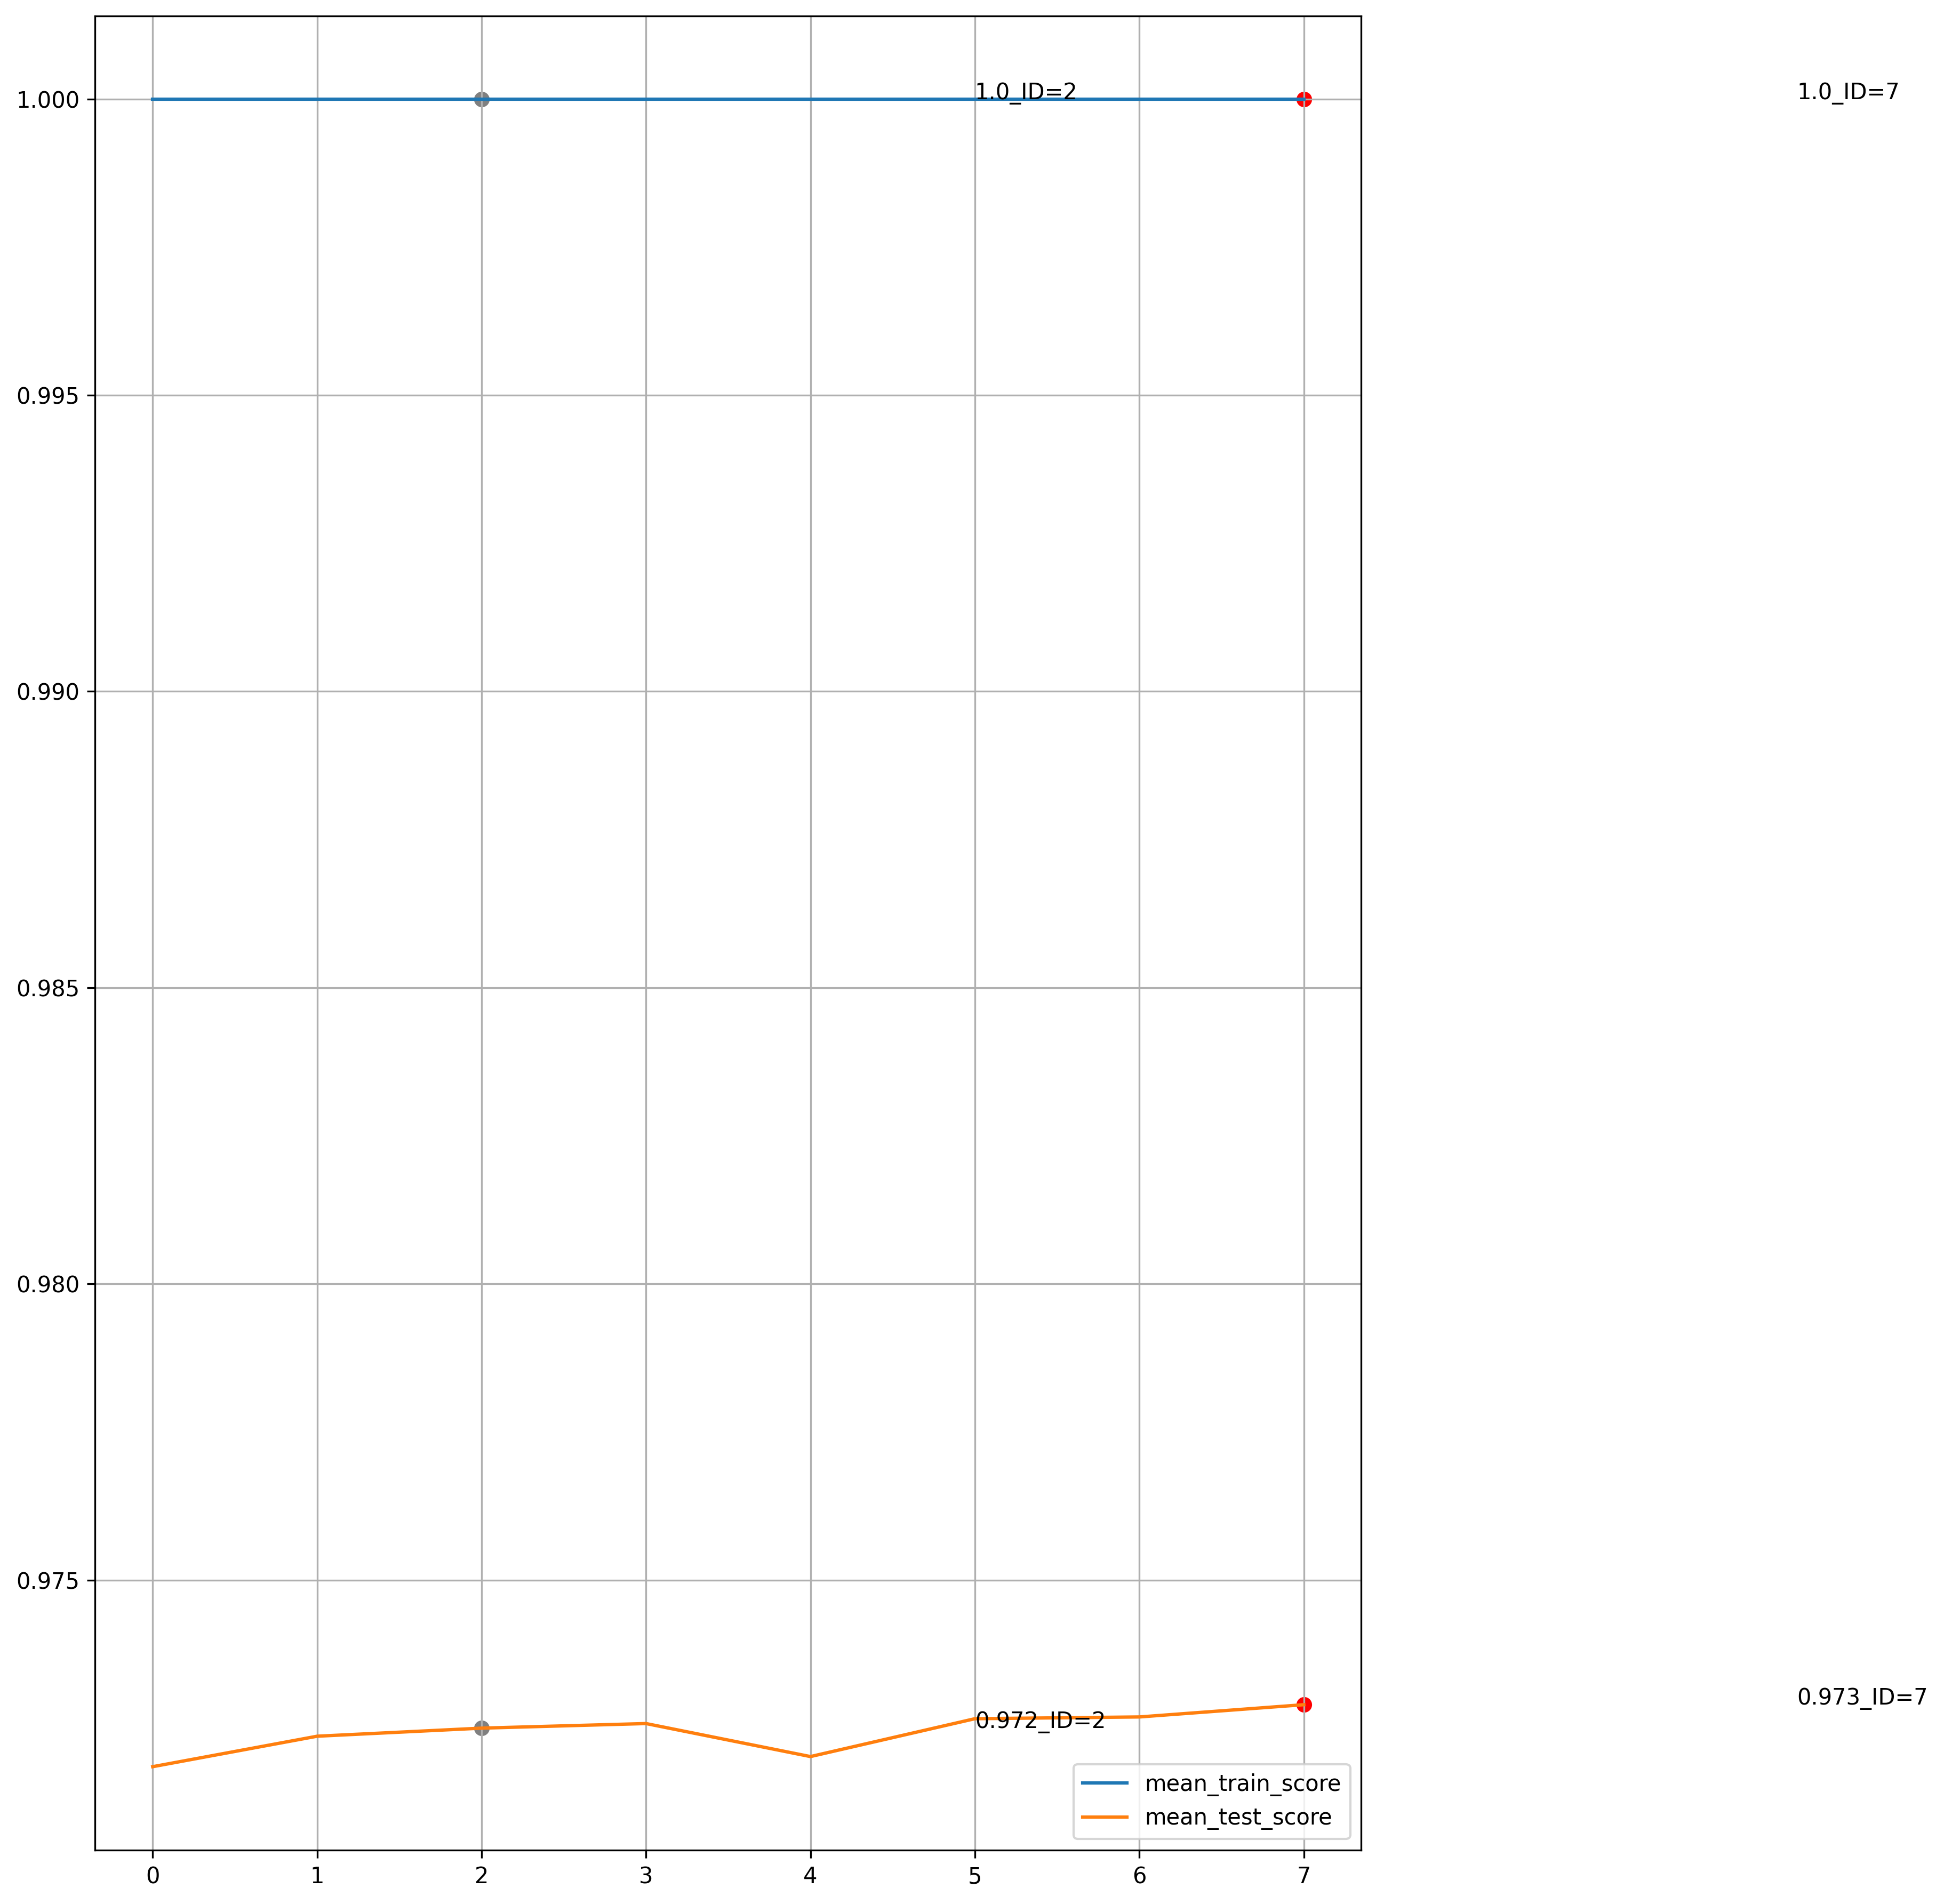

In [63]:
if lgbm_tuning:
    DisplayTuningGraph(scores)

scores